##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer를 이용하여 한국어를 영어로 번역하기

"Attention Is All You Need" 논문이 제안한 Transformer 이용해 한국어를 영어로 바꾸는 모델을 학습합니다.

Transformer의 핵심 아이디어는 self-attention입니다. self-attention은 입력 시퀀스의 벡터 표현을 계산하기 위해 입력 시퀀스 단어의 여러 위치에 대해 attention을 계산합니다. Transformer는 여러겹의 self-attention 층으로 구성되어 있고 "scaled- dot product attention", "Multi-head attention"에서 자세히 설명할 것입니다.

Transformer의 장점과 단점은 다음과 같습니다.

장점

* 모든 층들이 parallel하게 계산됩니다. Transformer는 모든 연산을 matrix 형태로 한 번에 처리할 수 있지만 RNN의 경우에는 매 time-step마다 순서대로 출력값을 계산하기 때문에 연산의 효율성이 떨어집니다.
* 멀리 떨어져 있는 입력 값도 모든 출력 값에 영향을 줄 수 있습니다. RNN의 경우는 멀리 떨어져 있는 입력 값에 대한 영향이 점점 떨어지기 때문에 long-range dependency를 학습하기 힘듭니다. 하지만 Transformer는 아무리 멀리 떨어져 있어도 그 입력에 대한 attention을 계산할 수 있기 때문에 long-range dependency를 훨씬 잘 학습할 수 있습니다. 

단점

* 시계열 데이터의 경우 특정 time-step의 출력값이 항상 모든 과거 정보를 이용해 계산되기 때문에 최근 값이 더 중요한 경우에 대해서는 효율성이 떨어질 수도 있습니다. 최근이 중요함에도 불구하고 계속 전체 과거 정보를 이용하기 때문입니다.


<img src="./images/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## 입력 파이프라인 설정

"tensorflow_datasets"를 이용해 한국어에서 영어로 번역하는 데이터셋을 불러옵니다. 이 데이터셋은 약 50000개의 훈련 데이터와 1100개의 검증 데이터, 2000개의 테스트 데이터로 구성되어 있습니다.

"tensorflow_datasets"를 이용해 한국어에서 영어로 번역하는 데이터셋을 불러옵니다. 이 데이터는 약 90000개의 훈련 데이터로 구성되어 있습니다.

In [3]:
dataset_dir = 'korean-english-news-v1'
en_fname = 'korean-english-park.train.en'
kr_fname = 'korean-english-park.train.ko'

f = open('{}/{}'.format(dataset_dir, en_fname))
en = f.readlines()

f = open('{}/{}'.format(dataset_dir, kr_fname))
kr = f.readlines()

train_dataset = np.c_[kr, en]
del kr, en

train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)

훈련 데이터셋에서 subword tokenizer를 생성합니다. tokenizer는 문장을 단어별로 분리해주는 역할을 합니다.

In [4]:
%time
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for kr, en in train_dataset), target_vocab_size=2**13)

tokenizer_kr = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (kr.numpy() for kr, en in train_dataset), target_vocab_size=2**13)

CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 23.6 µs


In [5]:
sample_string = '트랜스포머 좋습니다!'

tokenized_string = tokenizer_kr.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_kr.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [141, 1038, 3174, 5155, 1809, 276, 7961]
The original string: 트랜스포머 좋습니다!


tokenizer는 문장을 subword 단위로 encoding 합니다. 만일 단어가 tokenizer의 dictionary에 없으면 더 작은 단위로 쪼갭니다.

In [6]:
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_kr.decode([ts])))

141 ----> 트
1038 ----> 랜
3174 ----> 스포
5155 ----> 머 
1809 ----> 좋
276 ----> 습니다
7961 ----> !


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [8]:
tokenizer_kr.vocab_size

8184

In [9]:
print(tokenizer_en.vocab_size) # word index: 0~8086

8152


모델에 문장의 시작과 끝을 알려주기 위해 start token과 end token을 추가합니다.


In [10]:
# start token: 8087, end token: 8088
def encode(lang1, lang2):
  lang1 = [tokenizer_kr.vocab_size] + tokenizer_kr.encode(
      lang1.numpy()) + [tokenizer_kr.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

`Dataset.map` 을 이용해 'encode' 함수를 적용해야 하지만 `Dataset.map`은 graph mode에서만 작동합니다. 

* 그래프 텐서는 값을 가지지 않습니다. 그래프만 만들고 나중에 값을 대입합니다.
* 그래프 모드에서는 Tensorflow에 내장되어 있는 연산이나 함수만 쓸 수 있습니다.

따라서 '.map'을 이용해 'encode' 함수를 바로 적용할 수 없습니다. `tf.py_function`을 이용해 'encode'함수를 감싸야 합니다. `tf.py_function`는 텐서를 'encode' 함수의 입력값으로 쓰일 수 있도록 해줍니다.

In [11]:
def tf_encode(lang):
  result_kr, result_en = tf.py_function(encode, [lang[0], lang[1]], [tf.int64, tf.int64])
  result_kr.set_shape([None])
  result_en.set_shape([None])

  return result_kr, result_en

학습 속도를 올리기 위해 토큰 길이가 40을 넘는 예제는 버립니다.

In [12]:
MAX_LENGTH = 40

In [13]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [14]:
# sos + encoded tocken + eos
train_dataset = train_dataset.map(tf_encode)
# 토큰 길이 40 이상의 토큰 필터링
train_dataset = train_dataset.filter(filter_max_length)

In [15]:
# Encoding 후, sos, eos가 잘 붙었는지, 토큰 길이가 40 미만인지 dataset을 확인합니다.
def print_dataset(dataset, num_print):
    iterator = iter(dataset)
    for i in range(num_print):
        kr, en = iterator.get_next()
        print('idx of data: {}\nkr shape: {}\nkr data: {}\nen shape: {}\nen data: {}\n'.format(i, kr.shape, kr, en.shape, en))

print_dataset(train_dataset, 10)

idx of data: 0
kr shape: (23,)
kr data: [8184 3050  793 1882  832    2 2421 7960 1319   92   91   36 4496 2893
  453   27  781  737 2612 7991 7962 7938 8185]
en shape: (18,)
en data: [8152 1122  492    5 2240 4444 2297   89   14 1906   38  111  133  249
 3016 7959 4353 8153]

idx of data: 1
kr shape: (30,)
kr data: [8184  222  519   75 3837   23 7398 7960   16    3  519   75 3837   31
 1027  532 2452  929    7   75 3837 7960  432 6094 1166   16  118  729
    1 8185]
en shape: (36,)
en data: [8152  184    7 5747 7928    7  503  845 1374   53    7 1283  892 7557
  484 4024  357  667 3105 7928 5460   33 1437    8  315 1283  892 7557
  758    2 4024  357 5460 7997    3 8153]

idx of data: 2
kr shape: (13,)
kr data: [8184   88 2724  215 1027  121   31 1166   16  118  729    1 8185]
en shape: (22,)
en data: [8152  606  713  100  667 3105 7928 3872 7997    2  103   34   66 1557
 7935   43  592    7 1333 8003    3 8153]

idx of data: 3
kr shape: (19,)
kr data: [8184 7962  688  112 2549    6 17

In [16]:
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()

# 배치로 학습하기 위해서는 문장의 길이를 같게 해야 합니다. 하지만 실제 입력 문장의 길이는 모두 다릅니다.
# 따라서 배치 안에서 동일한 문장 길이를 유지하기 위해 padding을 합니다 보통 문장 뒤에 0을 삽입하여
# 문장의 길이를 맞춰줍니다.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)

In [17]:
# Optional
# This allows later elements to be prepared while the current element is being processed.
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
# prefetch를 함으로써 현재 batch를 processing 하는동안 다음 batch를 준비합니다.
# 이 과정은 추가적인 메모리를 요구하지만, latency와 throughput을 높여줍니다.
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
print_dataset(train_dataset, 10)

idx of data: 0
kr shape: (64, 40)
kr data: [[8184  256  405 ...    0    0    0]
 [8184   75 1164 ...    0    0    0]
 [8184 7890 7960 ...    0    0    0]
 ...
 [8184 7995 7994 ...    0    0    0]
 [8184   75 5933 ...    0    0    0]
 [8184   12  417 ...    0    0    0]]
en shape: (64, 40)
en data: [[8152   93 1357 ...    0    0    0]
 [8152  935  255 ...    0    0    0]
 [8152 7930   61 ... 8153    0    0]
 ...
 [8152   11 2071 ...    0    0    0]
 [8152 1543   95 ...    0    0    0]
 [8152    2  184 ...    0    0    0]]

idx of data: 1
kr shape: (64, 40)
kr data: [[8184   45 1241 ...    0    0    0]
 [8184 5763   10 ...    0    0    0]
 [8184 5573  165 ...    0    0    0]
 ...
 [8184 1733    4 ...    0    0    0]
 [8184 5438 3913 ...    0    0    0]
 [8184   76 4405 ...    0    0    0]]
en shape: (64, 39)
en data: [[8152  730 3396 ...    3 8153    0]
 [8152  361 6740 ...    0    0    0]
 [8152 7930 3927 ...    0    0    0]
 ...
 [8152  642   61 ...    0    0    0]
 [8152 5029   16 ...

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

## Positional encoding

Transformer는 문장을 순서대로 넣는 것이 아니라 한 번에 병렬로 처리하기 때문에 단어의 순서에 대한 정보가 별도로 주어져야 합니다. embedding vector에 positional encoding vector를 더해 줌으로써 한 문장 내의 단어들의 위치에 대한 정보를 추가합니다. embedding vector는 단어들의 상대적인 위치를 반영하지 않습니다. positional encoding을 통해 문장 내에 거리가 가까운 단어들이 좀 더 비슷한 vector를 가지도록 조정합니다. 다음의 함수를 이용해 positional encoding을 시행합니다.
$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [19]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [20]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


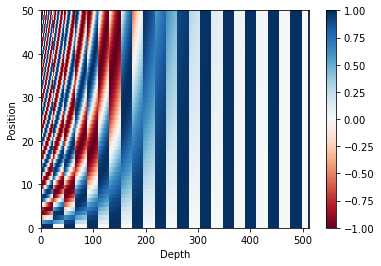

In [21]:
pos_encoding = positional_encoding(50, 512) # (1, 50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

같은 배치내에 있는 문장의 길이를 일치시키기 위해 padding을 이용했습니다. 하지만 이는 실제 입력이 아니기 때문에 입력에서 padding을 제거해야 합니다. masking을 이용해 padding을 가려줌으로써 모델이 padding을 입력으로 인식하지 못하도록 합니다. 여기서 padding에 해당하는 숫자는 0입니다. 따라서 0이 나타나는 부분을 masking을 이용해 가려줍니다. 

In [22]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # 추후 multi-head attention에 이를 이용할 것이므로 차원 2개를 중간에 추가해줍니다. 

  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [23]:
# masking으로 가리는 부분을 1, 아니면 0
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

번역 결과를 학습하기 위해서는 타겟 이전의 단어들만 고려해야 합니다. 그 이유는 학습 후에 번역된 문장을 만들기 위해서는 단어를 앞에서부터 뒤로 순서대로 생성해야 하기 때문입니다. 즉 앞에서 뒤로 단어를 순서대로 만들 수 있는 모델을 학습하기 위해서는 타겟 이후의 단어들을 고려하면 안 됩니다. 예를 들면 세 번째 단어를 예측하기 위해서는 첫 번재, 두 번째 단어만을 보고 예측합니다. 따라서 네 번째, 그리고 그 이후의 단어들을 가려야 합니다. 

In [59]:
tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [24]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [25]:
# masking으로 가리는 부분을 1, 아니면 0
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="./images/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

attention을 계산하기 위해서는 Q (query), K (key), V (value) 세 가지 요소가 필요합니다. 다음의 식을 이용해 attention을 계산합니다.

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

dot-product attention을 계산할 때 sqrt(d_k)로 나눠줍니다. 그 이유는 d_k가 커질수록 dot-product의 값의 분산도 커지기 때문입니다. 이는 softmax 함수가 작은 값들을 무시할 가능성이 커지고 그 결과 dot-product의 값이 작은 부분에 gradient가 흐르지 않게 됩니다.  

예를 들면 'Q', 'K' 가 평균 0 분산 1를 가진다고 가정합니다. 두 matrix의 행렬 곱의 값은 평균 0 분산 d_k를 가집니다. 따라서 sqrt(d_k)는 'Q', 'K'의 행렬 곱의 값이 평균 0 분산 1로 만들어주는 역할을 합니다. 따라서 좀 더 부드러운 softmax 값을 기대할 수 있습니다.

mask 에는 음의 무한대와 가까운 -1e9 값을 곱해줍니다. Q, K의 행렬 곱 값이 음의 무한대와 가까우면 softmax시에 0에 가까운 값이 될 것이기 때문에 masking된 부분을 무시하는 효과를 얻을 수 있습니다. 만일 masking 되는 부분에 이 값을 곱하지 않으면 Q, K의 행렬 곱 결과가 masking 되는 부분에 0이 될텐데 이는 softmax 후에 0이 되지 않을 가능성이 큽니다. 

In [26]:
def scaled_dot_product_attention(q, k, v, mask):


  '''
  attention weight 계산
  seq_len_k = seq_len_v.
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)

  Returns:
    output, attention_weights
  '''
  # transpose_a=True => 첫 번째 matrix의 마지막 두 차원이 transpose됨
  # transpose_b=True => 두 번째 matrix의 마지막 두 차원이 transpose됨

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # matmul_qk: (..., seq_len_q, seq_len_k)

  # tf.cast: 입력을 텐서로 바꿔줌
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # mask 된 부분에 -1e9를 더해줌 => softmax 후 0이 됨.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

softmax 함수가 attention_weights의 마지막 축 seq_len_k 방향으로 합이 1이 되도록 계산되었기 때문에 각 Q에 대한 K의 중요도를 의미합니다.

즉 output은 각 Q에 대해 중요한 V만을 남기고 필요없는 V는 버릴 수 있습니다.

In [27]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [28]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

# output; 0 * [1,0] + 1 * [10,0] + 0 * [100,5] + 0 * [1000, 6]
# 주어진 q에 대해 중요한 v만 남긴 결과가 output으로 나옵니다.
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [29]:
# 즉 output은 temp_v의 row vector를 attention weight에 의해 weighted average 된 값이라고 할 수 있습니다.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
# output: 0 * [1,0] + 0 * [10,0] + 0.5 * [100,5] + 0.5 * [1000, 6]
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [30]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
# output: 0.5 * [1,0] + 0.5 * [10,0] + 0 * [100,5] + 0 * [1000, 6]
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


이제까지는 q에 대해 각각 output을 계산했는데 이번에는 q들을 묶어서 계산합니다.

In [31]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="./images/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention은 다음 4가지 부분으로 구성되어 있습니다:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

multi-head attention에는 Q (query), K (key), V (value) 세 가지가 입력으로 들어갑니다. 이 입력들은 linear (Dense) layer를 통과한 후 multiple head로 쪼갭니다 (multi-head attention).

각 head 별로 `scaled_dot_product_attention`을 계산합니다. 여러 head에서 계산된 attention output은 concatenation이 됩니다. 그 다음 linear (Dense) layer를 통과합니다.

여러 head을 이용해 attention output을 계산하는 이유는 서로 다른 시점의 중요한 정보를 뽑아낼 수 있고 이 정보들을 통해 모델의 학습 능력을 향상시킬 수 있기 때문입니다. 

여러 head로 쪼개지 않고 하나의 attention output을 계산하는 것과 여러 head을 이용해 여러 개의 attention output을 계산하는 것은 연산량에 있어서 차이가 없습니다.

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0 # d_model 길이의 vector를 num_heads 만큼 쪼개야 하기 때문에 나누어 떨어져야합니다.
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model) # d_model: 출력 값의 차원, query를 계산하는데 쓰임
    self.wk = tf.keras.layers.Dense(d_model) # d_model: 출력 값의 차원, key를 계산하는데 쓰임
    self.wv = tf.keras.layers.Dense(d_model) # d_model: 출력 값의 차원, value를 계산하는데 쓰임
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    
    # d_model을 num_heads * depth 로 쪼갭니다.
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3]) 
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    
    # num_head 만큼의 attention output을 concatenation 합니다.
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model), d_model=num_heads*depth

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [33]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(v=y, k=y, q=y, mask=None)
out.shape, attn.shape
# 총 8개의 attention weight가 생성됩니다.

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network는 두 개의 fully-connected layer (linear, dense layer) 와 ReLU 활성화 함수로 구성되어 있습니다.

In [34]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [35]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

### Encoder layer

각 encoder layer는 두 개의 sublayer로 구성되어 있습니다.

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

각각의 sublayer들은 residual connection 과 layer normalization을 차례대로 적용합니다. residual connection은 신경망의 gradient 소실 문제를 해결할 수 있습니다.

각 sublayer의 output은 `LayerNorm(x + Sublayer(x))`로 계산됩니다. normalization은 `d_model` (last) axis 방향으로 이루어집니다. N개의 encoder가 쌓여서 하나의 전체 encoder layer를 구성합니다.

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [37]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

각각 decoder layer를 다음 sublayer로 구성되어 있습니다.


1.   Masked multi-head attention (with look ahead mask and padding mask), decoder의 입력은 영어 문장이 들어갑니다. 학습 과정에서는 전체 문장이 입력값으로 들어가는데 문장의 다음 단어를 예측하기 위해서는 이전 단어들만 보고 예측해야 합니다. 따라서 이후 단어들에 대해서는 masking을 통해 가려줍니다. (look ahead mask).
2.   Multi-head attention (with padding mask). V (value) and K (key)는 encoder의 출력값을 이용하고, Q (query)는 decoder의 multi-head self attention의 출력 값을 이용합니다.
3.   Point wise feed forward networks

각 sublayer의 output은 LayerNorm(x + Sublayer(x))로 계산됩니다. normalization은 d_model (last) axis 방향으로 이루어집니다. N개의 decoder가 쌓여서 하나의 전체 decoder layer를 구성합니다.

V, K는 encoder의 출력값, Q는 decoder의 multi-head self attention 출력값을 이용하기 때문에 attention weights는 주어진 decoder 입력값에 대한 encoder 출력값의 중요도를 의미합니다. 즉, decoder는 다음 단어를 encoder의 출력값과 decoder의 self-attention을 이용하여 예측합니다. 

In [38]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
   
    # 표준편차가 0이 되는 경우에 에러가 나기 때문에 표준편차에 epsilon를 더해줍니다.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) 
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    # encoder의 출력값이 key, value에 들어갑니다.
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [39]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

`Encoder`의 구성요소는 다음과 같습니다.
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

입력 embedding 과 positional encoding을 더합니다. 더한 값을 N개의 encoder layer의 입력값으로 이용합니다.

In [40]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [41]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

`Decoder`의 구성 요소는 다음과 같습니다.
1.   Output Embedding, 번역 결과가 되는 영어 문장에 대한 embedding입니다.
2.   Positional Encoding 
3.   N decoder layers

타겟인 영어 문장이 decoder의 입력값으로 들어가기 때문이 이 또한 positional encoding이 필요합니다. decoder의 최종 출력값을 결과를 예측하는 마지막 layer의 입력값으로 들어갑니다.

In [42]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [43]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer 생성하기

Transformer는 encoder, decoder, 최종 linear layer로 구성됩니다.

In [44]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [45]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## hyperparameter 설정

모델의 크기를 줄이고 학습 속도를 키우기 위해 *num_layers, d_model, dff* 가 작아야 합니다.

*num_layers=6*, *d_model = 512*, *dff = 2048*. 은 "attention is all you need" 논문의 base model에 해당합니다.

In [46]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_kr.vocab_size + 2 # start, end token이 추가되었기 때문에 2가 더해집니다.
target_vocab_size = tokenizer_en.vocab_size + 2 # start, end token이 추가되었기 때문에 2가 더해집니다.
dropout_rate = 0.1

## Optimizer

Adam optimizer와 다음 learning rate scheduler를 이용합니다.

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

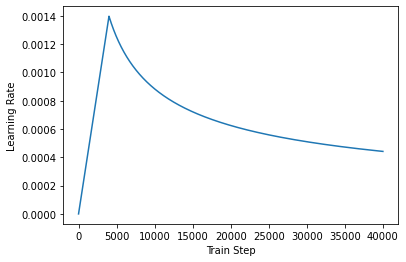

In [49]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

타겟 시퀀스에 padding이 있기 때문에 loss를 계산할때는 padding 부분을 제거해야 합니다.

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 
# from_logits=True: y_pred가 확률분포인 경우
# reduction='none': cross entropy loss를 각각 계산한 후 더하지 않음 (추후 padding 0에 해당하는 loss를 없애기 위해)

In [51]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask # padding 0에 해당하는 loss 제거
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [52]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 학습 및 모델 저장

In [53]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [54]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

checkpoint 경로와 checkpoint manager를 생성합니다. 매 `n` epoch 마다 모델이 저장됩니다.

In [55]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# max_to_keep: 저장되는 checkpoint 수
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


타겟은 tar_inp과 tar_real로 나누어집니다. tar_inp은 decoder의 입력값이고 `tar_real`은 tar_inp에서 오른쪽으로 한 칸 이동한 값입니다. Transformer의 출력값이 `tar_real`이 되도록 학습합니다. 즉 현재 단어가 주어졌을 때 바로 다음 단어를 예측하는 모델을 생성합니다.


예를 들면, `sentence` = "SOS A lion in the jungle is sleeping EOS" (SOS: start of sentence, start token, EOS: end of sentence, end token)

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

모델이 미래 단어를 보는 것을 막기 위해 `look-ahead mask`를 이용해 미래 단어를 가립니다.

In [56]:
EPOCHS = 10000

In [57]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

한국어가 입력 언어, 영어가 타겟 언어입니다.

In [58]:
%time
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> korean, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 24.8 µs
Epoch 1 Batch 0 Loss 3.2665 Accuracy 0.2603
Epoch 1 Batch 50 Loss 3.1243 Accuracy 0.2671
Epoch 1 Batch 100 Loss 3.1080 Accuracy 0.2689
Epoch 1 Batch 150 Loss 3.1099 Accuracy 0.2683
Epoch 1 Batch 200 Loss 3.0491 Accuracy 0.2758
Epoch 1 Batch 250 Loss 3.0045 Accuracy 0.2774
Epoch 1 Batch 300 Loss 2.9555 Accuracy 0.2789
Epoch 1 Batch 350 Loss 2.9112 Accuracy 0.2791
Epoch 1 Batch 400 Loss 2.8540 Accuracy 0.2796
Epoch 1 Batch 450 Loss 2.8139 Accuracy 0.2796
Epoch 1 Batch 500 Loss 2.7878 Accuracy 0.2797
Epoch 1 Batch 550 Loss 2.7775 Accuracy 0.2790
Epoch 1 Batch 600 Loss 2.7678 Accuracy 0.2787
Epoch 1 Batch 650 Loss 2.7653 Accuracy 0.2783
Epoch 1 Batch 700 Loss 2.7621 Accuracy 0.2781
Epoch 1 Batch 750 Loss 2.7590 Accuracy 0.2778
Epoch 1 Batch 800 Loss 2.7574 Accuracy 0.2778
Epoch 1 Batch 850 Loss 2.7541 Accuracy 0.2776
Epoch 1 Batch 900 Loss 2.7523 Accuracy 0.2775
Epoch 1 Loss 2.7497 Accuracy 0.2774
Time taken for 1 epoch: 106

Epoch 9 Batch 500 Loss 2.6466 Accuracy 0.2901
Epoch 9 Batch 550 Loss 2.6274 Accuracy 0.2902
Epoch 9 Batch 600 Loss 2.6182 Accuracy 0.2901
Epoch 9 Batch 650 Loss 2.6111 Accuracy 0.2900
Epoch 9 Batch 700 Loss 2.6070 Accuracy 0.2900
Epoch 9 Batch 750 Loss 2.6032 Accuracy 0.2899
Epoch 9 Batch 800 Loss 2.6000 Accuracy 0.2898
Epoch 9 Batch 850 Loss 2.5981 Accuracy 0.2895
Epoch 9 Batch 900 Loss 2.5971 Accuracy 0.2892
Epoch 9 Loss 2.5956 Accuracy 0.2891
Time taken for 1 epoch: 56.984437704086304 secs

Epoch 10 Batch 0 Loss 2.9778 Accuracy 0.2913
Epoch 10 Batch 50 Loss 2.9758 Accuracy 0.2790
Epoch 10 Batch 100 Loss 2.9654 Accuracy 0.2794
Epoch 10 Batch 150 Loss 2.9535 Accuracy 0.2805
Epoch 10 Batch 200 Loss 2.9054 Accuracy 0.2853
Epoch 10 Batch 250 Loss 2.8501 Accuracy 0.2883
Epoch 10 Batch 300 Loss 2.7952 Accuracy 0.2901
Epoch 10 Batch 350 Loss 2.7417 Accuracy 0.2909
Epoch 10 Batch 400 Loss 2.6929 Accuracy 0.2915
Epoch 10 Batch 450 Loss 2.6560 Accuracy 0.2916
Epoch 10 Batch 500 Loss 2.6289 Acc

Epoch 17 Batch 800 Loss 2.5018 Accuracy 0.2968
Epoch 17 Batch 850 Loss 2.4993 Accuracy 0.2969
Epoch 17 Batch 900 Loss 2.4975 Accuracy 0.2969
Epoch 17 Loss 2.4965 Accuracy 0.2969
Time taken for 1 epoch: 57.03884148597717 secs

Epoch 18 Batch 0 Loss 2.8600 Accuracy 0.2800
Epoch 18 Batch 50 Loss 2.8892 Accuracy 0.2856
Epoch 18 Batch 100 Loss 2.8757 Accuracy 0.2862
Epoch 18 Batch 150 Loss 2.8618 Accuracy 0.2886
Epoch 18 Batch 200 Loss 2.8144 Accuracy 0.2930
Epoch 18 Batch 250 Loss 2.7572 Accuracy 0.2968
Epoch 18 Batch 300 Loss 2.7028 Accuracy 0.2980
Epoch 18 Batch 350 Loss 2.6507 Accuracy 0.2985
Epoch 18 Batch 400 Loss 2.5962 Accuracy 0.2994
Epoch 18 Batch 450 Loss 2.5579 Accuracy 0.2998
Epoch 18 Batch 500 Loss 2.5283 Accuracy 0.3002
Epoch 18 Batch 550 Loss 2.5126 Accuracy 0.2996
Epoch 18 Batch 600 Loss 2.5039 Accuracy 0.2995
Epoch 18 Batch 650 Loss 2.4994 Accuracy 0.2991
Epoch 18 Batch 700 Loss 2.4937 Accuracy 0.2991
Epoch 18 Batch 750 Loss 2.4903 Accuracy 0.2988
Epoch 18 Batch 800 Loss 2

Epoch 26 Batch 50 Loss 2.8145 Accuracy 0.2912
Epoch 26 Batch 100 Loss 2.8056 Accuracy 0.2908
Epoch 26 Batch 150 Loss 2.7932 Accuracy 0.2936
Epoch 26 Batch 200 Loss 2.7420 Accuracy 0.2979
Epoch 26 Batch 250 Loss 2.6970 Accuracy 0.3000
Epoch 26 Batch 300 Loss 2.6478 Accuracy 0.3012
Epoch 26 Batch 350 Loss 2.5956 Accuracy 0.3024
Epoch 26 Batch 400 Loss 2.5426 Accuracy 0.3030
Epoch 26 Batch 450 Loss 2.4990 Accuracy 0.3038
Epoch 26 Batch 500 Loss 2.4737 Accuracy 0.3040
Epoch 26 Batch 550 Loss 2.4557 Accuracy 0.3041
Epoch 26 Batch 600 Loss 2.4442 Accuracy 0.3041
Epoch 26 Batch 650 Loss 2.4380 Accuracy 0.3040
Epoch 26 Batch 700 Loss 2.4331 Accuracy 0.3041
Epoch 26 Batch 750 Loss 2.4281 Accuracy 0.3038
Epoch 26 Batch 800 Loss 2.4232 Accuracy 0.3038
Epoch 26 Batch 850 Loss 2.4201 Accuracy 0.3039
Epoch 26 Batch 900 Loss 2.4171 Accuracy 0.3038
Epoch 26 Loss 2.4159 Accuracy 0.3037
Time taken for 1 epoch: 57.08407998085022 secs

Epoch 27 Batch 0 Loss 2.8067 Accuracy 0.3093
Epoch 27 Batch 50 Loss 2.

Epoch 34 Batch 450 Loss 2.4399 Accuracy 0.3089
Epoch 34 Batch 500 Loss 2.4125 Accuracy 0.3091
Epoch 34 Batch 550 Loss 2.3944 Accuracy 0.3091
Epoch 34 Batch 600 Loss 2.3850 Accuracy 0.3086
Epoch 34 Batch 650 Loss 2.3811 Accuracy 0.3086
Epoch 34 Batch 700 Loss 2.3755 Accuracy 0.3086
Epoch 34 Batch 750 Loss 2.3707 Accuracy 0.3086
Epoch 34 Batch 800 Loss 2.3675 Accuracy 0.3083
Epoch 34 Batch 850 Loss 2.3653 Accuracy 0.3082
Epoch 34 Batch 900 Loss 2.3646 Accuracy 0.3082
Epoch 34 Loss 2.3631 Accuracy 0.3080
Time taken for 1 epoch: 56.999160051345825 secs

Epoch 35 Batch 0 Loss 2.8442 Accuracy 0.2764
Epoch 35 Batch 50 Loss 2.7558 Accuracy 0.2941
Epoch 35 Batch 100 Loss 2.7446 Accuracy 0.2961
Epoch 35 Batch 150 Loss 2.7381 Accuracy 0.2976
Epoch 35 Batch 200 Loss 2.6930 Accuracy 0.3020
Epoch 35 Batch 250 Loss 2.6379 Accuracy 0.3048
Epoch 35 Batch 300 Loss 2.5841 Accuracy 0.3071
Epoch 35 Batch 350 Loss 2.5323 Accuracy 0.3081
Epoch 35 Batch 400 Loss 2.4821 Accuracy 0.3089
Epoch 35 Batch 450 Loss 

Epoch 42 Batch 750 Loss 2.3274 Accuracy 0.3118
Epoch 42 Batch 800 Loss 2.3252 Accuracy 0.3118
Epoch 42 Batch 850 Loss 2.3230 Accuracy 0.3118
Epoch 42 Batch 900 Loss 2.3200 Accuracy 0.3117
Epoch 42 Loss 2.3200 Accuracy 0.3115
Time taken for 1 epoch: 57.17781400680542 secs

Epoch 43 Batch 0 Loss 2.5225 Accuracy 0.3253
Epoch 43 Batch 50 Loss 2.7046 Accuracy 0.2965
Epoch 43 Batch 100 Loss 2.7009 Accuracy 0.2991
Epoch 43 Batch 150 Loss 2.6960 Accuracy 0.3016
Epoch 43 Batch 200 Loss 2.6436 Accuracy 0.3066
Epoch 43 Batch 250 Loss 2.5911 Accuracy 0.3100
Epoch 43 Batch 300 Loss 2.5343 Accuracy 0.3117
Epoch 43 Batch 350 Loss 2.4820 Accuracy 0.3124
Epoch 43 Batch 400 Loss 2.4326 Accuracy 0.3124
Epoch 43 Batch 450 Loss 2.3914 Accuracy 0.3129
Epoch 43 Batch 500 Loss 2.3663 Accuracy 0.3128
Epoch 43 Batch 550 Loss 2.3462 Accuracy 0.3128
Epoch 43 Batch 600 Loss 2.3361 Accuracy 0.3127
Epoch 43 Batch 650 Loss 2.3288 Accuracy 0.3126
Epoch 43 Batch 700 Loss 2.3264 Accuracy 0.3125
Epoch 43 Batch 750 Loss 2

Epoch 51 Batch 50 Loss 2.6722 Accuracy 0.2999
Epoch 51 Batch 100 Loss 2.6678 Accuracy 0.3024
Epoch 51 Batch 150 Loss 2.6621 Accuracy 0.3038
Epoch 51 Batch 200 Loss 2.6117 Accuracy 0.3094
Epoch 51 Batch 250 Loss 2.5557 Accuracy 0.3134
Epoch 51 Batch 300 Loss 2.5003 Accuracy 0.3149
Epoch 51 Batch 350 Loss 2.4491 Accuracy 0.3151
Epoch 51 Batch 400 Loss 2.4020 Accuracy 0.3150
Epoch 51 Batch 450 Loss 2.3576 Accuracy 0.3156
Epoch 51 Batch 500 Loss 2.3274 Accuracy 0.3167
Epoch 51 Batch 550 Loss 2.3112 Accuracy 0.3165
Epoch 51 Batch 600 Loss 2.3006 Accuracy 0.3164
Epoch 51 Batch 650 Loss 2.2934 Accuracy 0.3162
Epoch 51 Batch 700 Loss 2.2889 Accuracy 0.3164
Epoch 51 Batch 750 Loss 2.2857 Accuracy 0.3163
Epoch 51 Batch 800 Loss 2.2819 Accuracy 0.3160
Epoch 51 Batch 850 Loss 2.2802 Accuracy 0.3161
Epoch 51 Batch 900 Loss 2.2780 Accuracy 0.3159
Epoch 51 Loss 2.2788 Accuracy 0.3155
Time taken for 1 epoch: 57.198843240737915 secs

Epoch 52 Batch 0 Loss 2.7283 Accuracy 0.3109
Epoch 52 Batch 50 Loss 2

Epoch 59 Batch 400 Loss 2.3712 Accuracy 0.3179
Epoch 59 Batch 450 Loss 2.3301 Accuracy 0.3177
Epoch 59 Batch 500 Loss 2.3035 Accuracy 0.3178
Epoch 59 Batch 550 Loss 2.2858 Accuracy 0.3181
Epoch 59 Batch 600 Loss 2.2731 Accuracy 0.3183
Epoch 59 Batch 650 Loss 2.2660 Accuracy 0.3184
Epoch 59 Batch 700 Loss 2.2609 Accuracy 0.3181
Epoch 59 Batch 750 Loss 2.2561 Accuracy 0.3182
Epoch 59 Batch 800 Loss 2.2520 Accuracy 0.3182
Epoch 59 Batch 850 Loss 2.2507 Accuracy 0.3184
Epoch 59 Batch 900 Loss 2.2487 Accuracy 0.3182
Epoch 59 Loss 2.2477 Accuracy 0.3183
Time taken for 1 epoch: 57.04010009765625 secs

Epoch 60 Batch 0 Loss 2.5501 Accuracy 0.3145
Epoch 60 Batch 50 Loss 2.6316 Accuracy 0.3025
Epoch 60 Batch 100 Loss 2.6288 Accuracy 0.3058
Epoch 60 Batch 150 Loss 2.6280 Accuracy 0.3058
Epoch 60 Batch 200 Loss 2.5814 Accuracy 0.3107
Epoch 60 Batch 250 Loss 2.5222 Accuracy 0.3132
Epoch 60 Batch 300 Loss 2.4665 Accuracy 0.3145
Epoch 60 Batch 350 Loss 2.4159 Accuracy 0.3160
Epoch 60 Batch 400 Loss 2

Epoch 67 Batch 700 Loss 2.2357 Accuracy 0.3204
Epoch 67 Batch 750 Loss 2.2304 Accuracy 0.3205
Epoch 67 Batch 800 Loss 2.2267 Accuracy 0.3207
Epoch 67 Batch 850 Loss 2.2233 Accuracy 0.3204
Epoch 67 Batch 900 Loss 2.2219 Accuracy 0.3203
Epoch 67 Loss 2.2199 Accuracy 0.3201
Time taken for 1 epoch: 57.029839754104614 secs

Epoch 68 Batch 0 Loss 2.6343 Accuracy 0.3101
Epoch 68 Batch 50 Loss 2.6175 Accuracy 0.3039
Epoch 68 Batch 100 Loss 2.6091 Accuracy 0.3059
Epoch 68 Batch 150 Loss 2.6084 Accuracy 0.3075
Epoch 68 Batch 200 Loss 2.5516 Accuracy 0.3147
Epoch 68 Batch 250 Loss 2.5008 Accuracy 0.3174
Epoch 68 Batch 300 Loss 2.4488 Accuracy 0.3185
Epoch 68 Batch 350 Loss 2.4002 Accuracy 0.3190
Epoch 68 Batch 400 Loss 2.3483 Accuracy 0.3195
Epoch 68 Batch 450 Loss 2.3020 Accuracy 0.3202
Epoch 68 Batch 500 Loss 2.2731 Accuracy 0.3207
Epoch 68 Batch 550 Loss 2.2576 Accuracy 0.3209
Epoch 68 Batch 600 Loss 2.2455 Accuracy 0.3212
Epoch 68 Batch 650 Loss 2.2385 Accuracy 0.3211
Epoch 68 Batch 700 Loss 

Epoch 76 Batch 50 Loss 2.5972 Accuracy 0.3107
Epoch 76 Batch 100 Loss 2.5811 Accuracy 0.3101
Epoch 76 Batch 150 Loss 2.5778 Accuracy 0.3107
Epoch 76 Batch 200 Loss 2.5228 Accuracy 0.3163
Epoch 76 Batch 250 Loss 2.4722 Accuracy 0.3190
Epoch 76 Batch 300 Loss 2.4202 Accuracy 0.3204
Epoch 76 Batch 350 Loss 2.3682 Accuracy 0.3214
Epoch 76 Batch 400 Loss 2.3151 Accuracy 0.3219
Epoch 76 Batch 450 Loss 2.2728 Accuracy 0.3229
Epoch 76 Batch 500 Loss 2.2462 Accuracy 0.3228
Epoch 76 Batch 550 Loss 2.2279 Accuracy 0.3229
Epoch 76 Batch 600 Loss 2.2158 Accuracy 0.3232
Epoch 76 Batch 650 Loss 2.2083 Accuracy 0.3233
Epoch 76 Batch 700 Loss 2.2028 Accuracy 0.3234
Epoch 76 Batch 750 Loss 2.1982 Accuracy 0.3234
Epoch 76 Batch 800 Loss 2.1954 Accuracy 0.3233
Epoch 76 Batch 850 Loss 2.1953 Accuracy 0.3232
Epoch 76 Batch 900 Loss 2.1950 Accuracy 0.3229
Epoch 76 Loss 2.1941 Accuracy 0.3228
Time taken for 1 epoch: 57.02562642097473 secs

Epoch 77 Batch 0 Loss 2.5602 Accuracy 0.3149
Epoch 77 Batch 50 Loss 2.

Epoch 84 Batch 400 Loss 2.3018 Accuracy 0.3236
Epoch 84 Batch 450 Loss 2.2539 Accuracy 0.3240
Epoch 84 Batch 500 Loss 2.2264 Accuracy 0.3244
Epoch 84 Batch 550 Loss 2.2085 Accuracy 0.3245
Epoch 84 Batch 600 Loss 2.1980 Accuracy 0.3246
Epoch 84 Batch 650 Loss 2.1910 Accuracy 0.3249
Epoch 84 Batch 700 Loss 2.1857 Accuracy 0.3247
Epoch 84 Batch 750 Loss 2.1826 Accuracy 0.3247
Epoch 84 Batch 800 Loss 2.1782 Accuracy 0.3246
Epoch 84 Batch 850 Loss 2.1760 Accuracy 0.3244
Epoch 84 Batch 900 Loss 2.1733 Accuracy 0.3242
Epoch 84 Loss 2.1718 Accuracy 0.3242
Time taken for 1 epoch: 57.302189350128174 secs

Epoch 85 Batch 0 Loss 2.4933 Accuracy 0.3197
Epoch 85 Batch 50 Loss 2.5690 Accuracy 0.3090
Epoch 85 Batch 100 Loss 2.5608 Accuracy 0.3108
Epoch 85 Batch 150 Loss 2.5488 Accuracy 0.3127
Epoch 85 Batch 200 Loss 2.5066 Accuracy 0.3182
Epoch 85 Batch 250 Loss 2.4455 Accuracy 0.3218
Epoch 85 Batch 300 Loss 2.3936 Accuracy 0.3227
Epoch 85 Batch 350 Loss 2.3433 Accuracy 0.3233
Epoch 85 Batch 400 Loss 

Epoch 92 Batch 700 Loss 2.1678 Accuracy 0.3260
Epoch 92 Batch 750 Loss 2.1641 Accuracy 0.3259
Epoch 92 Batch 800 Loss 2.1598 Accuracy 0.3260
Epoch 92 Batch 850 Loss 2.1574 Accuracy 0.3259
Epoch 92 Batch 900 Loss 2.1551 Accuracy 0.3258
Epoch 92 Loss 2.1534 Accuracy 0.3259
Time taken for 1 epoch: 56.96101784706116 secs

Epoch 93 Batch 0 Loss 2.4837 Accuracy 0.3201
Epoch 93 Batch 50 Loss 2.5353 Accuracy 0.3134
Epoch 93 Batch 100 Loss 2.5403 Accuracy 0.3133
Epoch 93 Batch 150 Loss 2.5390 Accuracy 0.3140
Epoch 93 Batch 200 Loss 2.4921 Accuracy 0.3183
Epoch 93 Batch 250 Loss 2.4388 Accuracy 0.3217
Epoch 93 Batch 300 Loss 2.3832 Accuracy 0.3230
Epoch 93 Batch 350 Loss 2.3250 Accuracy 0.3241
Epoch 93 Batch 400 Loss 2.2737 Accuracy 0.3250
Epoch 93 Batch 450 Loss 2.2380 Accuracy 0.3247
Epoch 93 Batch 500 Loss 2.2089 Accuracy 0.3252
Epoch 93 Batch 550 Loss 2.1906 Accuracy 0.3255
Epoch 93 Batch 600 Loss 2.1811 Accuracy 0.3259
Epoch 93 Batch 650 Loss 2.1745 Accuracy 0.3261
Epoch 93 Batch 700 Loss 2

Epoch 101 Batch 50 Loss 2.5307 Accuracy 0.3121
Epoch 101 Batch 100 Loss 2.5190 Accuracy 0.3152
Epoch 101 Batch 150 Loss 2.5125 Accuracy 0.3158
Epoch 101 Batch 200 Loss 2.4687 Accuracy 0.3215
Epoch 101 Batch 250 Loss 2.4176 Accuracy 0.3242
Epoch 101 Batch 300 Loss 2.3621 Accuracy 0.3259
Epoch 101 Batch 350 Loss 2.3068 Accuracy 0.3274
Epoch 101 Batch 400 Loss 2.2584 Accuracy 0.3279
Epoch 101 Batch 450 Loss 2.2147 Accuracy 0.3279
Epoch 101 Batch 500 Loss 2.1915 Accuracy 0.3278
Epoch 101 Batch 550 Loss 2.1767 Accuracy 0.3276
Epoch 101 Batch 600 Loss 2.1637 Accuracy 0.3277
Epoch 101 Batch 650 Loss 2.1559 Accuracy 0.3278
Epoch 101 Batch 700 Loss 2.1504 Accuracy 0.3279
Epoch 101 Batch 750 Loss 2.1483 Accuracy 0.3277
Epoch 101 Batch 800 Loss 2.1445 Accuracy 0.3276
Epoch 101 Batch 850 Loss 2.1396 Accuracy 0.3278
Epoch 101 Batch 900 Loss 2.1373 Accuracy 0.3279
Epoch 101 Loss 2.1351 Accuracy 0.3280
Time taken for 1 epoch: 57.034528732299805 secs

Epoch 102 Batch 0 Loss 2.6142 Accuracy 0.3261
Epoc

Epoch 109 Batch 250 Loss 2.4004 Accuracy 0.3266
Epoch 109 Batch 300 Loss 2.3453 Accuracy 0.3274
Epoch 109 Batch 350 Loss 2.2914 Accuracy 0.3281
Epoch 109 Batch 400 Loss 2.2447 Accuracy 0.3283
Epoch 109 Batch 450 Loss 2.2006 Accuracy 0.3287
Epoch 109 Batch 500 Loss 2.1738 Accuracy 0.3292
Epoch 109 Batch 550 Loss 2.1568 Accuracy 0.3294
Epoch 109 Batch 600 Loss 2.1440 Accuracy 0.3295
Epoch 109 Batch 650 Loss 2.1344 Accuracy 0.3297
Epoch 109 Batch 700 Loss 2.1285 Accuracy 0.3297
Epoch 109 Batch 750 Loss 2.1254 Accuracy 0.3298
Epoch 109 Batch 800 Loss 2.1231 Accuracy 0.3294
Epoch 109 Batch 850 Loss 2.1204 Accuracy 0.3293
Epoch 109 Batch 900 Loss 2.1195 Accuracy 0.3290
Epoch 109 Loss 2.1168 Accuracy 0.3291
Time taken for 1 epoch: 56.88832187652588 secs

Epoch 110 Batch 0 Loss 2.4162 Accuracy 0.3385
Epoch 110 Batch 50 Loss 2.4924 Accuracy 0.3146
Epoch 110 Batch 100 Loss 2.5022 Accuracy 0.3159
Epoch 110 Batch 150 Loss 2.4959 Accuracy 0.3175
Epoch 110 Batch 200 Loss 2.4553 Accuracy 0.3214
Epoch

Epoch 117 Batch 400 Loss 2.2328 Accuracy 0.3288
Epoch 117 Batch 450 Loss 2.1891 Accuracy 0.3299
Epoch 117 Batch 500 Loss 2.1610 Accuracy 0.3303
Epoch 117 Batch 550 Loss 2.1431 Accuracy 0.3305
Epoch 117 Batch 600 Loss 2.1318 Accuracy 0.3307
Epoch 117 Batch 650 Loss 2.1249 Accuracy 0.3310
Epoch 117 Batch 700 Loss 2.1166 Accuracy 0.3312
Epoch 117 Batch 750 Loss 2.1115 Accuracy 0.3314
Epoch 117 Batch 800 Loss 2.1076 Accuracy 0.3313
Epoch 117 Batch 850 Loss 2.1051 Accuracy 0.3311
Epoch 117 Batch 900 Loss 2.1034 Accuracy 0.3310
Epoch 117 Loss 2.1029 Accuracy 0.3307
Time taken for 1 epoch: 57.09893441200256 secs

Epoch 118 Batch 0 Loss 2.5968 Accuracy 0.3067
Epoch 118 Batch 50 Loss 2.4874 Accuracy 0.3152
Epoch 118 Batch 100 Loss 2.4925 Accuracy 0.3158
Epoch 118 Batch 150 Loss 2.4871 Accuracy 0.3178
Epoch 118 Batch 200 Loss 2.4391 Accuracy 0.3232
Epoch 118 Batch 250 Loss 2.3881 Accuracy 0.3255
Epoch 118 Batch 300 Loss 2.3335 Accuracy 0.3273
Epoch 118 Batch 350 Loss 2.2788 Accuracy 0.3284
Epoch

Epoch 125 Batch 600 Loss 2.1160 Accuracy 0.3322
Epoch 125 Batch 650 Loss 2.1090 Accuracy 0.3325
Epoch 125 Batch 700 Loss 2.1024 Accuracy 0.3323
Epoch 125 Batch 750 Loss 2.0975 Accuracy 0.3322
Epoch 125 Batch 800 Loss 2.0938 Accuracy 0.3323
Epoch 125 Batch 850 Loss 2.0905 Accuracy 0.3323
Epoch 125 Batch 900 Loss 2.0890 Accuracy 0.3321
Saving checkpoint for epoch 125 at ./checkpoints/train/ckpt-29
Epoch 125 Loss 2.0887 Accuracy 0.3321
Time taken for 1 epoch: 57.19920611381531 secs

Epoch 126 Batch 0 Loss 2.5308 Accuracy 0.3169
Epoch 126 Batch 50 Loss 2.4734 Accuracy 0.3200
Epoch 126 Batch 100 Loss 2.4721 Accuracy 0.3205
Epoch 126 Batch 150 Loss 2.4661 Accuracy 0.3211
Epoch 126 Batch 200 Loss 2.4118 Accuracy 0.3264
Epoch 126 Batch 250 Loss 2.3641 Accuracy 0.3291
Epoch 126 Batch 300 Loss 2.3148 Accuracy 0.3306
Epoch 126 Batch 350 Loss 2.2638 Accuracy 0.3314
Epoch 126 Batch 400 Loss 2.2122 Accuracy 0.3319
Epoch 126 Batch 450 Loss 2.1690 Accuracy 0.3321
Epoch 126 Batch 500 Loss 2.1437 Accura

Epoch 133 Batch 750 Loss 2.0847 Accuracy 0.3332
Epoch 133 Batch 800 Loss 2.0805 Accuracy 0.3330
Epoch 133 Batch 850 Loss 2.0777 Accuracy 0.3330
Epoch 133 Batch 900 Loss 2.0759 Accuracy 0.3333
Epoch 133 Loss 2.0745 Accuracy 0.3333
Time taken for 1 epoch: 56.88610506057739 secs

Epoch 134 Batch 0 Loss 2.4388 Accuracy 0.3211
Epoch 134 Batch 50 Loss 2.4499 Accuracy 0.3198
Epoch 134 Batch 100 Loss 2.4604 Accuracy 0.3203
Epoch 134 Batch 150 Loss 2.4604 Accuracy 0.3206
Epoch 134 Batch 200 Loss 2.4124 Accuracy 0.3266
Epoch 134 Batch 250 Loss 2.3553 Accuracy 0.3296
Epoch 134 Batch 300 Loss 2.3026 Accuracy 0.3306
Epoch 134 Batch 350 Loss 2.2516 Accuracy 0.3314
Epoch 134 Batch 400 Loss 2.1981 Accuracy 0.3320
Epoch 134 Batch 450 Loss 2.1547 Accuracy 0.3330
Epoch 134 Batch 500 Loss 2.1283 Accuracy 0.3335
Epoch 134 Batch 550 Loss 2.1117 Accuracy 0.3334
Epoch 134 Batch 600 Loss 2.0998 Accuracy 0.3340
Epoch 134 Batch 650 Loss 2.0918 Accuracy 0.3342
Epoch 134 Batch 700 Loss 2.0849 Accuracy 0.3343
Epoch

Epoch 141 Batch 900 Loss 2.0642 Accuracy 0.3342
Epoch 141 Loss 2.0632 Accuracy 0.3342
Time taken for 1 epoch: 56.91849112510681 secs

Epoch 142 Batch 0 Loss 2.4572 Accuracy 0.3197
Epoch 142 Batch 50 Loss 2.4300 Accuracy 0.3238
Epoch 142 Batch 100 Loss 2.4319 Accuracy 0.3231
Epoch 142 Batch 150 Loss 2.4286 Accuracy 0.3246
Epoch 142 Batch 200 Loss 2.3854 Accuracy 0.3288
Epoch 142 Batch 250 Loss 2.3359 Accuracy 0.3309
Epoch 142 Batch 300 Loss 2.2846 Accuracy 0.3323
Epoch 142 Batch 350 Loss 2.2363 Accuracy 0.3327
Epoch 142 Batch 400 Loss 2.1813 Accuracy 0.3335
Epoch 142 Batch 450 Loss 2.1423 Accuracy 0.3331
Epoch 142 Batch 500 Loss 2.1134 Accuracy 0.3339
Epoch 142 Batch 550 Loss 2.0979 Accuracy 0.3337
Epoch 142 Batch 600 Loss 2.0864 Accuracy 0.3340
Epoch 142 Batch 650 Loss 2.0782 Accuracy 0.3344
Epoch 142 Batch 700 Loss 2.0733 Accuracy 0.3344
Epoch 142 Batch 750 Loss 2.0689 Accuracy 0.3347
Epoch 142 Batch 800 Loss 2.0663 Accuracy 0.3347
Epoch 142 Batch 850 Loss 2.0625 Accuracy 0.3348
Epoch

Epoch 150 Batch 50 Loss 2.4326 Accuracy 0.3214
Epoch 150 Batch 100 Loss 2.4321 Accuracy 0.3225
Epoch 150 Batch 150 Loss 2.4239 Accuracy 0.3243
Epoch 150 Batch 200 Loss 2.3807 Accuracy 0.3292
Epoch 150 Batch 250 Loss 2.3244 Accuracy 0.3325
Epoch 150 Batch 300 Loss 2.2723 Accuracy 0.3334
Epoch 150 Batch 350 Loss 2.2203 Accuracy 0.3338
Epoch 150 Batch 400 Loss 2.1728 Accuracy 0.3341
Epoch 150 Batch 450 Loss 2.1326 Accuracy 0.3344
Epoch 150 Batch 500 Loss 2.1023 Accuracy 0.3350
Epoch 150 Batch 550 Loss 2.0863 Accuracy 0.3355
Epoch 150 Batch 600 Loss 2.0749 Accuracy 0.3354
Epoch 150 Batch 650 Loss 2.0694 Accuracy 0.3355
Epoch 150 Batch 700 Loss 2.0634 Accuracy 0.3357
Epoch 150 Batch 750 Loss 2.0591 Accuracy 0.3358
Epoch 150 Batch 800 Loss 2.0554 Accuracy 0.3358
Epoch 150 Batch 850 Loss 2.0528 Accuracy 0.3358
Epoch 150 Batch 900 Loss 2.0513 Accuracy 0.3357
Saving checkpoint for epoch 150 at ./checkpoints/train/ckpt-34
Epoch 150 Loss 2.0488 Accuracy 0.3357
Time taken for 1 epoch: 57.138486623

Epoch 158 Batch 200 Loss 2.3723 Accuracy 0.3287
Epoch 158 Batch 250 Loss 2.3221 Accuracy 0.3321
Epoch 158 Batch 300 Loss 2.2677 Accuracy 0.3337
Epoch 158 Batch 350 Loss 2.2160 Accuracy 0.3343
Epoch 158 Batch 400 Loss 2.1615 Accuracy 0.3349
Epoch 158 Batch 450 Loss 2.1211 Accuracy 0.3353
Epoch 158 Batch 500 Loss 2.0954 Accuracy 0.3360
Epoch 158 Batch 550 Loss 2.0782 Accuracy 0.3363
Epoch 158 Batch 600 Loss 2.0657 Accuracy 0.3364
Epoch 158 Batch 650 Loss 2.0605 Accuracy 0.3364
Epoch 158 Batch 700 Loss 2.0548 Accuracy 0.3365
Epoch 158 Batch 750 Loss 2.0490 Accuracy 0.3366
Epoch 158 Batch 800 Loss 2.0458 Accuracy 0.3365
Epoch 158 Batch 850 Loss 2.0413 Accuracy 0.3365
Epoch 158 Batch 900 Loss 2.0391 Accuracy 0.3365
Epoch 158 Loss 2.0367 Accuracy 0.3365
Time taken for 1 epoch: 57.028351068496704 secs

Epoch 159 Batch 0 Loss 2.4330 Accuracy 0.2997
Epoch 159 Batch 50 Loss 2.4227 Accuracy 0.3209
Epoch 159 Batch 100 Loss 2.4175 Accuracy 0.3226
Epoch 159 Batch 150 Loss 2.4106 Accuracy 0.3252
Epoc

Epoch 166 Batch 350 Loss 2.2080 Accuracy 0.3347
Epoch 166 Batch 400 Loss 2.1551 Accuracy 0.3354
Epoch 166 Batch 450 Loss 2.1153 Accuracy 0.3362
Epoch 166 Batch 500 Loss 2.0857 Accuracy 0.3370
Epoch 166 Batch 550 Loss 2.0682 Accuracy 0.3368
Epoch 166 Batch 600 Loss 2.0570 Accuracy 0.3373
Epoch 166 Batch 650 Loss 2.0487 Accuracy 0.3377
Epoch 166 Batch 700 Loss 2.0425 Accuracy 0.3377
Epoch 166 Batch 750 Loss 2.0382 Accuracy 0.3377
Epoch 166 Batch 800 Loss 2.0338 Accuracy 0.3377
Epoch 166 Batch 850 Loss 2.0319 Accuracy 0.3374
Epoch 166 Batch 900 Loss 2.0280 Accuracy 0.3376
Epoch 166 Loss 2.0266 Accuracy 0.3376
Time taken for 1 epoch: 57.0700626373291 secs

Epoch 167 Batch 0 Loss 2.5296 Accuracy 0.3269
Epoch 167 Batch 50 Loss 2.4217 Accuracy 0.3208
Epoch 167 Batch 100 Loss 2.4182 Accuracy 0.3225
Epoch 167 Batch 150 Loss 2.4114 Accuracy 0.3242
Epoch 167 Batch 200 Loss 2.3631 Accuracy 0.3299
Epoch 167 Batch 250 Loss 2.3079 Accuracy 0.3331
Epoch 167 Batch 300 Loss 2.2579 Accuracy 0.3337
Epoch 

Epoch 174 Batch 550 Loss 2.0563 Accuracy 0.3373
Epoch 174 Batch 600 Loss 2.0456 Accuracy 0.3374
Epoch 174 Batch 650 Loss 2.0370 Accuracy 0.3376
Epoch 174 Batch 700 Loss 2.0316 Accuracy 0.3377
Epoch 174 Batch 750 Loss 2.0270 Accuracy 0.3379
Epoch 174 Batch 800 Loss 2.0237 Accuracy 0.3381
Epoch 174 Batch 850 Loss 2.0213 Accuracy 0.3382
Epoch 174 Batch 900 Loss 2.0187 Accuracy 0.3384
Epoch 174 Loss 2.0168 Accuracy 0.3385
Time taken for 1 epoch: 56.96463418006897 secs

Epoch 175 Batch 0 Loss 2.3749 Accuracy 0.3097
Epoch 175 Batch 50 Loss 2.3958 Accuracy 0.3252
Epoch 175 Batch 100 Loss 2.3934 Accuracy 0.3260
Epoch 175 Batch 150 Loss 2.3866 Accuracy 0.3285
Epoch 175 Batch 200 Loss 2.3485 Accuracy 0.3326
Epoch 175 Batch 250 Loss 2.2968 Accuracy 0.3353
Epoch 175 Batch 300 Loss 2.2438 Accuracy 0.3364
Epoch 175 Batch 350 Loss 2.1915 Accuracy 0.3369
Epoch 175 Batch 400 Loss 2.1407 Accuracy 0.3373
Epoch 175 Batch 450 Loss 2.0993 Accuracy 0.3378
Epoch 175 Batch 500 Loss 2.0713 Accuracy 0.3383
Epoch

Epoch 182 Batch 700 Loss 2.0211 Accuracy 0.3386
Epoch 182 Batch 750 Loss 2.0178 Accuracy 0.3387
Epoch 182 Batch 800 Loss 2.0140 Accuracy 0.3390
Epoch 182 Batch 850 Loss 2.0118 Accuracy 0.3391
Epoch 182 Batch 900 Loss 2.0090 Accuracy 0.3392
Epoch 182 Loss 2.0077 Accuracy 0.3393
Time taken for 1 epoch: 57.18243861198425 secs

Epoch 183 Batch 0 Loss 2.4110 Accuracy 0.3233
Epoch 183 Batch 50 Loss 2.3781 Accuracy 0.3275
Epoch 183 Batch 100 Loss 2.3815 Accuracy 0.3284
Epoch 183 Batch 150 Loss 2.3784 Accuracy 0.3297
Epoch 183 Batch 200 Loss 2.3406 Accuracy 0.3322
Epoch 183 Batch 250 Loss 2.2862 Accuracy 0.3354
Epoch 183 Batch 300 Loss 2.2330 Accuracy 0.3371
Epoch 183 Batch 350 Loss 2.1794 Accuracy 0.3374
Epoch 183 Batch 400 Loss 2.1307 Accuracy 0.3375
Epoch 183 Batch 450 Loss 2.0886 Accuracy 0.3382
Epoch 183 Batch 500 Loss 2.0608 Accuracy 0.3386
Epoch 183 Batch 550 Loss 2.0418 Accuracy 0.3392
Epoch 183 Batch 600 Loss 2.0297 Accuracy 0.3394
Epoch 183 Batch 650 Loss 2.0237 Accuracy 0.3396
Epoch

Epoch 190 Batch 900 Loss 1.9999 Accuracy 0.3404
Saving checkpoint for epoch 190 at ./checkpoints/train/ckpt-42
Epoch 190 Loss 1.9982 Accuracy 0.3403
Time taken for 1 epoch: 57.063973903656006 secs

Epoch 191 Batch 0 Loss 2.4177 Accuracy 0.3249
Epoch 191 Batch 50 Loss 2.3902 Accuracy 0.3233
Epoch 191 Batch 100 Loss 2.3796 Accuracy 0.3270
Epoch 191 Batch 150 Loss 2.3734 Accuracy 0.3281
Epoch 191 Batch 200 Loss 2.3238 Accuracy 0.3335
Epoch 191 Batch 250 Loss 2.2742 Accuracy 0.3358
Epoch 191 Batch 300 Loss 2.2232 Accuracy 0.3373
Epoch 191 Batch 350 Loss 2.1729 Accuracy 0.3379
Epoch 191 Batch 400 Loss 2.1216 Accuracy 0.3386
Epoch 191 Batch 450 Loss 2.0804 Accuracy 0.3388
Epoch 191 Batch 500 Loss 2.0531 Accuracy 0.3394
Epoch 191 Batch 550 Loss 2.0381 Accuracy 0.3395
Epoch 191 Batch 600 Loss 2.0292 Accuracy 0.3396
Epoch 191 Batch 650 Loss 2.0209 Accuracy 0.3397
Epoch 191 Batch 700 Loss 2.0147 Accuracy 0.3398
Epoch 191 Batch 750 Loss 2.0091 Accuracy 0.3400
Epoch 191 Batch 800 Loss 2.0043 Accur

Epoch 199 Batch 50 Loss 2.3683 Accuracy 0.3278
Epoch 199 Batch 100 Loss 2.3733 Accuracy 0.3285
Epoch 199 Batch 150 Loss 2.3617 Accuracy 0.3296
Epoch 199 Batch 200 Loss 2.3219 Accuracy 0.3345
Epoch 199 Batch 250 Loss 2.2661 Accuracy 0.3380
Epoch 199 Batch 300 Loss 2.2194 Accuracy 0.3380
Epoch 199 Batch 350 Loss 2.1650 Accuracy 0.3389
Epoch 199 Batch 400 Loss 2.1145 Accuracy 0.3391
Epoch 199 Batch 450 Loss 2.0748 Accuracy 0.3400
Epoch 199 Batch 500 Loss 2.0462 Accuracy 0.3400
Epoch 199 Batch 550 Loss 2.0305 Accuracy 0.3405
Epoch 199 Batch 600 Loss 2.0205 Accuracy 0.3406
Epoch 199 Batch 650 Loss 2.0127 Accuracy 0.3407
Epoch 199 Batch 700 Loss 2.0061 Accuracy 0.3409
Epoch 199 Batch 750 Loss 2.0023 Accuracy 0.3407
Epoch 199 Batch 800 Loss 1.9991 Accuracy 0.3408
Epoch 199 Batch 850 Loss 1.9947 Accuracy 0.3408
Epoch 199 Batch 900 Loss 1.9911 Accuracy 0.3410
Epoch 199 Loss 1.9891 Accuracy 0.3408
Time taken for 1 epoch: 57.09230065345764 secs

Epoch 200 Batch 0 Loss 2.3690 Accuracy 0.3347
Epoch

Epoch 207 Batch 200 Loss 2.3119 Accuracy 0.3340
Epoch 207 Batch 250 Loss 2.2648 Accuracy 0.3360
Epoch 207 Batch 300 Loss 2.2082 Accuracy 0.3386
Epoch 207 Batch 350 Loss 2.1540 Accuracy 0.3400
Epoch 207 Batch 400 Loss 2.1032 Accuracy 0.3402
Epoch 207 Batch 450 Loss 2.0638 Accuracy 0.3408
Epoch 207 Batch 500 Loss 2.0364 Accuracy 0.3417
Epoch 207 Batch 550 Loss 2.0184 Accuracy 0.3420
Epoch 207 Batch 600 Loss 2.0075 Accuracy 0.3417
Epoch 207 Batch 650 Loss 2.0001 Accuracy 0.3417
Epoch 207 Batch 700 Loss 1.9918 Accuracy 0.3419
Epoch 207 Batch 750 Loss 1.9878 Accuracy 0.3420
Epoch 207 Batch 800 Loss 1.9854 Accuracy 0.3419
Epoch 207 Batch 850 Loss 1.9824 Accuracy 0.3419
Epoch 207 Batch 900 Loss 1.9804 Accuracy 0.3420
Epoch 207 Loss 1.9794 Accuracy 0.3421
Time taken for 1 epoch: 57.148215532302856 secs

Epoch 208 Batch 0 Loss 2.4722 Accuracy 0.3281
Epoch 208 Batch 50 Loss 2.3410 Accuracy 0.3296
Epoch 208 Batch 100 Loss 2.3548 Accuracy 0.3300
Epoch 208 Batch 150 Loss 2.3507 Accuracy 0.3309
Epoc

Epoch 215 Batch 400 Loss 2.1010 Accuracy 0.3403
Epoch 215 Batch 450 Loss 2.0615 Accuracy 0.3402
Epoch 215 Batch 500 Loss 2.0328 Accuracy 0.3406
Epoch 215 Batch 550 Loss 2.0116 Accuracy 0.3416
Epoch 215 Batch 600 Loss 2.0000 Accuracy 0.3419
Epoch 215 Batch 650 Loss 1.9933 Accuracy 0.3421
Epoch 215 Batch 700 Loss 1.9883 Accuracy 0.3422
Epoch 215 Batch 750 Loss 1.9853 Accuracy 0.3421
Epoch 215 Batch 800 Loss 1.9806 Accuracy 0.3422
Epoch 215 Batch 850 Loss 1.9787 Accuracy 0.3422
Epoch 215 Batch 900 Loss 1.9764 Accuracy 0.3422
Saving checkpoint for epoch 215 at ./checkpoints/train/ckpt-47
Epoch 215 Loss 1.9751 Accuracy 0.3421
Time taken for 1 epoch: 57.42332696914673 secs

Epoch 216 Batch 0 Loss 2.4002 Accuracy 0.3025
Epoch 216 Batch 50 Loss 2.3488 Accuracy 0.3300
Epoch 216 Batch 100 Loss 2.3429 Accuracy 0.3301
Epoch 216 Batch 150 Loss 2.3378 Accuracy 0.3328
Epoch 216 Batch 200 Loss 2.3016 Accuracy 0.3359
Epoch 216 Batch 250 Loss 2.2482 Accuracy 0.3378
Epoch 216 Batch 300 Loss 2.1938 Accura

Epoch 223 Batch 550 Loss 2.0034 Accuracy 0.3432
Epoch 223 Batch 600 Loss 1.9901 Accuracy 0.3431
Epoch 223 Batch 650 Loss 1.9832 Accuracy 0.3432
Epoch 223 Batch 700 Loss 1.9786 Accuracy 0.3431
Epoch 223 Batch 750 Loss 1.9743 Accuracy 0.3432
Epoch 223 Batch 800 Loss 1.9732 Accuracy 0.3431
Epoch 223 Batch 850 Loss 1.9697 Accuracy 0.3431
Epoch 223 Batch 900 Loss 1.9669 Accuracy 0.3431
Epoch 223 Loss 1.9650 Accuracy 0.3432
Time taken for 1 epoch: 57.12212681770325 secs

Epoch 224 Batch 0 Loss 2.2720 Accuracy 0.3413
Epoch 224 Batch 50 Loss 2.3410 Accuracy 0.3303
Epoch 224 Batch 100 Loss 2.3498 Accuracy 0.3307
Epoch 224 Batch 150 Loss 2.3471 Accuracy 0.3317
Epoch 224 Batch 200 Loss 2.3013 Accuracy 0.3358
Epoch 224 Batch 250 Loss 2.2499 Accuracy 0.3375
Epoch 224 Batch 300 Loss 2.2041 Accuracy 0.3388
Epoch 224 Batch 350 Loss 2.1478 Accuracy 0.3401
Epoch 224 Batch 400 Loss 2.0982 Accuracy 0.3403
Epoch 224 Batch 450 Loss 2.0557 Accuracy 0.3408
Epoch 224 Batch 500 Loss 2.0268 Accuracy 0.3419
Epoch

Epoch 231 Batch 700 Loss 1.9782 Accuracy 0.3433
Epoch 231 Batch 750 Loss 1.9735 Accuracy 0.3431
Epoch 231 Batch 800 Loss 1.9704 Accuracy 0.3434
Epoch 231 Batch 850 Loss 1.9647 Accuracy 0.3435
Epoch 231 Batch 900 Loss 1.9617 Accuracy 0.3437
Epoch 231 Loss 1.9590 Accuracy 0.3437
Time taken for 1 epoch: 56.9848792552948 secs

Epoch 232 Batch 0 Loss 2.2327 Accuracy 0.3433
Epoch 232 Batch 50 Loss 2.3376 Accuracy 0.3316
Epoch 232 Batch 100 Loss 2.3381 Accuracy 0.3328
Epoch 232 Batch 150 Loss 2.3360 Accuracy 0.3324
Epoch 232 Batch 200 Loss 2.2865 Accuracy 0.3372
Epoch 232 Batch 250 Loss 2.2366 Accuracy 0.3392
Epoch 232 Batch 300 Loss 2.1832 Accuracy 0.3411
Epoch 232 Batch 350 Loss 2.1346 Accuracy 0.3419
Epoch 232 Batch 400 Loss 2.0858 Accuracy 0.3420
Epoch 232 Batch 450 Loss 2.0441 Accuracy 0.3424
Epoch 232 Batch 500 Loss 2.0192 Accuracy 0.3429
Epoch 232 Batch 550 Loss 2.0016 Accuracy 0.3428
Epoch 232 Batch 600 Loss 1.9891 Accuracy 0.3430
Epoch 232 Batch 650 Loss 1.9824 Accuracy 0.3432
Epoch 

Epoch 239 Batch 900 Loss 1.9512 Accuracy 0.3447
Epoch 239 Loss 1.9501 Accuracy 0.3448
Time taken for 1 epoch: 56.859734296798706 secs

Epoch 240 Batch 0 Loss 2.3621 Accuracy 0.3355
Epoch 240 Batch 50 Loss 2.3271 Accuracy 0.3290
Epoch 240 Batch 100 Loss 2.3297 Accuracy 0.3309
Epoch 240 Batch 150 Loss 2.3273 Accuracy 0.3326
Epoch 240 Batch 200 Loss 2.2739 Accuracy 0.3388
Epoch 240 Batch 250 Loss 2.2206 Accuracy 0.3422
Epoch 240 Batch 300 Loss 2.1700 Accuracy 0.3436
Epoch 240 Batch 350 Loss 2.1220 Accuracy 0.3437
Epoch 240 Batch 400 Loss 2.0723 Accuracy 0.3439
Epoch 240 Batch 450 Loss 2.0307 Accuracy 0.3440
Epoch 240 Batch 500 Loss 2.0044 Accuracy 0.3447
Epoch 240 Batch 550 Loss 1.9861 Accuracy 0.3450
Epoch 240 Batch 600 Loss 1.9775 Accuracy 0.3448
Epoch 240 Batch 650 Loss 1.9707 Accuracy 0.3448
Epoch 240 Batch 700 Loss 1.9656 Accuracy 0.3446
Epoch 240 Batch 750 Loss 1.9615 Accuracy 0.3446
Epoch 240 Batch 800 Loss 1.9572 Accuracy 0.3445
Epoch 240 Batch 850 Loss 1.9536 Accuracy 0.3447
Epoc

Epoch 248 Batch 50 Loss 2.3380 Accuracy 0.3299
Epoch 248 Batch 100 Loss 2.3288 Accuracy 0.3313
Epoch 248 Batch 150 Loss 2.3281 Accuracy 0.3324
Epoch 248 Batch 200 Loss 2.2833 Accuracy 0.3359
Epoch 248 Batch 250 Loss 2.2283 Accuracy 0.3391
Epoch 248 Batch 300 Loss 2.1717 Accuracy 0.3418
Epoch 248 Batch 350 Loss 2.1221 Accuracy 0.3426
Epoch 248 Batch 400 Loss 2.0754 Accuracy 0.3426
Epoch 248 Batch 450 Loss 2.0309 Accuracy 0.3434
Epoch 248 Batch 500 Loss 2.0053 Accuracy 0.3438
Epoch 248 Batch 550 Loss 1.9855 Accuracy 0.3440
Epoch 248 Batch 600 Loss 1.9740 Accuracy 0.3444
Epoch 248 Batch 650 Loss 1.9659 Accuracy 0.3445
Epoch 248 Batch 700 Loss 1.9591 Accuracy 0.3450
Epoch 248 Batch 750 Loss 1.9557 Accuracy 0.3451
Epoch 248 Batch 800 Loss 1.9518 Accuracy 0.3452
Epoch 248 Batch 850 Loss 1.9481 Accuracy 0.3452
Epoch 248 Batch 900 Loss 1.9463 Accuracy 0.3453
Epoch 248 Loss 1.9443 Accuracy 0.3452
Time taken for 1 epoch: 56.83166193962097 secs

Epoch 249 Batch 0 Loss 2.3035 Accuracy 0.3470
Epoch

Epoch 256 Batch 200 Loss 2.2673 Accuracy 0.3395
Epoch 256 Batch 250 Loss 2.2235 Accuracy 0.3409
Epoch 256 Batch 300 Loss 2.1727 Accuracy 0.3427
Epoch 256 Batch 350 Loss 2.1207 Accuracy 0.3434
Epoch 256 Batch 400 Loss 2.0695 Accuracy 0.3439
Epoch 256 Batch 450 Loss 2.0261 Accuracy 0.3440
Epoch 256 Batch 500 Loss 1.9992 Accuracy 0.3444
Epoch 256 Batch 550 Loss 1.9798 Accuracy 0.3443
Epoch 256 Batch 600 Loss 1.9686 Accuracy 0.3445
Epoch 256 Batch 650 Loss 1.9600 Accuracy 0.3450
Epoch 256 Batch 700 Loss 1.9544 Accuracy 0.3454
Epoch 256 Batch 750 Loss 1.9507 Accuracy 0.3454
Epoch 256 Batch 800 Loss 1.9466 Accuracy 0.3457
Epoch 256 Batch 850 Loss 1.9448 Accuracy 0.3456
Epoch 256 Batch 900 Loss 1.9412 Accuracy 0.3456
Epoch 256 Loss 1.9378 Accuracy 0.3458
Time taken for 1 epoch: 56.88245868682861 secs

Epoch 257 Batch 0 Loss 2.2703 Accuracy 0.3245
Epoch 257 Batch 50 Loss 2.3030 Accuracy 0.3345
Epoch 257 Batch 100 Loss 2.3152 Accuracy 0.3346
Epoch 257 Batch 150 Loss 2.3100 Accuracy 0.3346
Epoch

Epoch 264 Batch 400 Loss 2.0563 Accuracy 0.3445
Epoch 264 Batch 450 Loss 2.0159 Accuracy 0.3450
Epoch 264 Batch 500 Loss 1.9875 Accuracy 0.3453
Epoch 264 Batch 550 Loss 1.9683 Accuracy 0.3454
Epoch 264 Batch 600 Loss 1.9571 Accuracy 0.3453
Epoch 264 Batch 650 Loss 1.9510 Accuracy 0.3458
Epoch 264 Batch 700 Loss 1.9464 Accuracy 0.3460
Epoch 264 Batch 750 Loss 1.9403 Accuracy 0.3462
Epoch 264 Batch 800 Loss 1.9380 Accuracy 0.3460
Epoch 264 Batch 850 Loss 1.9349 Accuracy 0.3463
Epoch 264 Batch 900 Loss 1.9335 Accuracy 0.3463
Epoch 264 Loss 1.9326 Accuracy 0.3463
Time taken for 1 epoch: 56.92802119255066 secs

Epoch 265 Batch 0 Loss 2.4390 Accuracy 0.3153
Epoch 265 Batch 50 Loss 2.3111 Accuracy 0.3344
Epoch 265 Batch 100 Loss 2.3108 Accuracy 0.3328
Epoch 265 Batch 150 Loss 2.3050 Accuracy 0.3346
Epoch 265 Batch 200 Loss 2.2571 Accuracy 0.3405
Epoch 265 Batch 250 Loss 2.2138 Accuracy 0.3423
Epoch 265 Batch 300 Loss 2.1634 Accuracy 0.3435
Epoch 265 Batch 350 Loss 2.1103 Accuracy 0.3439
Epoch

Epoch 272 Batch 550 Loss 1.9640 Accuracy 0.3458
Epoch 272 Batch 600 Loss 1.9540 Accuracy 0.3455
Epoch 272 Batch 650 Loss 1.9460 Accuracy 0.3458
Epoch 272 Batch 700 Loss 1.9420 Accuracy 0.3460
Epoch 272 Batch 750 Loss 1.9375 Accuracy 0.3461
Epoch 272 Batch 800 Loss 1.9323 Accuracy 0.3463
Epoch 272 Batch 850 Loss 1.9295 Accuracy 0.3465
Epoch 272 Batch 900 Loss 1.9259 Accuracy 0.3465
Epoch 272 Loss 1.9243 Accuracy 0.3465
Time taken for 1 epoch: 56.987590074539185 secs

Epoch 273 Batch 0 Loss 2.2843 Accuracy 0.3289
Epoch 273 Batch 50 Loss 2.3008 Accuracy 0.3311
Epoch 273 Batch 100 Loss 2.3075 Accuracy 0.3319
Epoch 273 Batch 150 Loss 2.3012 Accuracy 0.3343
Epoch 273 Batch 200 Loss 2.2589 Accuracy 0.3390
Epoch 273 Batch 250 Loss 2.2080 Accuracy 0.3421
Epoch 273 Batch 300 Loss 2.1557 Accuracy 0.3443
Epoch 273 Batch 350 Loss 2.1033 Accuracy 0.3453
Epoch 273 Batch 400 Loss 2.0514 Accuracy 0.3455
Epoch 273 Batch 450 Loss 2.0106 Accuracy 0.3461
Epoch 273 Batch 500 Loss 1.9814 Accuracy 0.3464
Epoc

Epoch 280 Batch 750 Loss 1.9316 Accuracy 0.3475
Epoch 280 Batch 800 Loss 1.9275 Accuracy 0.3476
Epoch 280 Batch 850 Loss 1.9226 Accuracy 0.3476
Epoch 280 Batch 900 Loss 1.9201 Accuracy 0.3477
Saving checkpoint for epoch 280 at ./checkpoints/train/ckpt-60
Epoch 280 Loss 1.9194 Accuracy 0.3474
Time taken for 1 epoch: 57.18490219116211 secs

Epoch 281 Batch 0 Loss 2.3232 Accuracy 0.3325
Epoch 281 Batch 50 Loss 2.3098 Accuracy 0.3341
Epoch 281 Batch 100 Loss 2.3022 Accuracy 0.3343
Epoch 281 Batch 150 Loss 2.2964 Accuracy 0.3357
Epoch 281 Batch 200 Loss 2.2545 Accuracy 0.3391
Epoch 281 Batch 250 Loss 2.2051 Accuracy 0.3411
Epoch 281 Batch 300 Loss 2.1527 Accuracy 0.3432
Epoch 281 Batch 350 Loss 2.1027 Accuracy 0.3439
Epoch 281 Batch 400 Loss 2.0523 Accuracy 0.3447
Epoch 281 Batch 450 Loss 2.0114 Accuracy 0.3449
Epoch 281 Batch 500 Loss 1.9863 Accuracy 0.3453
Epoch 281 Batch 550 Loss 1.9660 Accuracy 0.3457
Epoch 281 Batch 600 Loss 1.9547 Accuracy 0.3460
Epoch 281 Batch 650 Loss 1.9469 Accura

Epoch 288 Batch 900 Loss 1.9164 Accuracy 0.3476
Epoch 288 Loss 1.9151 Accuracy 0.3477
Time taken for 1 epoch: 57.05458068847656 secs

Epoch 289 Batch 0 Loss 2.4015 Accuracy 0.3277
Epoch 289 Batch 50 Loss 2.2838 Accuracy 0.3349
Epoch 289 Batch 100 Loss 2.2866 Accuracy 0.3365
Epoch 289 Batch 150 Loss 2.2820 Accuracy 0.3378
Epoch 289 Batch 200 Loss 2.2432 Accuracy 0.3417
Epoch 289 Batch 250 Loss 2.1980 Accuracy 0.3431
Epoch 289 Batch 300 Loss 2.1472 Accuracy 0.3448
Epoch 289 Batch 350 Loss 2.0950 Accuracy 0.3464
Epoch 289 Batch 400 Loss 2.0435 Accuracy 0.3470
Epoch 289 Batch 450 Loss 2.0019 Accuracy 0.3474
Epoch 289 Batch 500 Loss 1.9734 Accuracy 0.3477
Epoch 289 Batch 550 Loss 1.9541 Accuracy 0.3482
Epoch 289 Batch 600 Loss 1.9424 Accuracy 0.3482
Epoch 289 Batch 650 Loss 1.9339 Accuracy 0.3485
Epoch 289 Batch 700 Loss 1.9295 Accuracy 0.3484
Epoch 289 Batch 750 Loss 1.9260 Accuracy 0.3485
Epoch 289 Batch 800 Loss 1.9208 Accuracy 0.3485
Epoch 289 Batch 850 Loss 1.9177 Accuracy 0.3481
Epoch

Epoch 297 Batch 50 Loss 2.2799 Accuracy 0.3340
Epoch 297 Batch 100 Loss 2.2836 Accuracy 0.3330
Epoch 297 Batch 150 Loss 2.2825 Accuracy 0.3350
Epoch 297 Batch 200 Loss 2.2389 Accuracy 0.3411
Epoch 297 Batch 250 Loss 2.1868 Accuracy 0.3444
Epoch 297 Batch 300 Loss 2.1364 Accuracy 0.3459
Epoch 297 Batch 350 Loss 2.0824 Accuracy 0.3463
Epoch 297 Batch 400 Loss 2.0367 Accuracy 0.3460
Epoch 297 Batch 450 Loss 1.9952 Accuracy 0.3461
Epoch 297 Batch 500 Loss 1.9687 Accuracy 0.3470
Epoch 297 Batch 550 Loss 1.9508 Accuracy 0.3474
Epoch 297 Batch 600 Loss 1.9403 Accuracy 0.3473
Epoch 297 Batch 650 Loss 1.9311 Accuracy 0.3477
Epoch 297 Batch 700 Loss 1.9248 Accuracy 0.3479
Epoch 297 Batch 750 Loss 1.9221 Accuracy 0.3476
Epoch 297 Batch 800 Loss 1.9187 Accuracy 0.3477
Epoch 297 Batch 850 Loss 1.9149 Accuracy 0.3483
Epoch 297 Batch 900 Loss 1.9114 Accuracy 0.3483
Epoch 297 Loss 1.9095 Accuracy 0.3484
Time taken for 1 epoch: 56.86675763130188 secs

Epoch 298 Batch 0 Loss 2.3409 Accuracy 0.3290
Epoch

Epoch 305 Batch 250 Loss 2.1802 Accuracy 0.3462
Epoch 305 Batch 300 Loss 2.1289 Accuracy 0.3470
Epoch 305 Batch 350 Loss 2.0813 Accuracy 0.3474
Epoch 305 Batch 400 Loss 2.0347 Accuracy 0.3470
Epoch 305 Batch 450 Loss 1.9946 Accuracy 0.3473
Epoch 305 Batch 500 Loss 1.9687 Accuracy 0.3477
Epoch 305 Batch 550 Loss 1.9506 Accuracy 0.3481
Epoch 305 Batch 600 Loss 1.9386 Accuracy 0.3484
Epoch 305 Batch 650 Loss 1.9314 Accuracy 0.3487
Epoch 305 Batch 700 Loss 1.9259 Accuracy 0.3484
Epoch 305 Batch 750 Loss 1.9193 Accuracy 0.3486
Epoch 305 Batch 800 Loss 1.9146 Accuracy 0.3487
Epoch 305 Batch 850 Loss 1.9115 Accuracy 0.3486
Epoch 305 Batch 900 Loss 1.9093 Accuracy 0.3487
Saving checkpoint for epoch 305 at ./checkpoints/train/ckpt-65
Epoch 305 Loss 1.9064 Accuracy 0.3488
Time taken for 1 epoch: 57.40292692184448 secs

Epoch 306 Batch 0 Loss 2.3817 Accuracy 0.3261
Epoch 306 Batch 50 Loss 2.2858 Accuracy 0.3344
Epoch 306 Batch 100 Loss 2.2869 Accuracy 0.3349
Epoch 306 Batch 150 Loss 2.2864 Accura

Epoch 313 Batch 400 Loss 2.0289 Accuracy 0.3468
Epoch 313 Batch 450 Loss 1.9893 Accuracy 0.3471
Epoch 313 Batch 500 Loss 1.9632 Accuracy 0.3476
Epoch 313 Batch 550 Loss 1.9448 Accuracy 0.3479
Epoch 313 Batch 600 Loss 1.9316 Accuracy 0.3485
Epoch 313 Batch 650 Loss 1.9244 Accuracy 0.3487
Epoch 313 Batch 700 Loss 1.9180 Accuracy 0.3487
Epoch 313 Batch 750 Loss 1.9121 Accuracy 0.3489
Epoch 313 Batch 800 Loss 1.9083 Accuracy 0.3491
Epoch 313 Batch 850 Loss 1.9058 Accuracy 0.3492
Epoch 313 Batch 900 Loss 1.9033 Accuracy 0.3492
Epoch 313 Loss 1.9010 Accuracy 0.3493
Time taken for 1 epoch: 57.10080122947693 secs

Epoch 314 Batch 0 Loss 2.2393 Accuracy 0.3526
Epoch 314 Batch 50 Loss 2.2738 Accuracy 0.3366
Epoch 314 Batch 100 Loss 2.2767 Accuracy 0.3364
Epoch 314 Batch 150 Loss 2.2707 Accuracy 0.3367
Epoch 314 Batch 200 Loss 2.2234 Accuracy 0.3416
Epoch 314 Batch 250 Loss 2.1762 Accuracy 0.3443
Epoch 314 Batch 300 Loss 2.1243 Accuracy 0.3457
Epoch 314 Batch 350 Loss 2.0722 Accuracy 0.3473
Epoch

Epoch 321 Batch 550 Loss 1.9374 Accuracy 0.3497
Epoch 321 Batch 600 Loss 1.9262 Accuracy 0.3495
Epoch 321 Batch 650 Loss 1.9177 Accuracy 0.3496
Epoch 321 Batch 700 Loss 1.9111 Accuracy 0.3495
Epoch 321 Batch 750 Loss 1.9063 Accuracy 0.3497
Epoch 321 Batch 800 Loss 1.9022 Accuracy 0.3497
Epoch 321 Batch 850 Loss 1.8989 Accuracy 0.3498
Epoch 321 Batch 900 Loss 1.8963 Accuracy 0.3498
Epoch 321 Loss 1.8951 Accuracy 0.3500
Time taken for 1 epoch: 56.908262491226196 secs

Epoch 322 Batch 0 Loss 2.2068 Accuracy 0.3373
Epoch 322 Batch 50 Loss 2.2739 Accuracy 0.3356
Epoch 322 Batch 100 Loss 2.2761 Accuracy 0.3364
Epoch 322 Batch 150 Loss 2.2683 Accuracy 0.3369
Epoch 322 Batch 200 Loss 2.2216 Accuracy 0.3432
Epoch 322 Batch 250 Loss 2.1676 Accuracy 0.3462
Epoch 322 Batch 300 Loss 2.1141 Accuracy 0.3480
Epoch 322 Batch 350 Loss 2.0644 Accuracy 0.3484
Epoch 322 Batch 400 Loss 2.0146 Accuracy 0.3488
Epoch 322 Batch 450 Loss 1.9749 Accuracy 0.3489
Epoch 322 Batch 500 Loss 1.9506 Accuracy 0.3487
Epoc

Epoch 329 Batch 750 Loss 1.9012 Accuracy 0.3506
Epoch 329 Batch 800 Loss 1.8976 Accuracy 0.3505
Epoch 329 Batch 850 Loss 1.8952 Accuracy 0.3502
Epoch 329 Batch 900 Loss 1.8927 Accuracy 0.3502
Epoch 329 Loss 1.8904 Accuracy 0.3502
Time taken for 1 epoch: 56.8322970867157 secs

Epoch 330 Batch 0 Loss 2.2712 Accuracy 0.3233
Epoch 330 Batch 50 Loss 2.2662 Accuracy 0.3361
Epoch 330 Batch 100 Loss 2.2623 Accuracy 0.3374
Epoch 330 Batch 150 Loss 2.2592 Accuracy 0.3386
Epoch 330 Batch 200 Loss 2.2152 Accuracy 0.3438
Epoch 330 Batch 250 Loss 2.1701 Accuracy 0.3461
Epoch 330 Batch 300 Loss 2.1205 Accuracy 0.3471
Epoch 330 Batch 350 Loss 2.0699 Accuracy 0.3476
Epoch 330 Batch 400 Loss 2.0179 Accuracy 0.3483
Epoch 330 Batch 450 Loss 1.9784 Accuracy 0.3489
Epoch 330 Batch 500 Loss 1.9500 Accuracy 0.3494
Epoch 330 Batch 550 Loss 1.9299 Accuracy 0.3498
Epoch 330 Batch 600 Loss 1.9197 Accuracy 0.3499
Epoch 330 Batch 650 Loss 1.9127 Accuracy 0.3500
Epoch 330 Batch 700 Loss 1.9069 Accuracy 0.3500
Epoch 

Epoch 337 Batch 900 Loss 1.8911 Accuracy 0.3500
Epoch 337 Loss 1.8873 Accuracy 0.3501
Time taken for 1 epoch: 56.736414670944214 secs

Epoch 338 Batch 0 Loss 2.2621 Accuracy 0.3301
Epoch 338 Batch 50 Loss 2.2639 Accuracy 0.3378
Epoch 338 Batch 100 Loss 2.2728 Accuracy 0.3357
Epoch 338 Batch 150 Loss 2.2541 Accuracy 0.3385
Epoch 338 Batch 200 Loss 2.2163 Accuracy 0.3429
Epoch 338 Batch 250 Loss 2.1661 Accuracy 0.3466
Epoch 338 Batch 300 Loss 2.1142 Accuracy 0.3476
Epoch 338 Batch 350 Loss 2.0616 Accuracy 0.3490
Epoch 338 Batch 400 Loss 2.0128 Accuracy 0.3492
Epoch 338 Batch 450 Loss 1.9706 Accuracy 0.3493
Epoch 338 Batch 500 Loss 1.9422 Accuracy 0.3506
Epoch 338 Batch 550 Loss 1.9238 Accuracy 0.3503
Epoch 338 Batch 600 Loss 1.9141 Accuracy 0.3503
Epoch 338 Batch 650 Loss 1.9072 Accuracy 0.3505
Epoch 338 Batch 700 Loss 1.9015 Accuracy 0.3508
Epoch 338 Batch 750 Loss 1.8978 Accuracy 0.3505
Epoch 338 Batch 800 Loss 1.8938 Accuracy 0.3504
Epoch 338 Batch 850 Loss 1.8898 Accuracy 0.3506
Epoc

Epoch 346 Batch 50 Loss 2.2370 Accuracy 0.3353
Epoch 346 Batch 100 Loss 2.2459 Accuracy 0.3390
Epoch 346 Batch 150 Loss 2.2429 Accuracy 0.3397
Epoch 346 Batch 200 Loss 2.2013 Accuracy 0.3446
Epoch 346 Batch 250 Loss 2.1531 Accuracy 0.3474
Epoch 346 Batch 300 Loss 2.1000 Accuracy 0.3483
Epoch 346 Batch 350 Loss 2.0515 Accuracy 0.3490
Epoch 346 Batch 400 Loss 2.0045 Accuracy 0.3491
Epoch 346 Batch 450 Loss 1.9633 Accuracy 0.3496
Epoch 346 Batch 500 Loss 1.9367 Accuracy 0.3500
Epoch 346 Batch 550 Loss 1.9194 Accuracy 0.3498
Epoch 346 Batch 600 Loss 1.9080 Accuracy 0.3502
Epoch 346 Batch 650 Loss 1.9005 Accuracy 0.3507
Epoch 346 Batch 700 Loss 1.8944 Accuracy 0.3508
Epoch 346 Batch 750 Loss 1.8903 Accuracy 0.3511
Epoch 346 Batch 800 Loss 1.8864 Accuracy 0.3513
Epoch 346 Batch 850 Loss 1.8842 Accuracy 0.3513
Epoch 346 Batch 900 Loss 1.8828 Accuracy 0.3510
Epoch 346 Loss 1.8806 Accuracy 0.3511
Time taken for 1 epoch: 56.886443853378296 secs

Epoch 347 Batch 0 Loss 2.1665 Accuracy 0.3345
Epoc

Epoch 354 Batch 250 Loss 2.1545 Accuracy 0.3478
Epoch 354 Batch 300 Loss 2.1027 Accuracy 0.3488
Epoch 354 Batch 350 Loss 2.0560 Accuracy 0.3491
Epoch 354 Batch 400 Loss 2.0035 Accuracy 0.3492
Epoch 354 Batch 450 Loss 1.9569 Accuracy 0.3504
Epoch 354 Batch 500 Loss 1.9311 Accuracy 0.3505
Epoch 354 Batch 550 Loss 1.9138 Accuracy 0.3508
Epoch 354 Batch 600 Loss 1.9030 Accuracy 0.3512
Epoch 354 Batch 650 Loss 1.8973 Accuracy 0.3510
Epoch 354 Batch 700 Loss 1.8901 Accuracy 0.3513
Epoch 354 Batch 750 Loss 1.8883 Accuracy 0.3514
Epoch 354 Batch 800 Loss 1.8835 Accuracy 0.3515
Epoch 354 Batch 850 Loss 1.8806 Accuracy 0.3517
Epoch 354 Batch 900 Loss 1.8779 Accuracy 0.3519
Epoch 354 Loss 1.8762 Accuracy 0.3518
Time taken for 1 epoch: 57.158562660217285 secs

Epoch 355 Batch 0 Loss 2.2580 Accuracy 0.3425
Epoch 355 Batch 50 Loss 2.2526 Accuracy 0.3377
Epoch 355 Batch 100 Loss 2.2581 Accuracy 0.3369
Epoch 355 Batch 150 Loss 2.2485 Accuracy 0.3395
Epoch 355 Batch 200 Loss 2.2089 Accuracy 0.3440
Epoc

Epoch 362 Batch 400 Loss 2.0026 Accuracy 0.3495
Epoch 362 Batch 450 Loss 1.9619 Accuracy 0.3499
Epoch 362 Batch 500 Loss 1.9355 Accuracy 0.3504
Epoch 362 Batch 550 Loss 1.9157 Accuracy 0.3504
Epoch 362 Batch 600 Loss 1.9032 Accuracy 0.3510
Epoch 362 Batch 650 Loss 1.8956 Accuracy 0.3513
Epoch 362 Batch 700 Loss 1.8889 Accuracy 0.3515
Epoch 362 Batch 750 Loss 1.8823 Accuracy 0.3519
Epoch 362 Batch 800 Loss 1.8796 Accuracy 0.3520
Epoch 362 Batch 850 Loss 1.8752 Accuracy 0.3520
Epoch 362 Batch 900 Loss 1.8736 Accuracy 0.3519
Epoch 362 Loss 1.8726 Accuracy 0.3517
Time taken for 1 epoch: 57.07466912269592 secs

Epoch 363 Batch 0 Loss 2.2846 Accuracy 0.3530
Epoch 363 Batch 50 Loss 2.2326 Accuracy 0.3387
Epoch 363 Batch 100 Loss 2.2437 Accuracy 0.3382
Epoch 363 Batch 150 Loss 2.2498 Accuracy 0.3397
Epoch 363 Batch 200 Loss 2.2013 Accuracy 0.3453
Epoch 363 Batch 250 Loss 2.1476 Accuracy 0.3480
Epoch 363 Batch 300 Loss 2.0965 Accuracy 0.3499
Epoch 363 Batch 350 Loss 2.0474 Accuracy 0.3507
Epoch

Epoch 370 Batch 600 Loss 1.8933 Accuracy 0.3527
Epoch 370 Batch 650 Loss 1.8868 Accuracy 0.3525
Epoch 370 Batch 700 Loss 1.8812 Accuracy 0.3523
Epoch 370 Batch 750 Loss 1.8771 Accuracy 0.3523
Epoch 370 Batch 800 Loss 1.8741 Accuracy 0.3526
Epoch 370 Batch 850 Loss 1.8715 Accuracy 0.3527
Epoch 370 Batch 900 Loss 1.8695 Accuracy 0.3524
Saving checkpoint for epoch 370 at ./checkpoints/train/ckpt-78
Epoch 370 Loss 1.8679 Accuracy 0.3523
Time taken for 1 epoch: 57.21906518936157 secs

Epoch 371 Batch 0 Loss 2.1711 Accuracy 0.3289
Epoch 371 Batch 50 Loss 2.2615 Accuracy 0.3358
Epoch 371 Batch 100 Loss 2.2494 Accuracy 0.3375
Epoch 371 Batch 150 Loss 2.2438 Accuracy 0.3393
Epoch 371 Batch 200 Loss 2.1958 Accuracy 0.3443
Epoch 371 Batch 250 Loss 2.1453 Accuracy 0.3472
Epoch 371 Batch 300 Loss 2.0982 Accuracy 0.3482
Epoch 371 Batch 350 Loss 2.0484 Accuracy 0.3493
Epoch 371 Batch 400 Loss 1.9992 Accuracy 0.3496
Epoch 371 Batch 450 Loss 1.9602 Accuracy 0.3495
Epoch 371 Batch 500 Loss 1.9320 Accura

Epoch 378 Batch 750 Loss 1.8760 Accuracy 0.3521
Epoch 378 Batch 800 Loss 1.8719 Accuracy 0.3522
Epoch 378 Batch 850 Loss 1.8688 Accuracy 0.3521
Epoch 378 Batch 900 Loss 1.8662 Accuracy 0.3523
Epoch 378 Loss 1.8639 Accuracy 0.3525
Time taken for 1 epoch: 56.78862929344177 secs

Epoch 379 Batch 0 Loss 2.2378 Accuracy 0.3658
Epoch 379 Batch 50 Loss 2.2356 Accuracy 0.3405
Epoch 379 Batch 100 Loss 2.2316 Accuracy 0.3398
Epoch 379 Batch 150 Loss 2.2263 Accuracy 0.3425
Epoch 379 Batch 200 Loss 2.1806 Accuracy 0.3475
Epoch 379 Batch 250 Loss 2.1359 Accuracy 0.3493
Epoch 379 Batch 300 Loss 2.0906 Accuracy 0.3497
Epoch 379 Batch 350 Loss 2.0388 Accuracy 0.3506
Epoch 379 Batch 400 Loss 1.9931 Accuracy 0.3512
Epoch 379 Batch 450 Loss 1.9510 Accuracy 0.3520
Epoch 379 Batch 500 Loss 1.9229 Accuracy 0.3522
Epoch 379 Batch 550 Loss 1.9058 Accuracy 0.3526
Epoch 379 Batch 600 Loss 1.8911 Accuracy 0.3528
Epoch 379 Batch 650 Loss 1.8827 Accuracy 0.3528
Epoch 379 Batch 700 Loss 1.8776 Accuracy 0.3529
Epoch

Epoch 386 Batch 900 Loss 1.8603 Accuracy 0.3533
Epoch 386 Loss 1.8590 Accuracy 0.3533
Time taken for 1 epoch: 56.977356910705566 secs

Epoch 387 Batch 0 Loss 2.2804 Accuracy 0.3438
Epoch 387 Batch 50 Loss 2.2306 Accuracy 0.3384
Epoch 387 Batch 100 Loss 2.2301 Accuracy 0.3400
Epoch 387 Batch 150 Loss 2.2253 Accuracy 0.3413
Epoch 387 Batch 200 Loss 2.1819 Accuracy 0.3465
Epoch 387 Batch 250 Loss 2.1297 Accuracy 0.3493
Epoch 387 Batch 300 Loss 2.0826 Accuracy 0.3510
Epoch 387 Batch 350 Loss 2.0322 Accuracy 0.3516
Epoch 387 Batch 400 Loss 1.9833 Accuracy 0.3517
Epoch 387 Batch 450 Loss 1.9416 Accuracy 0.3519
Epoch 387 Batch 500 Loss 1.9158 Accuracy 0.3518
Epoch 387 Batch 550 Loss 1.8969 Accuracy 0.3521
Epoch 387 Batch 600 Loss 1.8846 Accuracy 0.3524
Epoch 387 Batch 650 Loss 1.8776 Accuracy 0.3527
Epoch 387 Batch 700 Loss 1.8721 Accuracy 0.3529
Epoch 387 Batch 750 Loss 1.8680 Accuracy 0.3529
Epoch 387 Batch 800 Loss 1.8630 Accuracy 0.3529
Epoch 387 Batch 850 Loss 1.8613 Accuracy 0.3532
Epoc

Epoch 395 Batch 50 Loss 2.2238 Accuracy 0.3381
Epoch 395 Batch 100 Loss 2.2236 Accuracy 0.3396
Epoch 395 Batch 150 Loss 2.2212 Accuracy 0.3415
Epoch 395 Batch 200 Loss 2.1777 Accuracy 0.3474
Epoch 395 Batch 250 Loss 2.1334 Accuracy 0.3492
Epoch 395 Batch 300 Loss 2.0834 Accuracy 0.3507
Epoch 395 Batch 350 Loss 2.0325 Accuracy 0.3515
Epoch 395 Batch 400 Loss 1.9851 Accuracy 0.3517
Epoch 395 Batch 450 Loss 1.9452 Accuracy 0.3516
Epoch 395 Batch 500 Loss 1.9159 Accuracy 0.3520
Epoch 395 Batch 550 Loss 1.8995 Accuracy 0.3522
Epoch 395 Batch 600 Loss 1.8860 Accuracy 0.3525
Epoch 395 Batch 650 Loss 1.8788 Accuracy 0.3524
Epoch 395 Batch 700 Loss 1.8725 Accuracy 0.3526
Epoch 395 Batch 750 Loss 1.8675 Accuracy 0.3531
Epoch 395 Batch 800 Loss 1.8628 Accuracy 0.3530
Epoch 395 Batch 850 Loss 1.8595 Accuracy 0.3530
Epoch 395 Batch 900 Loss 1.8588 Accuracy 0.3530
Saving checkpoint for epoch 395 at ./checkpoints/train/ckpt-83
Epoch 395 Loss 1.8560 Accuracy 0.3532
Time taken for 1 epoch: 57.243909597

Epoch 403 Batch 200 Loss 2.1791 Accuracy 0.3464
Epoch 403 Batch 250 Loss 2.1270 Accuracy 0.3498
Epoch 403 Batch 300 Loss 2.0743 Accuracy 0.3510
Epoch 403 Batch 350 Loss 2.0261 Accuracy 0.3527
Epoch 403 Batch 400 Loss 1.9756 Accuracy 0.3525
Epoch 403 Batch 450 Loss 1.9332 Accuracy 0.3526
Epoch 403 Batch 500 Loss 1.9103 Accuracy 0.3527
Epoch 403 Batch 550 Loss 1.8917 Accuracy 0.3527
Epoch 403 Batch 600 Loss 1.8808 Accuracy 0.3530
Epoch 403 Batch 650 Loss 1.8735 Accuracy 0.3532
Epoch 403 Batch 700 Loss 1.8658 Accuracy 0.3534
Epoch 403 Batch 750 Loss 1.8607 Accuracy 0.3535
Epoch 403 Batch 800 Loss 1.8580 Accuracy 0.3537
Epoch 403 Batch 850 Loss 1.8546 Accuracy 0.3540
Epoch 403 Batch 900 Loss 1.8524 Accuracy 0.3542
Epoch 403 Loss 1.8496 Accuracy 0.3542
Time taken for 1 epoch: 56.912677526474 secs

Epoch 404 Batch 0 Loss 2.2687 Accuracy 0.3073
Epoch 404 Batch 50 Loss 2.2121 Accuracy 0.3383
Epoch 404 Batch 100 Loss 2.2188 Accuracy 0.3401
Epoch 404 Batch 150 Loss 2.2165 Accuracy 0.3416
Epoch 4

Epoch 411 Batch 350 Loss 2.0195 Accuracy 0.3526
Epoch 411 Batch 400 Loss 1.9681 Accuracy 0.3532
Epoch 411 Batch 450 Loss 1.9281 Accuracy 0.3529
Epoch 411 Batch 500 Loss 1.9002 Accuracy 0.3532
Epoch 411 Batch 550 Loss 1.8832 Accuracy 0.3534
Epoch 411 Batch 600 Loss 1.8735 Accuracy 0.3533
Epoch 411 Batch 650 Loss 1.8660 Accuracy 0.3535
Epoch 411 Batch 700 Loss 1.8626 Accuracy 0.3534
Epoch 411 Batch 750 Loss 1.8580 Accuracy 0.3535
Epoch 411 Batch 800 Loss 1.8520 Accuracy 0.3539
Epoch 411 Batch 850 Loss 1.8491 Accuracy 0.3540
Epoch 411 Batch 900 Loss 1.8469 Accuracy 0.3541
Epoch 411 Loss 1.8450 Accuracy 0.3540
Time taken for 1 epoch: 56.93061590194702 secs

Epoch 412 Batch 0 Loss 2.2691 Accuracy 0.3345
Epoch 412 Batch 50 Loss 2.2079 Accuracy 0.3438
Epoch 412 Batch 100 Loss 2.2111 Accuracy 0.3427
Epoch 412 Batch 150 Loss 2.2147 Accuracy 0.3427
Epoch 412 Batch 200 Loss 2.1702 Accuracy 0.3481
Epoch 412 Batch 250 Loss 2.1240 Accuracy 0.3507
Epoch 412 Batch 300 Loss 2.0760 Accuracy 0.3516
Epoch

Epoch 419 Batch 550 Loss 1.8886 Accuracy 0.3532
Epoch 419 Batch 600 Loss 1.8765 Accuracy 0.3532
Epoch 419 Batch 650 Loss 1.8686 Accuracy 0.3533
Epoch 419 Batch 700 Loss 1.8621 Accuracy 0.3537
Epoch 419 Batch 750 Loss 1.8539 Accuracy 0.3542
Epoch 419 Batch 800 Loss 1.8497 Accuracy 0.3545
Epoch 419 Batch 850 Loss 1.8455 Accuracy 0.3546
Epoch 419 Batch 900 Loss 1.8447 Accuracy 0.3544
Epoch 419 Loss 1.8427 Accuracy 0.3544
Time taken for 1 epoch: 56.89899730682373 secs

Epoch 420 Batch 0 Loss 2.0968 Accuracy 0.3337
Epoch 420 Batch 50 Loss 2.2096 Accuracy 0.3434
Epoch 420 Batch 100 Loss 2.2105 Accuracy 0.3423
Epoch 420 Batch 150 Loss 2.2088 Accuracy 0.3427
Epoch 420 Batch 200 Loss 2.1734 Accuracy 0.3466
Epoch 420 Batch 250 Loss 2.1215 Accuracy 0.3502
Epoch 420 Batch 300 Loss 2.0681 Accuracy 0.3517
Epoch 420 Batch 350 Loss 2.0174 Accuracy 0.3521
Epoch 420 Batch 400 Loss 1.9703 Accuracy 0.3524
Epoch 420 Batch 450 Loss 1.9298 Accuracy 0.3528
Epoch 420 Batch 500 Loss 1.8993 Accuracy 0.3532
Epoch

Epoch 427 Batch 700 Loss 1.8577 Accuracy 0.3549
Epoch 427 Batch 750 Loss 1.8532 Accuracy 0.3548
Epoch 427 Batch 800 Loss 1.8479 Accuracy 0.3548
Epoch 427 Batch 850 Loss 1.8451 Accuracy 0.3548
Epoch 427 Batch 900 Loss 1.8406 Accuracy 0.3548
Epoch 427 Loss 1.8385 Accuracy 0.3549
Time taken for 1 epoch: 56.935165882110596 secs

Epoch 428 Batch 0 Loss 2.1860 Accuracy 0.3325
Epoch 428 Batch 50 Loss 2.2174 Accuracy 0.3418
Epoch 428 Batch 100 Loss 2.2131 Accuracy 0.3428
Epoch 428 Batch 150 Loss 2.2059 Accuracy 0.3450
Epoch 428 Batch 200 Loss 2.1668 Accuracy 0.3493
Epoch 428 Batch 250 Loss 2.1197 Accuracy 0.3510
Epoch 428 Batch 300 Loss 2.0635 Accuracy 0.3522
Epoch 428 Batch 350 Loss 2.0110 Accuracy 0.3531
Epoch 428 Batch 400 Loss 1.9620 Accuracy 0.3535
Epoch 428 Batch 450 Loss 1.9238 Accuracy 0.3533
Epoch 428 Batch 500 Loss 1.8962 Accuracy 0.3539
Epoch 428 Batch 550 Loss 1.8785 Accuracy 0.3537
Epoch 428 Batch 600 Loss 1.8677 Accuracy 0.3543
Epoch 428 Batch 650 Loss 1.8591 Accuracy 0.3548
Epoc

Epoch 435 Batch 900 Loss 1.8379 Accuracy 0.3551
Saving checkpoint for epoch 435 at ./checkpoints/train/ckpt-91
Epoch 435 Loss 1.8359 Accuracy 0.3552
Time taken for 1 epoch: 57.090577602386475 secs

Epoch 436 Batch 0 Loss 2.2438 Accuracy 0.3333
Epoch 436 Batch 50 Loss 2.1999 Accuracy 0.3420
Epoch 436 Batch 100 Loss 2.2094 Accuracy 0.3427
Epoch 436 Batch 150 Loss 2.2049 Accuracy 0.3442
Epoch 436 Batch 200 Loss 2.1614 Accuracy 0.3487
Epoch 436 Batch 250 Loss 2.1129 Accuracy 0.3511
Epoch 436 Batch 300 Loss 2.0623 Accuracy 0.3525
Epoch 436 Batch 350 Loss 2.0150 Accuracy 0.3535
Epoch 436 Batch 400 Loss 1.9664 Accuracy 0.3539
Epoch 436 Batch 450 Loss 1.9253 Accuracy 0.3542
Epoch 436 Batch 500 Loss 1.8977 Accuracy 0.3543
Epoch 436 Batch 550 Loss 1.8772 Accuracy 0.3547
Epoch 436 Batch 600 Loss 1.8634 Accuracy 0.3552
Epoch 436 Batch 650 Loss 1.8554 Accuracy 0.3552
Epoch 436 Batch 700 Loss 1.8500 Accuracy 0.3555
Epoch 436 Batch 750 Loss 1.8468 Accuracy 0.3553
Epoch 436 Batch 800 Loss 1.8421 Accur

Epoch 444 Batch 50 Loss 2.1999 Accuracy 0.3421
Epoch 444 Batch 100 Loss 2.1965 Accuracy 0.3434
Epoch 444 Batch 150 Loss 2.1945 Accuracy 0.3456
Epoch 444 Batch 200 Loss 2.1558 Accuracy 0.3488
Epoch 444 Batch 250 Loss 2.1064 Accuracy 0.3516
Epoch 444 Batch 300 Loss 2.0617 Accuracy 0.3521
Epoch 444 Batch 350 Loss 2.0108 Accuracy 0.3527
Epoch 444 Batch 400 Loss 1.9595 Accuracy 0.3539
Epoch 444 Batch 450 Loss 1.9205 Accuracy 0.3543
Epoch 444 Batch 500 Loss 1.8940 Accuracy 0.3546
Epoch 444 Batch 550 Loss 1.8746 Accuracy 0.3550
Epoch 444 Batch 600 Loss 1.8621 Accuracy 0.3553
Epoch 444 Batch 650 Loss 1.8546 Accuracy 0.3557
Epoch 444 Batch 700 Loss 1.8497 Accuracy 0.3558
Epoch 444 Batch 750 Loss 1.8447 Accuracy 0.3557
Epoch 444 Batch 800 Loss 1.8392 Accuracy 0.3560
Epoch 444 Batch 850 Loss 1.8366 Accuracy 0.3560
Epoch 444 Batch 900 Loss 1.8327 Accuracy 0.3561
Epoch 444 Loss 1.8312 Accuracy 0.3559
Time taken for 1 epoch: 56.85107231140137 secs

Epoch 445 Batch 0 Loss 2.2500 Accuracy 0.3520
Epoch

Epoch 452 Batch 200 Loss 2.1504 Accuracy 0.3486
Epoch 452 Batch 250 Loss 2.1073 Accuracy 0.3501
Epoch 452 Batch 300 Loss 2.0560 Accuracy 0.3516
Epoch 452 Batch 350 Loss 2.0053 Accuracy 0.3531
Epoch 452 Batch 400 Loss 1.9571 Accuracy 0.3536
Epoch 452 Batch 450 Loss 1.9170 Accuracy 0.3542
Epoch 452 Batch 500 Loss 1.8888 Accuracy 0.3545
Epoch 452 Batch 550 Loss 1.8691 Accuracy 0.3549
Epoch 452 Batch 600 Loss 1.8577 Accuracy 0.3555
Epoch 452 Batch 650 Loss 1.8511 Accuracy 0.3559
Epoch 452 Batch 700 Loss 1.8455 Accuracy 0.3561
Epoch 452 Batch 750 Loss 1.8400 Accuracy 0.3559
Epoch 452 Batch 800 Loss 1.8366 Accuracy 0.3557
Epoch 452 Batch 850 Loss 1.8327 Accuracy 0.3559
Epoch 452 Batch 900 Loss 1.8304 Accuracy 0.3557
Epoch 452 Loss 1.8286 Accuracy 0.3559
Time taken for 1 epoch: 56.923460483551025 secs

Epoch 453 Batch 0 Loss 2.1941 Accuracy 0.3425
Epoch 453 Batch 50 Loss 2.1986 Accuracy 0.3417
Epoch 453 Batch 100 Loss 2.2100 Accuracy 0.3398
Epoch 453 Batch 150 Loss 2.2026 Accuracy 0.3426
Epoc

Epoch 460 Batch 400 Loss 1.9515 Accuracy 0.3545
Epoch 460 Batch 450 Loss 1.9111 Accuracy 0.3547
Epoch 460 Batch 500 Loss 1.8829 Accuracy 0.3553
Epoch 460 Batch 550 Loss 1.8609 Accuracy 0.3559
Epoch 460 Batch 600 Loss 1.8502 Accuracy 0.3557
Epoch 460 Batch 650 Loss 1.8434 Accuracy 0.3556
Epoch 460 Batch 700 Loss 1.8386 Accuracy 0.3558
Epoch 460 Batch 750 Loss 1.8337 Accuracy 0.3561
Epoch 460 Batch 800 Loss 1.8309 Accuracy 0.3560
Epoch 460 Batch 850 Loss 1.8282 Accuracy 0.3560
Epoch 460 Batch 900 Loss 1.8260 Accuracy 0.3561
Saving checkpoint for epoch 460 at ./checkpoints/train/ckpt-96
Epoch 460 Loss 1.8238 Accuracy 0.3561
Time taken for 1 epoch: 57.16932559013367 secs

Epoch 461 Batch 0 Loss 2.1964 Accuracy 0.3682
Epoch 461 Batch 50 Loss 2.1861 Accuracy 0.3462
Epoch 461 Batch 100 Loss 2.1980 Accuracy 0.3445
Epoch 461 Batch 150 Loss 2.1889 Accuracy 0.3460
Epoch 461 Batch 200 Loss 2.1443 Accuracy 0.3507
Epoch 461 Batch 250 Loss 2.0965 Accuracy 0.3528
Epoch 461 Batch 300 Loss 2.0444 Accura

Epoch 468 Batch 550 Loss 1.8593 Accuracy 0.3554
Epoch 468 Batch 600 Loss 1.8487 Accuracy 0.3557
Epoch 468 Batch 650 Loss 1.8422 Accuracy 0.3558
Epoch 468 Batch 700 Loss 1.8362 Accuracy 0.3560
Epoch 468 Batch 750 Loss 1.8315 Accuracy 0.3560
Epoch 468 Batch 800 Loss 1.8274 Accuracy 0.3561
Epoch 468 Batch 850 Loss 1.8239 Accuracy 0.3565
Epoch 468 Batch 900 Loss 1.8221 Accuracy 0.3566
Epoch 468 Loss 1.8204 Accuracy 0.3567
Time taken for 1 epoch: 56.95562744140625 secs

Epoch 469 Batch 0 Loss 2.1471 Accuracy 0.3610
Epoch 469 Batch 50 Loss 2.1775 Accuracy 0.3463
Epoch 469 Batch 100 Loss 2.1835 Accuracy 0.3463
Epoch 469 Batch 150 Loss 2.1769 Accuracy 0.3471
Epoch 469 Batch 200 Loss 2.1467 Accuracy 0.3502
Epoch 469 Batch 250 Loss 2.0987 Accuracy 0.3537
Epoch 469 Batch 300 Loss 2.0482 Accuracy 0.3555
Epoch 469 Batch 350 Loss 1.9988 Accuracy 0.3559
Epoch 469 Batch 400 Loss 1.9499 Accuracy 0.3560
Epoch 469 Batch 450 Loss 1.9089 Accuracy 0.3562
Epoch 469 Batch 500 Loss 1.8834 Accuracy 0.3563
Epoch

Epoch 476 Batch 700 Loss 1.8355 Accuracy 0.3565
Epoch 476 Batch 750 Loss 1.8301 Accuracy 0.3567
Epoch 476 Batch 800 Loss 1.8263 Accuracy 0.3566
Epoch 476 Batch 850 Loss 1.8237 Accuracy 0.3567
Epoch 476 Batch 900 Loss 1.8197 Accuracy 0.3569
Epoch 476 Loss 1.8182 Accuracy 0.3569
Time taken for 1 epoch: 57.09683799743652 secs

Epoch 477 Batch 0 Loss 2.0983 Accuracy 0.3590
Epoch 477 Batch 50 Loss 2.1786 Accuracy 0.3437
Epoch 477 Batch 100 Loss 2.1824 Accuracy 0.3452
Epoch 477 Batch 150 Loss 2.1767 Accuracy 0.3465
Epoch 477 Batch 200 Loss 2.1388 Accuracy 0.3504
Epoch 477 Batch 250 Loss 2.0869 Accuracy 0.3528
Epoch 477 Batch 300 Loss 2.0362 Accuracy 0.3541
Epoch 477 Batch 350 Loss 1.9906 Accuracy 0.3549
Epoch 477 Batch 400 Loss 1.9401 Accuracy 0.3551
Epoch 477 Batch 450 Loss 1.8998 Accuracy 0.3553
Epoch 477 Batch 500 Loss 1.8727 Accuracy 0.3556
Epoch 477 Batch 550 Loss 1.8544 Accuracy 0.3555
Epoch 477 Batch 600 Loss 1.8444 Accuracy 0.3556
Epoch 477 Batch 650 Loss 1.8384 Accuracy 0.3555
Epoch

Epoch 484 Batch 900 Loss 1.8172 Accuracy 0.3573
Epoch 484 Loss 1.8143 Accuracy 0.3573
Time taken for 1 epoch: 56.996312856674194 secs

Epoch 485 Batch 0 Loss 2.2338 Accuracy 0.3049
Epoch 485 Batch 50 Loss 2.1868 Accuracy 0.3425
Epoch 485 Batch 100 Loss 2.1968 Accuracy 0.3436
Epoch 485 Batch 150 Loss 2.1876 Accuracy 0.3448
Epoch 485 Batch 200 Loss 2.1410 Accuracy 0.3496
Epoch 485 Batch 250 Loss 2.0924 Accuracy 0.3524
Epoch 485 Batch 300 Loss 2.0393 Accuracy 0.3547
Epoch 485 Batch 350 Loss 1.9867 Accuracy 0.3559
Epoch 485 Batch 400 Loss 1.9370 Accuracy 0.3563
Epoch 485 Batch 450 Loss 1.8981 Accuracy 0.3567
Epoch 485 Batch 500 Loss 1.8713 Accuracy 0.3566
Epoch 485 Batch 550 Loss 1.8544 Accuracy 0.3569
Epoch 485 Batch 600 Loss 1.8421 Accuracy 0.3572
Epoch 485 Batch 650 Loss 1.8329 Accuracy 0.3573
Epoch 485 Batch 700 Loss 1.8269 Accuracy 0.3575
Epoch 485 Batch 750 Loss 1.8240 Accuracy 0.3573
Epoch 485 Batch 800 Loss 1.8207 Accuracy 0.3573
Epoch 485 Batch 850 Loss 1.8174 Accuracy 0.3575
Epoc

Epoch 493 Batch 50 Loss 2.1500 Accuracy 0.3485
Epoch 493 Batch 100 Loss 2.1710 Accuracy 0.3462
Epoch 493 Batch 150 Loss 2.1690 Accuracy 0.3468
Epoch 493 Batch 200 Loss 2.1306 Accuracy 0.3511
Epoch 493 Batch 250 Loss 2.0814 Accuracy 0.3523
Epoch 493 Batch 300 Loss 2.0336 Accuracy 0.3542
Epoch 493 Batch 350 Loss 1.9887 Accuracy 0.3547
Epoch 493 Batch 400 Loss 1.9436 Accuracy 0.3550
Epoch 493 Batch 450 Loss 1.9019 Accuracy 0.3551
Epoch 493 Batch 500 Loss 1.8750 Accuracy 0.3561
Epoch 493 Batch 550 Loss 1.8564 Accuracy 0.3565
Epoch 493 Batch 600 Loss 1.8450 Accuracy 0.3568
Epoch 493 Batch 650 Loss 1.8347 Accuracy 0.3571
Epoch 493 Batch 700 Loss 1.8291 Accuracy 0.3571
Epoch 493 Batch 750 Loss 1.8244 Accuracy 0.3570
Epoch 493 Batch 800 Loss 1.8187 Accuracy 0.3574
Epoch 493 Batch 850 Loss 1.8154 Accuracy 0.3574
Epoch 493 Batch 900 Loss 1.8139 Accuracy 0.3573
Epoch 493 Loss 1.8116 Accuracy 0.3576
Time taken for 1 epoch: 57.21920561790466 secs

Epoch 494 Batch 0 Loss 2.1563 Accuracy 0.3502
Epoch

Epoch 501 Batch 200 Loss 2.1309 Accuracy 0.3514
Epoch 501 Batch 250 Loss 2.0814 Accuracy 0.3535
Epoch 501 Batch 300 Loss 2.0314 Accuracy 0.3551
Epoch 501 Batch 350 Loss 1.9803 Accuracy 0.3554
Epoch 501 Batch 400 Loss 1.9310 Accuracy 0.3554
Epoch 501 Batch 450 Loss 1.8919 Accuracy 0.3563
Epoch 501 Batch 500 Loss 1.8651 Accuracy 0.3571
Epoch 501 Batch 550 Loss 1.8459 Accuracy 0.3573
Epoch 501 Batch 600 Loss 1.8348 Accuracy 0.3575
Epoch 501 Batch 650 Loss 1.8288 Accuracy 0.3576
Epoch 501 Batch 700 Loss 1.8225 Accuracy 0.3576
Epoch 501 Batch 750 Loss 1.8189 Accuracy 0.3576
Epoch 501 Batch 800 Loss 1.8151 Accuracy 0.3576
Epoch 501 Batch 850 Loss 1.8109 Accuracy 0.3576
Epoch 501 Batch 900 Loss 1.8093 Accuracy 0.3577
Epoch 501 Loss 1.8070 Accuracy 0.3576
Time taken for 1 epoch: 56.92636227607727 secs

Epoch 502 Batch 0 Loss 2.1305 Accuracy 0.3389
Epoch 502 Batch 50 Loss 2.1661 Accuracy 0.3455
Epoch 502 Batch 100 Loss 2.1748 Accuracy 0.3460
Epoch 502 Batch 150 Loss 2.1678 Accuracy 0.3474
Epoch

Epoch 509 Batch 550 Loss 1.8500 Accuracy 0.3570
Epoch 509 Batch 600 Loss 1.8392 Accuracy 0.3576
Epoch 509 Batch 650 Loss 1.8322 Accuracy 0.3578
Epoch 509 Batch 700 Loss 1.8254 Accuracy 0.3579
Epoch 509 Batch 750 Loss 1.8188 Accuracy 0.3583
Epoch 509 Batch 800 Loss 1.8138 Accuracy 0.3583
Epoch 509 Batch 850 Loss 1.8107 Accuracy 0.3582
Epoch 509 Batch 900 Loss 1.8073 Accuracy 0.3582
Epoch 509 Loss 1.8055 Accuracy 0.3582
Time taken for 1 epoch: 57.009586811065674 secs

Epoch 510 Batch 0 Loss 2.1535 Accuracy 0.3622
Epoch 510 Batch 50 Loss 2.1580 Accuracy 0.3464
Epoch 510 Batch 100 Loss 2.1727 Accuracy 0.3469
Epoch 510 Batch 150 Loss 2.1671 Accuracy 0.3463
Epoch 510 Batch 200 Loss 2.1245 Accuracy 0.3508
Epoch 510 Batch 250 Loss 2.0801 Accuracy 0.3532
Epoch 510 Batch 300 Loss 2.0289 Accuracy 0.3543
Epoch 510 Batch 350 Loss 1.9835 Accuracy 0.3556
Epoch 510 Batch 400 Loss 1.9328 Accuracy 0.3561
Epoch 510 Batch 450 Loss 1.8917 Accuracy 0.3565
Epoch 510 Batch 500 Loss 1.8660 Accuracy 0.3566
Epoc

Epoch 517 Batch 700 Loss 1.8215 Accuracy 0.3577
Epoch 517 Batch 750 Loss 1.8157 Accuracy 0.3580
Epoch 517 Batch 800 Loss 1.8120 Accuracy 0.3581
Epoch 517 Batch 850 Loss 1.8080 Accuracy 0.3584
Epoch 517 Batch 900 Loss 1.8035 Accuracy 0.3585
Epoch 517 Loss 1.8021 Accuracy 0.3584
Time taken for 1 epoch: 57.03756904602051 secs

Epoch 518 Batch 0 Loss 2.1916 Accuracy 0.3409
Epoch 518 Batch 50 Loss 2.1676 Accuracy 0.3467
Epoch 518 Batch 100 Loss 2.1685 Accuracy 0.3478
Epoch 518 Batch 150 Loss 2.1622 Accuracy 0.3482
Epoch 518 Batch 200 Loss 2.1211 Accuracy 0.3524
Epoch 518 Batch 250 Loss 2.0727 Accuracy 0.3553
Epoch 518 Batch 300 Loss 2.0255 Accuracy 0.3562
Epoch 518 Batch 350 Loss 1.9732 Accuracy 0.3579
Epoch 518 Batch 400 Loss 1.9228 Accuracy 0.3581
Epoch 518 Batch 450 Loss 1.8799 Accuracy 0.3583
Epoch 518 Batch 500 Loss 1.8552 Accuracy 0.3585
Epoch 518 Batch 550 Loss 1.8377 Accuracy 0.3587
Epoch 518 Batch 600 Loss 1.8277 Accuracy 0.3585
Epoch 518 Batch 650 Loss 1.8196 Accuracy 0.3590
Epoch

Epoch 525 Batch 900 Loss 1.8010 Accuracy 0.3587
Saving checkpoint for epoch 525 at ./checkpoints/train/ckpt-109
Epoch 525 Loss 1.7990 Accuracy 0.3584
Time taken for 1 epoch: 57.048314809799194 secs

Epoch 526 Batch 0 Loss 2.1902 Accuracy 0.3530
Epoch 526 Batch 50 Loss 2.1867 Accuracy 0.3428
Epoch 526 Batch 100 Loss 2.1809 Accuracy 0.3447
Epoch 526 Batch 150 Loss 2.1739 Accuracy 0.3465
Epoch 526 Batch 200 Loss 2.1262 Accuracy 0.3507
Epoch 526 Batch 250 Loss 2.0808 Accuracy 0.3534
Epoch 526 Batch 300 Loss 2.0289 Accuracy 0.3549
Epoch 526 Batch 350 Loss 1.9808 Accuracy 0.3549
Epoch 526 Batch 400 Loss 1.9310 Accuracy 0.3562
Epoch 526 Batch 450 Loss 1.8917 Accuracy 0.3572
Epoch 526 Batch 500 Loss 1.8628 Accuracy 0.3571
Epoch 526 Batch 550 Loss 1.8442 Accuracy 0.3573
Epoch 526 Batch 600 Loss 1.8312 Accuracy 0.3575
Epoch 526 Batch 650 Loss 1.8230 Accuracy 0.3578
Epoch 526 Batch 700 Loss 1.8152 Accuracy 0.3581
Epoch 526 Batch 750 Loss 1.8098 Accuracy 0.3585
Epoch 526 Batch 800 Loss 1.8063 Accu

Epoch 534 Batch 50 Loss 2.1524 Accuracy 0.3474
Epoch 534 Batch 100 Loss 2.1562 Accuracy 0.3474
Epoch 534 Batch 150 Loss 2.1495 Accuracy 0.3482
Epoch 534 Batch 200 Loss 2.1138 Accuracy 0.3522
Epoch 534 Batch 250 Loss 2.0642 Accuracy 0.3549
Epoch 534 Batch 300 Loss 2.0145 Accuracy 0.3560
Epoch 534 Batch 350 Loss 1.9682 Accuracy 0.3562
Epoch 534 Batch 400 Loss 1.9207 Accuracy 0.3571
Epoch 534 Batch 450 Loss 1.8817 Accuracy 0.3575
Epoch 534 Batch 500 Loss 1.8542 Accuracy 0.3583
Epoch 534 Batch 550 Loss 1.8382 Accuracy 0.3582
Epoch 534 Batch 600 Loss 1.8271 Accuracy 0.3583
Epoch 534 Batch 650 Loss 1.8191 Accuracy 0.3584
Epoch 534 Batch 700 Loss 1.8136 Accuracy 0.3588
Epoch 534 Batch 750 Loss 1.8086 Accuracy 0.3589
Epoch 534 Batch 800 Loss 1.8042 Accuracy 0.3590
Epoch 534 Batch 850 Loss 1.8004 Accuracy 0.3591
Epoch 534 Batch 900 Loss 1.7978 Accuracy 0.3589
Epoch 534 Loss 1.7960 Accuracy 0.3589
Time taken for 1 epoch: 56.9566810131073 secs

Epoch 535 Batch 0 Loss 2.2185 Accuracy 0.3341
Epoch 

Epoch 542 Batch 200 Loss 2.1178 Accuracy 0.3506
Epoch 542 Batch 250 Loss 2.0671 Accuracy 0.3539
Epoch 542 Batch 300 Loss 2.0143 Accuracy 0.3556
Epoch 542 Batch 350 Loss 1.9670 Accuracy 0.3565
Epoch 542 Batch 400 Loss 1.9208 Accuracy 0.3569
Epoch 542 Batch 450 Loss 1.8785 Accuracy 0.3569
Epoch 542 Batch 500 Loss 1.8525 Accuracy 0.3576
Epoch 542 Batch 550 Loss 1.8316 Accuracy 0.3583
Epoch 542 Batch 600 Loss 1.8179 Accuracy 0.3587
Epoch 542 Batch 650 Loss 1.8106 Accuracy 0.3587
Epoch 542 Batch 700 Loss 1.8043 Accuracy 0.3588
Epoch 542 Batch 750 Loss 1.8007 Accuracy 0.3588
Epoch 542 Batch 800 Loss 1.7983 Accuracy 0.3588
Epoch 542 Batch 850 Loss 1.7949 Accuracy 0.3590
Epoch 542 Batch 900 Loss 1.7923 Accuracy 0.3592
Epoch 542 Loss 1.7902 Accuracy 0.3592
Time taken for 1 epoch: 57.05450105667114 secs

Epoch 543 Batch 0 Loss 2.1385 Accuracy 0.3381
Epoch 543 Batch 50 Loss 2.1572 Accuracy 0.3487
Epoch 543 Batch 100 Loss 2.1596 Accuracy 0.3488
Epoch 543 Batch 150 Loss 2.1593 Accuracy 0.3494
Epoch

Epoch 550 Batch 400 Loss 1.9228 Accuracy 0.3570
Epoch 550 Batch 450 Loss 1.8862 Accuracy 0.3570
Epoch 550 Batch 500 Loss 1.8579 Accuracy 0.3574
Epoch 550 Batch 550 Loss 1.8379 Accuracy 0.3574
Epoch 550 Batch 600 Loss 1.8267 Accuracy 0.3577
Epoch 550 Batch 650 Loss 1.8193 Accuracy 0.3578
Epoch 550 Batch 700 Loss 1.8122 Accuracy 0.3584
Epoch 550 Batch 750 Loss 1.8058 Accuracy 0.3586
Epoch 550 Batch 800 Loss 1.8019 Accuracy 0.3590
Epoch 550 Batch 850 Loss 1.7973 Accuracy 0.3591
Epoch 550 Batch 900 Loss 1.7938 Accuracy 0.3592
Saving checkpoint for epoch 550 at ./checkpoints/train/ckpt-114
Epoch 550 Loss 1.7914 Accuracy 0.3593
Time taken for 1 epoch: 57.17536282539368 secs

Epoch 551 Batch 0 Loss 2.1507 Accuracy 0.3470
Epoch 551 Batch 50 Loss 2.1571 Accuracy 0.3502
Epoch 551 Batch 100 Loss 2.1666 Accuracy 0.3477
Epoch 551 Batch 150 Loss 2.1609 Accuracy 0.3491
Epoch 551 Batch 200 Loss 2.1193 Accuracy 0.3529
Epoch 551 Batch 250 Loss 2.0640 Accuracy 0.3560
Epoch 551 Batch 300 Loss 2.0113 Accur

Epoch 558 Batch 550 Loss 1.8281 Accuracy 0.3588
Epoch 558 Batch 600 Loss 1.8174 Accuracy 0.3588
Epoch 558 Batch 650 Loss 1.8096 Accuracy 0.3592
Epoch 558 Batch 700 Loss 1.8022 Accuracy 0.3596
Epoch 558 Batch 750 Loss 1.7986 Accuracy 0.3596
Epoch 558 Batch 800 Loss 1.7957 Accuracy 0.3595
Epoch 558 Batch 850 Loss 1.7926 Accuracy 0.3596
Epoch 558 Batch 900 Loss 1.7897 Accuracy 0.3596
Epoch 558 Loss 1.7868 Accuracy 0.3597
Time taken for 1 epoch: 56.8027822971344 secs

Epoch 559 Batch 0 Loss 2.2106 Accuracy 0.3207
Epoch 559 Batch 50 Loss 2.1540 Accuracy 0.3469
Epoch 559 Batch 100 Loss 2.1493 Accuracy 0.3471
Epoch 559 Batch 150 Loss 2.1439 Accuracy 0.3491
Epoch 559 Batch 200 Loss 2.1030 Accuracy 0.3530
Epoch 559 Batch 250 Loss 2.0555 Accuracy 0.3555
Epoch 559 Batch 300 Loss 2.0062 Accuracy 0.3575
Epoch 559 Batch 350 Loss 1.9567 Accuracy 0.3581
Epoch 559 Batch 400 Loss 1.9114 Accuracy 0.3580
Epoch 559 Batch 450 Loss 1.8705 Accuracy 0.3583
Epoch 559 Batch 500 Loss 1.8450 Accuracy 0.3586
Epoch 

Epoch 566 Batch 700 Loss 1.8000 Accuracy 0.3598
Epoch 566 Batch 750 Loss 1.7961 Accuracy 0.3599
Epoch 566 Batch 800 Loss 1.7912 Accuracy 0.3599
Epoch 566 Batch 850 Loss 1.7881 Accuracy 0.3601
Epoch 566 Batch 900 Loss 1.7858 Accuracy 0.3601
Epoch 566 Loss 1.7842 Accuracy 0.3601
Time taken for 1 epoch: 56.97939109802246 secs

Epoch 567 Batch 0 Loss 2.1706 Accuracy 0.3401
Epoch 567 Batch 50 Loss 2.1658 Accuracy 0.3482
Epoch 567 Batch 100 Loss 2.1591 Accuracy 0.3492
Epoch 567 Batch 150 Loss 2.1460 Accuracy 0.3510
Epoch 567 Batch 200 Loss 2.1014 Accuracy 0.3547
Epoch 567 Batch 250 Loss 2.0530 Accuracy 0.3566
Epoch 567 Batch 300 Loss 2.0059 Accuracy 0.3573
Epoch 567 Batch 350 Loss 1.9559 Accuracy 0.3581
Epoch 567 Batch 400 Loss 1.9095 Accuracy 0.3588
Epoch 567 Batch 450 Loss 1.8686 Accuracy 0.3589
Epoch 567 Batch 500 Loss 1.8441 Accuracy 0.3589
Epoch 567 Batch 550 Loss 1.8256 Accuracy 0.3593
Epoch 567 Batch 600 Loss 1.8144 Accuracy 0.3592
Epoch 567 Batch 650 Loss 1.8080 Accuracy 0.3594
Epoch

Epoch 574 Batch 900 Loss 1.7857 Accuracy 0.3598
Epoch 574 Loss 1.7827 Accuracy 0.3598
Time taken for 1 epoch: 56.8414363861084 secs

Epoch 575 Batch 0 Loss 2.1217 Accuracy 0.3462
Epoch 575 Batch 50 Loss 2.1471 Accuracy 0.3475
Epoch 575 Batch 100 Loss 2.1515 Accuracy 0.3478
Epoch 575 Batch 150 Loss 2.1450 Accuracy 0.3493
Epoch 575 Batch 200 Loss 2.1080 Accuracy 0.3539
Epoch 575 Batch 250 Loss 2.0596 Accuracy 0.3559
Epoch 575 Batch 300 Loss 2.0110 Accuracy 0.3568
Epoch 575 Batch 350 Loss 1.9604 Accuracy 0.3574
Epoch 575 Batch 400 Loss 1.9108 Accuracy 0.3581
Epoch 575 Batch 450 Loss 1.8694 Accuracy 0.3589
Epoch 575 Batch 500 Loss 1.8428 Accuracy 0.3587
Epoch 575 Batch 550 Loss 1.8280 Accuracy 0.3587
Epoch 575 Batch 600 Loss 1.8168 Accuracy 0.3592
Epoch 575 Batch 650 Loss 1.8075 Accuracy 0.3594
Epoch 575 Batch 700 Loss 1.7996 Accuracy 0.3598
Epoch 575 Batch 750 Loss 1.7944 Accuracy 0.3601
Epoch 575 Batch 800 Loss 1.7887 Accuracy 0.3604
Epoch 575 Batch 850 Loss 1.7861 Accuracy 0.3603
Epoch 

Epoch 583 Batch 50 Loss 2.1572 Accuracy 0.3484
Epoch 583 Batch 100 Loss 2.1488 Accuracy 0.3485
Epoch 583 Batch 150 Loss 2.1421 Accuracy 0.3509
Epoch 583 Batch 200 Loss 2.1054 Accuracy 0.3543
Epoch 583 Batch 250 Loss 2.0604 Accuracy 0.3565
Epoch 583 Batch 300 Loss 2.0074 Accuracy 0.3583
Epoch 583 Batch 350 Loss 1.9570 Accuracy 0.3591
Epoch 583 Batch 400 Loss 1.9079 Accuracy 0.3586
Epoch 583 Batch 450 Loss 1.8659 Accuracy 0.3593
Epoch 583 Batch 500 Loss 1.8381 Accuracy 0.3595
Epoch 583 Batch 550 Loss 1.8172 Accuracy 0.3596
Epoch 583 Batch 600 Loss 1.8043 Accuracy 0.3599
Epoch 583 Batch 650 Loss 1.7958 Accuracy 0.3600
Epoch 583 Batch 700 Loss 1.7910 Accuracy 0.3598
Epoch 583 Batch 750 Loss 1.7869 Accuracy 0.3602
Epoch 583 Batch 800 Loss 1.7843 Accuracy 0.3605
Epoch 583 Batch 850 Loss 1.7820 Accuracy 0.3605
Epoch 583 Batch 900 Loss 1.7795 Accuracy 0.3606
Epoch 583 Loss 1.7768 Accuracy 0.3609
Time taken for 1 epoch: 56.71916389465332 secs

Epoch 584 Batch 0 Loss 2.1111 Accuracy 0.3353
Epoch

Epoch 591 Batch 200 Loss 2.0998 Accuracy 0.3555
Epoch 591 Batch 250 Loss 2.0456 Accuracy 0.3581
Epoch 591 Batch 300 Loss 1.9958 Accuracy 0.3582
Epoch 591 Batch 350 Loss 1.9503 Accuracy 0.3585
Epoch 591 Batch 400 Loss 1.8992 Accuracy 0.3587
Epoch 591 Batch 450 Loss 1.8611 Accuracy 0.3594
Epoch 591 Batch 500 Loss 1.8357 Accuracy 0.3597
Epoch 591 Batch 550 Loss 1.8170 Accuracy 0.3605
Epoch 591 Batch 600 Loss 1.8067 Accuracy 0.3606
Epoch 591 Batch 650 Loss 1.7995 Accuracy 0.3607
Epoch 591 Batch 700 Loss 1.7941 Accuracy 0.3604
Epoch 591 Batch 750 Loss 1.7903 Accuracy 0.3609
Epoch 591 Batch 800 Loss 1.7864 Accuracy 0.3610
Epoch 591 Batch 850 Loss 1.7816 Accuracy 0.3610
Epoch 591 Batch 900 Loss 1.7785 Accuracy 0.3610
Epoch 591 Loss 1.7759 Accuracy 0.3611
Time taken for 1 epoch: 56.982752323150635 secs

Epoch 592 Batch 0 Loss 2.2449 Accuracy 0.3442
Epoch 592 Batch 50 Loss 2.1393 Accuracy 0.3455
Epoch 592 Batch 100 Loss 2.1419 Accuracy 0.3471
Epoch 592 Batch 150 Loss 2.1422 Accuracy 0.3480
Epoc

Epoch 599 Batch 400 Loss 1.9043 Accuracy 0.3587
Epoch 599 Batch 450 Loss 1.8604 Accuracy 0.3594
Epoch 599 Batch 500 Loss 1.8333 Accuracy 0.3595
Epoch 599 Batch 550 Loss 1.8142 Accuracy 0.3601
Epoch 599 Batch 600 Loss 1.8026 Accuracy 0.3604
Epoch 599 Batch 650 Loss 1.7940 Accuracy 0.3604
Epoch 599 Batch 700 Loss 1.7882 Accuracy 0.3607
Epoch 599 Batch 750 Loss 1.7829 Accuracy 0.3612
Epoch 599 Batch 800 Loss 1.7787 Accuracy 0.3613
Epoch 599 Batch 850 Loss 1.7766 Accuracy 0.3611
Epoch 599 Batch 900 Loss 1.7752 Accuracy 0.3612
Epoch 599 Loss 1.7744 Accuracy 0.3608
Time taken for 1 epoch: 56.877015352249146 secs

Epoch 600 Batch 0 Loss 1.9467 Accuracy 0.3721
Epoch 600 Batch 50 Loss 2.1483 Accuracy 0.3480
Epoch 600 Batch 100 Loss 2.1423 Accuracy 0.3500
Epoch 600 Batch 150 Loss 2.1421 Accuracy 0.3502
Epoch 600 Batch 200 Loss 2.0943 Accuracy 0.3553
Epoch 600 Batch 250 Loss 2.0469 Accuracy 0.3585
Epoch 600 Batch 300 Loss 1.9964 Accuracy 0.3595
Epoch 600 Batch 350 Loss 1.9437 Accuracy 0.3601
Epoc

Epoch 607 Batch 550 Loss 1.8185 Accuracy 0.3602
Epoch 607 Batch 600 Loss 1.8077 Accuracy 0.3604
Epoch 607 Batch 650 Loss 1.7988 Accuracy 0.3607
Epoch 607 Batch 700 Loss 1.7939 Accuracy 0.3607
Epoch 607 Batch 750 Loss 1.7867 Accuracy 0.3610
Epoch 607 Batch 800 Loss 1.7820 Accuracy 0.3613
Epoch 607 Batch 850 Loss 1.7780 Accuracy 0.3613
Epoch 607 Batch 900 Loss 1.7742 Accuracy 0.3614
Epoch 607 Loss 1.7711 Accuracy 0.3614
Time taken for 1 epoch: 56.99236035346985 secs

Epoch 608 Batch 0 Loss 2.2922 Accuracy 0.3253
Epoch 608 Batch 50 Loss 2.1416 Accuracy 0.3487
Epoch 608 Batch 100 Loss 2.1354 Accuracy 0.3505
Epoch 608 Batch 150 Loss 2.1347 Accuracy 0.3506
Epoch 608 Batch 200 Loss 2.0911 Accuracy 0.3550
Epoch 608 Batch 250 Loss 2.0461 Accuracy 0.3567
Epoch 608 Batch 300 Loss 1.9942 Accuracy 0.3588
Epoch 608 Batch 350 Loss 1.9405 Accuracy 0.3594
Epoch 608 Batch 400 Loss 1.8939 Accuracy 0.3595
Epoch 608 Batch 450 Loss 1.8570 Accuracy 0.3599
Epoch 608 Batch 500 Loss 1.8298 Accuracy 0.3600
Epoch

Epoch 615 Batch 750 Loss 1.7831 Accuracy 0.3600
Epoch 615 Batch 800 Loss 1.7776 Accuracy 0.3604
Epoch 615 Batch 850 Loss 1.7726 Accuracy 0.3608
Epoch 615 Batch 900 Loss 1.7705 Accuracy 0.3610
Saving checkpoint for epoch 615 at ./checkpoints/train/ckpt-127
Epoch 615 Loss 1.7676 Accuracy 0.3612
Time taken for 1 epoch: 57.2351758480072 secs

Epoch 616 Batch 0 Loss 1.9888 Accuracy 0.3333
Epoch 616 Batch 50 Loss 2.1211 Accuracy 0.3524
Epoch 616 Batch 100 Loss 2.1270 Accuracy 0.3508
Epoch 616 Batch 150 Loss 2.1273 Accuracy 0.3514
Epoch 616 Batch 200 Loss 2.0845 Accuracy 0.3558
Epoch 616 Batch 250 Loss 2.0384 Accuracy 0.3586
Epoch 616 Batch 300 Loss 1.9933 Accuracy 0.3596
Epoch 616 Batch 350 Loss 1.9440 Accuracy 0.3606
Epoch 616 Batch 400 Loss 1.8957 Accuracy 0.3610
Epoch 616 Batch 450 Loss 1.8559 Accuracy 0.3611
Epoch 616 Batch 500 Loss 1.8299 Accuracy 0.3612
Epoch 616 Batch 550 Loss 1.8122 Accuracy 0.3615
Epoch 616 Batch 600 Loss 1.8005 Accuracy 0.3615
Epoch 616 Batch 650 Loss 1.7940 Accura

Epoch 623 Batch 900 Loss 1.7683 Accuracy 0.3620
Epoch 623 Loss 1.7650 Accuracy 0.3620
Time taken for 1 epoch: 57.15919327735901 secs

Epoch 624 Batch 0 Loss 2.1201 Accuracy 0.3377
Epoch 624 Batch 50 Loss 2.1191 Accuracy 0.3508
Epoch 624 Batch 100 Loss 2.1365 Accuracy 0.3508
Epoch 624 Batch 150 Loss 2.1250 Accuracy 0.3533
Epoch 624 Batch 200 Loss 2.0887 Accuracy 0.3563
Epoch 624 Batch 250 Loss 2.0433 Accuracy 0.3580
Epoch 624 Batch 300 Loss 1.9934 Accuracy 0.3589
Epoch 624 Batch 350 Loss 1.9447 Accuracy 0.3592
Epoch 624 Batch 400 Loss 1.8941 Accuracy 0.3596
Epoch 624 Batch 450 Loss 1.8506 Accuracy 0.3606
Epoch 624 Batch 500 Loss 1.8212 Accuracy 0.3613
Epoch 624 Batch 550 Loss 1.8045 Accuracy 0.3611
Epoch 624 Batch 600 Loss 1.7925 Accuracy 0.3610
Epoch 624 Batch 650 Loss 1.7848 Accuracy 0.3613
Epoch 624 Batch 700 Loss 1.7788 Accuracy 0.3617
Epoch 624 Batch 750 Loss 1.7745 Accuracy 0.3616
Epoch 624 Batch 800 Loss 1.7701 Accuracy 0.3620
Epoch 624 Batch 850 Loss 1.7668 Accuracy 0.3621
Epoch

Epoch 632 Batch 50 Loss 2.1274 Accuracy 0.3488
Epoch 632 Batch 100 Loss 2.1276 Accuracy 0.3494
Epoch 632 Batch 150 Loss 2.1217 Accuracy 0.3513
Epoch 632 Batch 200 Loss 2.0804 Accuracy 0.3568
Epoch 632 Batch 250 Loss 2.0345 Accuracy 0.3584
Epoch 632 Batch 300 Loss 1.9862 Accuracy 0.3606
Epoch 632 Batch 350 Loss 1.9407 Accuracy 0.3613
Epoch 632 Batch 400 Loss 1.8961 Accuracy 0.3609
Epoch 632 Batch 450 Loss 1.8558 Accuracy 0.3610
Epoch 632 Batch 500 Loss 1.8270 Accuracy 0.3613
Epoch 632 Batch 550 Loss 1.8093 Accuracy 0.3615
Epoch 632 Batch 600 Loss 1.7961 Accuracy 0.3616
Epoch 632 Batch 650 Loss 1.7895 Accuracy 0.3617
Epoch 632 Batch 700 Loss 1.7817 Accuracy 0.3616
Epoch 632 Batch 750 Loss 1.7758 Accuracy 0.3618
Epoch 632 Batch 800 Loss 1.7707 Accuracy 0.3620
Epoch 632 Batch 850 Loss 1.7685 Accuracy 0.3622
Epoch 632 Batch 900 Loss 1.7665 Accuracy 0.3620
Epoch 632 Loss 1.7635 Accuracy 0.3623
Time taken for 1 epoch: 56.917303800582886 secs

Epoch 633 Batch 0 Loss 2.1659 Accuracy 0.3814
Epoc

Epoch 640 Batch 250 Loss 2.0317 Accuracy 0.3591
Epoch 640 Batch 300 Loss 1.9792 Accuracy 0.3601
Epoch 640 Batch 350 Loss 1.9321 Accuracy 0.3602
Epoch 640 Batch 400 Loss 1.8833 Accuracy 0.3608
Epoch 640 Batch 450 Loss 1.8453 Accuracy 0.3602
Epoch 640 Batch 500 Loss 1.8195 Accuracy 0.3606
Epoch 640 Batch 550 Loss 1.7996 Accuracy 0.3613
Epoch 640 Batch 600 Loss 1.7883 Accuracy 0.3615
Epoch 640 Batch 650 Loss 1.7810 Accuracy 0.3618
Epoch 640 Batch 700 Loss 1.7748 Accuracy 0.3618
Epoch 640 Batch 750 Loss 1.7682 Accuracy 0.3622
Epoch 640 Batch 800 Loss 1.7643 Accuracy 0.3622
Epoch 640 Batch 850 Loss 1.7626 Accuracy 0.3621
Epoch 640 Batch 900 Loss 1.7619 Accuracy 0.3620
Saving checkpoint for epoch 640 at ./checkpoints/train/ckpt-132
Epoch 640 Loss 1.7598 Accuracy 0.3623
Time taken for 1 epoch: 57.26884841918945 secs

Epoch 641 Batch 0 Loss 2.2320 Accuracy 0.3269
Epoch 641 Batch 50 Loss 2.1076 Accuracy 0.3533
Epoch 641 Batch 100 Loss 2.1221 Accuracy 0.3526
Epoch 641 Batch 150 Loss 2.1179 Accur

Epoch 648 Batch 400 Loss 1.8847 Accuracy 0.3604
Epoch 648 Batch 450 Loss 1.8460 Accuracy 0.3604
Epoch 648 Batch 500 Loss 1.8209 Accuracy 0.3608
Epoch 648 Batch 550 Loss 1.8046 Accuracy 0.3609
Epoch 648 Batch 600 Loss 1.7916 Accuracy 0.3611
Epoch 648 Batch 650 Loss 1.7824 Accuracy 0.3612
Epoch 648 Batch 700 Loss 1.7765 Accuracy 0.3617
Epoch 648 Batch 750 Loss 1.7707 Accuracy 0.3620
Epoch 648 Batch 800 Loss 1.7672 Accuracy 0.3622
Epoch 648 Batch 850 Loss 1.7648 Accuracy 0.3623
Epoch 648 Batch 900 Loss 1.7625 Accuracy 0.3621
Epoch 648 Loss 1.7600 Accuracy 0.3622
Time taken for 1 epoch: 56.99865412712097 secs

Epoch 649 Batch 0 Loss 2.0110 Accuracy 0.3442
Epoch 649 Batch 50 Loss 2.1144 Accuracy 0.3484
Epoch 649 Batch 100 Loss 2.1171 Accuracy 0.3501
Epoch 649 Batch 150 Loss 2.1130 Accuracy 0.3516
Epoch 649 Batch 200 Loss 2.0733 Accuracy 0.3558
Epoch 649 Batch 250 Loss 2.0282 Accuracy 0.3581
Epoch 649 Batch 300 Loss 1.9791 Accuracy 0.3592
Epoch 649 Batch 350 Loss 1.9308 Accuracy 0.3604
Epoch

Epoch 656 Batch 550 Loss 1.7953 Accuracy 0.3616
Epoch 656 Batch 600 Loss 1.7850 Accuracy 0.3616
Epoch 656 Batch 650 Loss 1.7769 Accuracy 0.3621
Epoch 656 Batch 700 Loss 1.7725 Accuracy 0.3621
Epoch 656 Batch 750 Loss 1.7669 Accuracy 0.3624
Epoch 656 Batch 800 Loss 1.7616 Accuracy 0.3623
Epoch 656 Batch 850 Loss 1.7592 Accuracy 0.3624
Epoch 656 Batch 900 Loss 1.7580 Accuracy 0.3624
Epoch 656 Loss 1.7566 Accuracy 0.3625
Time taken for 1 epoch: 56.99180769920349 secs

Epoch 657 Batch 0 Loss 2.0710 Accuracy 0.3526
Epoch 657 Batch 50 Loss 2.1340 Accuracy 0.3477
Epoch 657 Batch 100 Loss 2.1250 Accuracy 0.3491
Epoch 657 Batch 150 Loss 2.1139 Accuracy 0.3526
Epoch 657 Batch 200 Loss 2.0718 Accuracy 0.3572
Epoch 657 Batch 250 Loss 2.0224 Accuracy 0.3597
Epoch 657 Batch 300 Loss 1.9749 Accuracy 0.3610
Epoch 657 Batch 350 Loss 1.9256 Accuracy 0.3614
Epoch 657 Batch 400 Loss 1.8805 Accuracy 0.3608
Epoch 657 Batch 450 Loss 1.8377 Accuracy 0.3611
Epoch 657 Batch 500 Loss 1.8107 Accuracy 0.3613
Epoch

Epoch 664 Batch 750 Loss 1.7665 Accuracy 0.3626
Epoch 664 Batch 800 Loss 1.7628 Accuracy 0.3625
Epoch 664 Batch 850 Loss 1.7592 Accuracy 0.3628
Epoch 664 Batch 900 Loss 1.7563 Accuracy 0.3628
Epoch 664 Loss 1.7539 Accuracy 0.3629
Time taken for 1 epoch: 56.86905097961426 secs

Epoch 665 Batch 0 Loss 2.2029 Accuracy 0.3458
Epoch 665 Batch 50 Loss 2.1169 Accuracy 0.3501
Epoch 665 Batch 100 Loss 2.1208 Accuracy 0.3499
Epoch 665 Batch 150 Loss 2.1083 Accuracy 0.3524
Epoch 665 Batch 200 Loss 2.0702 Accuracy 0.3567
Epoch 665 Batch 250 Loss 2.0257 Accuracy 0.3588
Epoch 665 Batch 300 Loss 1.9770 Accuracy 0.3594
Epoch 665 Batch 350 Loss 1.9296 Accuracy 0.3597
Epoch 665 Batch 400 Loss 1.8814 Accuracy 0.3604
Epoch 665 Batch 450 Loss 1.8418 Accuracy 0.3606
Epoch 665 Batch 500 Loss 1.8158 Accuracy 0.3612
Epoch 665 Batch 550 Loss 1.7949 Accuracy 0.3617
Epoch 665 Batch 600 Loss 1.7837 Accuracy 0.3620
Epoch 665 Batch 650 Loss 1.7764 Accuracy 0.3625
Epoch 665 Batch 700 Loss 1.7697 Accuracy 0.3627
Epoch

Epoch 672 Batch 900 Loss 1.7532 Accuracy 0.3633
Epoch 672 Loss 1.7512 Accuracy 0.3632
Time taken for 1 epoch: 57.112722873687744 secs

Epoch 673 Batch 0 Loss 2.0437 Accuracy 0.3682
Epoch 673 Batch 50 Loss 2.1082 Accuracy 0.3490
Epoch 673 Batch 100 Loss 2.1137 Accuracy 0.3510
Epoch 673 Batch 150 Loss 2.1131 Accuracy 0.3532
Epoch 673 Batch 200 Loss 2.0735 Accuracy 0.3576
Epoch 673 Batch 250 Loss 2.0291 Accuracy 0.3588
Epoch 673 Batch 300 Loss 1.9818 Accuracy 0.3612
Epoch 673 Batch 350 Loss 1.9286 Accuracy 0.3624
Epoch 673 Batch 400 Loss 1.8788 Accuracy 0.3624
Epoch 673 Batch 450 Loss 1.8395 Accuracy 0.3629
Epoch 673 Batch 500 Loss 1.8109 Accuracy 0.3628
Epoch 673 Batch 550 Loss 1.7928 Accuracy 0.3628
Epoch 673 Batch 600 Loss 1.7800 Accuracy 0.3628
Epoch 673 Batch 650 Loss 1.7721 Accuracy 0.3633
Epoch 673 Batch 700 Loss 1.7661 Accuracy 0.3634
Epoch 673 Batch 750 Loss 1.7609 Accuracy 0.3636
Epoch 673 Batch 800 Loss 1.7572 Accuracy 0.3635
Epoch 673 Batch 850 Loss 1.7547 Accuracy 0.3633
Epoc

Epoch 681 Batch 50 Loss 2.1104 Accuracy 0.3510
Epoch 681 Batch 100 Loss 2.1133 Accuracy 0.3508
Epoch 681 Batch 150 Loss 2.1058 Accuracy 0.3522
Epoch 681 Batch 200 Loss 2.0668 Accuracy 0.3563
Epoch 681 Batch 250 Loss 2.0154 Accuracy 0.3587
Epoch 681 Batch 300 Loss 1.9671 Accuracy 0.3609
Epoch 681 Batch 350 Loss 1.9229 Accuracy 0.3606
Epoch 681 Batch 400 Loss 1.8771 Accuracy 0.3615
Epoch 681 Batch 450 Loss 1.8350 Accuracy 0.3620
Epoch 681 Batch 500 Loss 1.8070 Accuracy 0.3623
Epoch 681 Batch 550 Loss 1.7895 Accuracy 0.3627
Epoch 681 Batch 600 Loss 1.7787 Accuracy 0.3632
Epoch 681 Batch 650 Loss 1.7712 Accuracy 0.3633
Epoch 681 Batch 700 Loss 1.7664 Accuracy 0.3633
Epoch 681 Batch 750 Loss 1.7609 Accuracy 0.3635
Epoch 681 Batch 800 Loss 1.7570 Accuracy 0.3637
Epoch 681 Batch 850 Loss 1.7546 Accuracy 0.3636
Epoch 681 Batch 900 Loss 1.7513 Accuracy 0.3635
Epoch 681 Loss 1.7496 Accuracy 0.3636
Time taken for 1 epoch: 56.86630940437317 secs

Epoch 682 Batch 0 Loss 2.0645 Accuracy 0.3738
Epoch

Epoch 689 Batch 250 Loss 2.0211 Accuracy 0.3597
Epoch 689 Batch 300 Loss 1.9721 Accuracy 0.3608
Epoch 689 Batch 350 Loss 1.9250 Accuracy 0.3616
Epoch 689 Batch 400 Loss 1.8736 Accuracy 0.3624
Epoch 689 Batch 450 Loss 1.8333 Accuracy 0.3626
Epoch 689 Batch 500 Loss 1.8034 Accuracy 0.3631
Epoch 689 Batch 550 Loss 1.7876 Accuracy 0.3630
Epoch 689 Batch 600 Loss 1.7778 Accuracy 0.3632
Epoch 689 Batch 650 Loss 1.7686 Accuracy 0.3634
Epoch 689 Batch 700 Loss 1.7618 Accuracy 0.3635
Epoch 689 Batch 750 Loss 1.7565 Accuracy 0.3637
Epoch 689 Batch 800 Loss 1.7529 Accuracy 0.3640
Epoch 689 Batch 850 Loss 1.7494 Accuracy 0.3641
Epoch 689 Batch 900 Loss 1.7469 Accuracy 0.3641
Epoch 689 Loss 1.7448 Accuracy 0.3640
Time taken for 1 epoch: 57.242300271987915 secs

Epoch 690 Batch 0 Loss 2.0464 Accuracy 0.3610
Epoch 690 Batch 50 Loss 2.1065 Accuracy 0.3519
Epoch 690 Batch 100 Loss 2.1090 Accuracy 0.3538
Epoch 690 Batch 150 Loss 2.1134 Accuracy 0.3542
Epoch 690 Batch 200 Loss 2.0659 Accuracy 0.3588
Epoc

Epoch 697 Batch 400 Loss 1.8763 Accuracy 0.3615
Epoch 697 Batch 450 Loss 1.8350 Accuracy 0.3614
Epoch 697 Batch 500 Loss 1.8051 Accuracy 0.3620
Epoch 697 Batch 550 Loss 1.7874 Accuracy 0.3617
Epoch 697 Batch 600 Loss 1.7765 Accuracy 0.3619
Epoch 697 Batch 650 Loss 1.7684 Accuracy 0.3622
Epoch 697 Batch 700 Loss 1.7612 Accuracy 0.3622
Epoch 697 Batch 750 Loss 1.7562 Accuracy 0.3627
Epoch 697 Batch 800 Loss 1.7525 Accuracy 0.3630
Epoch 697 Batch 850 Loss 1.7492 Accuracy 0.3633
Epoch 697 Batch 900 Loss 1.7466 Accuracy 0.3635
Epoch 697 Loss 1.7436 Accuracy 0.3638
Time taken for 1 epoch: 57.09054088592529 secs

Epoch 698 Batch 0 Loss 2.0825 Accuracy 0.3742
Epoch 698 Batch 50 Loss 2.1062 Accuracy 0.3522
Epoch 698 Batch 100 Loss 2.1155 Accuracy 0.3529
Epoch 698 Batch 150 Loss 2.1074 Accuracy 0.3533
Epoch 698 Batch 200 Loss 2.0623 Accuracy 0.3586
Epoch 698 Batch 250 Loss 2.0204 Accuracy 0.3611
Epoch 698 Batch 300 Loss 1.9709 Accuracy 0.3614
Epoch 698 Batch 350 Loss 1.9189 Accuracy 0.3622
Epoch

Epoch 705 Batch 600 Loss 1.7741 Accuracy 0.3631
Epoch 705 Batch 650 Loss 1.7660 Accuracy 0.3633
Epoch 705 Batch 700 Loss 1.7597 Accuracy 0.3636
Epoch 705 Batch 750 Loss 1.7540 Accuracy 0.3638
Epoch 705 Batch 800 Loss 1.7493 Accuracy 0.3639
Epoch 705 Batch 850 Loss 1.7464 Accuracy 0.3639
Epoch 705 Batch 900 Loss 1.7442 Accuracy 0.3641
Saving checkpoint for epoch 705 at ./checkpoints/train/ckpt-145
Epoch 705 Loss 1.7419 Accuracy 0.3642
Time taken for 1 epoch: 57.282331466674805 secs

Epoch 706 Batch 0 Loss 2.0428 Accuracy 0.3694
Epoch 706 Batch 50 Loss 2.1047 Accuracy 0.3496
Epoch 706 Batch 100 Loss 2.1124 Accuracy 0.3512
Epoch 706 Batch 150 Loss 2.1047 Accuracy 0.3538
Epoch 706 Batch 200 Loss 2.0616 Accuracy 0.3584
Epoch 706 Batch 250 Loss 2.0096 Accuracy 0.3609
Epoch 706 Batch 300 Loss 1.9612 Accuracy 0.3620
Epoch 706 Batch 350 Loss 1.9134 Accuracy 0.3620
Epoch 706 Batch 400 Loss 1.8692 Accuracy 0.3618
Epoch 706 Batch 450 Loss 1.8277 Accuracy 0.3629
Epoch 706 Batch 500 Loss 1.8023 Accu

Epoch 713 Batch 750 Loss 1.7493 Accuracy 0.3647
Epoch 713 Batch 800 Loss 1.7441 Accuracy 0.3647
Epoch 713 Batch 850 Loss 1.7416 Accuracy 0.3647
Epoch 713 Batch 900 Loss 1.7399 Accuracy 0.3646
Epoch 713 Loss 1.7394 Accuracy 0.3645
Time taken for 1 epoch: 56.98195290565491 secs

Epoch 714 Batch 0 Loss 2.0785 Accuracy 0.3454
Epoch 714 Batch 50 Loss 2.1048 Accuracy 0.3497
Epoch 714 Batch 100 Loss 2.1076 Accuracy 0.3506
Epoch 714 Batch 150 Loss 2.1058 Accuracy 0.3519
Epoch 714 Batch 200 Loss 2.0623 Accuracy 0.3570
Epoch 714 Batch 250 Loss 2.0166 Accuracy 0.3593
Epoch 714 Batch 300 Loss 1.9668 Accuracy 0.3612
Epoch 714 Batch 350 Loss 1.9137 Accuracy 0.3619
Epoch 714 Batch 400 Loss 1.8630 Accuracy 0.3623
Epoch 714 Batch 450 Loss 1.8204 Accuracy 0.3629
Epoch 714 Batch 500 Loss 1.7961 Accuracy 0.3631
Epoch 714 Batch 550 Loss 1.7787 Accuracy 0.3635
Epoch 714 Batch 600 Loss 1.7678 Accuracy 0.3640
Epoch 714 Batch 650 Loss 1.7603 Accuracy 0.3643
Epoch 714 Batch 700 Loss 1.7534 Accuracy 0.3646
Epoch

Epoch 721 Batch 900 Loss 1.7383 Accuracy 0.3648
Epoch 721 Loss 1.7367 Accuracy 0.3648
Time taken for 1 epoch: 56.965067625045776 secs

Epoch 722 Batch 0 Loss 2.1290 Accuracy 0.3429
Epoch 722 Batch 50 Loss 2.0994 Accuracy 0.3527
Epoch 722 Batch 100 Loss 2.0999 Accuracy 0.3522
Epoch 722 Batch 150 Loss 2.0966 Accuracy 0.3517
Epoch 722 Batch 200 Loss 2.0556 Accuracy 0.3578
Epoch 722 Batch 250 Loss 2.0107 Accuracy 0.3600
Epoch 722 Batch 300 Loss 1.9659 Accuracy 0.3606
Epoch 722 Batch 350 Loss 1.9178 Accuracy 0.3614
Epoch 722 Batch 400 Loss 1.8675 Accuracy 0.3622
Epoch 722 Batch 450 Loss 1.8299 Accuracy 0.3628
Epoch 722 Batch 500 Loss 1.8024 Accuracy 0.3639
Epoch 722 Batch 550 Loss 1.7825 Accuracy 0.3640
Epoch 722 Batch 600 Loss 1.7707 Accuracy 0.3642
Epoch 722 Batch 650 Loss 1.7642 Accuracy 0.3642
Epoch 722 Batch 700 Loss 1.7572 Accuracy 0.3643
Epoch 722 Batch 750 Loss 1.7517 Accuracy 0.3642
Epoch 722 Batch 800 Loss 1.7480 Accuracy 0.3642
Epoch 722 Batch 850 Loss 1.7437 Accuracy 0.3643
Epoc

Epoch 730 Batch 50 Loss 2.1205 Accuracy 0.3530
Epoch 730 Batch 100 Loss 2.1070 Accuracy 0.3522
Epoch 730 Batch 150 Loss 2.0964 Accuracy 0.3537
Epoch 730 Batch 200 Loss 2.0577 Accuracy 0.3580
Epoch 730 Batch 250 Loss 2.0129 Accuracy 0.3599
Epoch 730 Batch 300 Loss 1.9606 Accuracy 0.3615
Epoch 730 Batch 350 Loss 1.9089 Accuracy 0.3625
Epoch 730 Batch 400 Loss 1.8595 Accuracy 0.3623
Epoch 730 Batch 450 Loss 1.8189 Accuracy 0.3625
Epoch 730 Batch 500 Loss 1.7946 Accuracy 0.3631
Epoch 730 Batch 550 Loss 1.7762 Accuracy 0.3636
Epoch 730 Batch 600 Loss 1.7656 Accuracy 0.3636
Epoch 730 Batch 650 Loss 1.7582 Accuracy 0.3638
Epoch 730 Batch 700 Loss 1.7528 Accuracy 0.3641
Epoch 730 Batch 750 Loss 1.7476 Accuracy 0.3643
Epoch 730 Batch 800 Loss 1.7436 Accuracy 0.3644
Epoch 730 Batch 850 Loss 1.7394 Accuracy 0.3646
Epoch 730 Batch 900 Loss 1.7374 Accuracy 0.3648
Saving checkpoint for epoch 730 at ./checkpoints/train/ckpt-150
Epoch 730 Loss 1.7350 Accuracy 0.3648
Time taken for 1 epoch: 57.04679536

Epoch 738 Batch 200 Loss 2.0454 Accuracy 0.3606
Epoch 738 Batch 250 Loss 2.0018 Accuracy 0.3621
Epoch 738 Batch 300 Loss 1.9514 Accuracy 0.3630
Epoch 738 Batch 350 Loss 1.9028 Accuracy 0.3635
Epoch 738 Batch 400 Loss 1.8589 Accuracy 0.3636
Epoch 738 Batch 450 Loss 1.8181 Accuracy 0.3638
Epoch 738 Batch 500 Loss 1.7924 Accuracy 0.3639
Epoch 738 Batch 550 Loss 1.7743 Accuracy 0.3640
Epoch 738 Batch 600 Loss 1.7641 Accuracy 0.3641
Epoch 738 Batch 650 Loss 1.7571 Accuracy 0.3644
Epoch 738 Batch 700 Loss 1.7521 Accuracy 0.3643
Epoch 738 Batch 750 Loss 1.7479 Accuracy 0.3643
Epoch 738 Batch 800 Loss 1.7435 Accuracy 0.3646
Epoch 738 Batch 850 Loss 1.7378 Accuracy 0.3650
Epoch 738 Batch 900 Loss 1.7349 Accuracy 0.3648
Epoch 738 Loss 1.7333 Accuracy 0.3648
Time taken for 1 epoch: 57.05354332923889 secs

Epoch 739 Batch 0 Loss 2.1750 Accuracy 0.3658
Epoch 739 Batch 50 Loss 2.0980 Accuracy 0.3547
Epoch 739 Batch 100 Loss 2.0894 Accuracy 0.3550
Epoch 739 Batch 150 Loss 2.0888 Accuracy 0.3553
Epoch

Epoch 746 Batch 350 Loss 1.9009 Accuracy 0.3632
Epoch 746 Batch 400 Loss 1.8542 Accuracy 0.3633
Epoch 746 Batch 450 Loss 1.8170 Accuracy 0.3635
Epoch 746 Batch 500 Loss 1.7916 Accuracy 0.3639
Epoch 746 Batch 550 Loss 1.7727 Accuracy 0.3639
Epoch 746 Batch 600 Loss 1.7592 Accuracy 0.3643
Epoch 746 Batch 650 Loss 1.7500 Accuracy 0.3645
Epoch 746 Batch 700 Loss 1.7460 Accuracy 0.3648
Epoch 746 Batch 750 Loss 1.7406 Accuracy 0.3651
Epoch 746 Batch 800 Loss 1.7363 Accuracy 0.3653
Epoch 746 Batch 850 Loss 1.7336 Accuracy 0.3652
Epoch 746 Batch 900 Loss 1.7317 Accuracy 0.3652
Epoch 746 Loss 1.7306 Accuracy 0.3652
Time taken for 1 epoch: 57.01923084259033 secs

Epoch 747 Batch 0 Loss 2.1167 Accuracy 0.3606
Epoch 747 Batch 50 Loss 2.0923 Accuracy 0.3591
Epoch 747 Batch 100 Loss 2.0879 Accuracy 0.3563
Epoch 747 Batch 150 Loss 2.0899 Accuracy 0.3558
Epoch 747 Batch 200 Loss 2.0563 Accuracy 0.3591
Epoch 747 Batch 250 Loss 2.0051 Accuracy 0.3622
Epoch 747 Batch 300 Loss 1.9558 Accuracy 0.3631
Epoch

Epoch 754 Batch 550 Loss 1.7725 Accuracy 0.3640
Epoch 754 Batch 600 Loss 1.7603 Accuracy 0.3645
Epoch 754 Batch 650 Loss 1.7536 Accuracy 0.3648
Epoch 754 Batch 700 Loss 1.7478 Accuracy 0.3650
Epoch 754 Batch 750 Loss 1.7441 Accuracy 0.3649
Epoch 754 Batch 800 Loss 1.7403 Accuracy 0.3651
Epoch 754 Batch 850 Loss 1.7365 Accuracy 0.3651
Epoch 754 Batch 900 Loss 1.7332 Accuracy 0.3652
Epoch 754 Loss 1.7313 Accuracy 0.3652
Time taken for 1 epoch: 56.92490077018738 secs

Epoch 755 Batch 0 Loss 2.2045 Accuracy 0.3494
Epoch 755 Batch 50 Loss 2.0963 Accuracy 0.3505
Epoch 755 Batch 100 Loss 2.0917 Accuracy 0.3517
Epoch 755 Batch 150 Loss 2.0836 Accuracy 0.3543
Epoch 755 Batch 200 Loss 2.0457 Accuracy 0.3589
Epoch 755 Batch 250 Loss 2.0007 Accuracy 0.3606
Epoch 755 Batch 300 Loss 1.9524 Accuracy 0.3630
Epoch 755 Batch 350 Loss 1.9042 Accuracy 0.3634
Epoch 755 Batch 400 Loss 1.8556 Accuracy 0.3637
Epoch 755 Batch 450 Loss 1.8130 Accuracy 0.3638
Epoch 755 Batch 500 Loss 1.7873 Accuracy 0.3638
Epoch

Epoch 762 Batch 700 Loss 1.7466 Accuracy 0.3651
Epoch 762 Batch 750 Loss 1.7408 Accuracy 0.3655
Epoch 762 Batch 800 Loss 1.7358 Accuracy 0.3653
Epoch 762 Batch 850 Loss 1.7320 Accuracy 0.3653
Epoch 762 Batch 900 Loss 1.7281 Accuracy 0.3656
Epoch 762 Loss 1.7263 Accuracy 0.3656
Time taken for 1 epoch: 56.85387659072876 secs

Epoch 763 Batch 0 Loss 2.1098 Accuracy 0.3097
Epoch 763 Batch 50 Loss 2.0958 Accuracy 0.3533
Epoch 763 Batch 100 Loss 2.0852 Accuracy 0.3541
Epoch 763 Batch 150 Loss 2.0783 Accuracy 0.3555
Epoch 763 Batch 200 Loss 2.0411 Accuracy 0.3599
Epoch 763 Batch 250 Loss 1.9979 Accuracy 0.3616
Epoch 763 Batch 300 Loss 1.9496 Accuracy 0.3628
Epoch 763 Batch 350 Loss 1.8971 Accuracy 0.3637
Epoch 763 Batch 400 Loss 1.8487 Accuracy 0.3628
Epoch 763 Batch 450 Loss 1.8103 Accuracy 0.3629
Epoch 763 Batch 500 Loss 1.7845 Accuracy 0.3638
Epoch 763 Batch 550 Loss 1.7670 Accuracy 0.3640
Epoch 763 Batch 600 Loss 1.7546 Accuracy 0.3647
Epoch 763 Batch 650 Loss 1.7474 Accuracy 0.3651
Epoch

Epoch 770 Batch 900 Loss 1.7273 Accuracy 0.3658
Saving checkpoint for epoch 770 at ./checkpoints/train/ckpt-158
Epoch 770 Loss 1.7248 Accuracy 0.3661
Time taken for 1 epoch: 57.17242503166199 secs

Epoch 771 Batch 0 Loss 1.9903 Accuracy 0.3305
Epoch 771 Batch 50 Loss 2.0804 Accuracy 0.3541
Epoch 771 Batch 100 Loss 2.0868 Accuracy 0.3524
Epoch 771 Batch 150 Loss 2.0830 Accuracy 0.3539
Epoch 771 Batch 200 Loss 2.0392 Accuracy 0.3587
Epoch 771 Batch 250 Loss 1.9932 Accuracy 0.3618
Epoch 771 Batch 300 Loss 1.9501 Accuracy 0.3625
Epoch 771 Batch 350 Loss 1.9009 Accuracy 0.3632
Epoch 771 Batch 400 Loss 1.8546 Accuracy 0.3638
Epoch 771 Batch 450 Loss 1.8158 Accuracy 0.3640
Epoch 771 Batch 500 Loss 1.7881 Accuracy 0.3649
Epoch 771 Batch 550 Loss 1.7679 Accuracy 0.3653
Epoch 771 Batch 600 Loss 1.7547 Accuracy 0.3656
Epoch 771 Batch 650 Loss 1.7466 Accuracy 0.3658
Epoch 771 Batch 700 Loss 1.7418 Accuracy 0.3658
Epoch 771 Batch 750 Loss 1.7375 Accuracy 0.3656
Epoch 771 Batch 800 Loss 1.7325 Accur

Epoch 779 Batch 50 Loss 2.0863 Accuracy 0.3529
Epoch 779 Batch 100 Loss 2.0808 Accuracy 0.3559
Epoch 779 Batch 150 Loss 2.0709 Accuracy 0.3571
Epoch 779 Batch 200 Loss 2.0291 Accuracy 0.3612
Epoch 779 Batch 250 Loss 1.9841 Accuracy 0.3639
Epoch 779 Batch 300 Loss 1.9381 Accuracy 0.3651
Epoch 779 Batch 350 Loss 1.8922 Accuracy 0.3649
Epoch 779 Batch 400 Loss 1.8466 Accuracy 0.3645
Epoch 779 Batch 450 Loss 1.8078 Accuracy 0.3650
Epoch 779 Batch 500 Loss 1.7822 Accuracy 0.3649
Epoch 779 Batch 550 Loss 1.7663 Accuracy 0.3651
Epoch 779 Batch 600 Loss 1.7541 Accuracy 0.3654
Epoch 779 Batch 650 Loss 1.7467 Accuracy 0.3657
Epoch 779 Batch 700 Loss 1.7411 Accuracy 0.3657
Epoch 779 Batch 750 Loss 1.7360 Accuracy 0.3662
Epoch 779 Batch 800 Loss 1.7307 Accuracy 0.3661
Epoch 779 Batch 850 Loss 1.7280 Accuracy 0.3659
Epoch 779 Batch 900 Loss 1.7249 Accuracy 0.3661
Epoch 779 Loss 1.7239 Accuracy 0.3661
Time taken for 1 epoch: 57.01578330993652 secs

Epoch 780 Batch 0 Loss 2.2239 Accuracy 0.3558
Epoch

Epoch 787 Batch 200 Loss 2.0359 Accuracy 0.3598
Epoch 787 Batch 250 Loss 1.9938 Accuracy 0.3620
Epoch 787 Batch 300 Loss 1.9458 Accuracy 0.3638
Epoch 787 Batch 350 Loss 1.8979 Accuracy 0.3644
Epoch 787 Batch 400 Loss 1.8509 Accuracy 0.3644
Epoch 787 Batch 450 Loss 1.8105 Accuracy 0.3642
Epoch 787 Batch 500 Loss 1.7835 Accuracy 0.3643
Epoch 787 Batch 550 Loss 1.7640 Accuracy 0.3651
Epoch 787 Batch 600 Loss 1.7539 Accuracy 0.3653
Epoch 787 Batch 650 Loss 1.7469 Accuracy 0.3652
Epoch 787 Batch 700 Loss 1.7406 Accuracy 0.3654
Epoch 787 Batch 750 Loss 1.7349 Accuracy 0.3658
Epoch 787 Batch 800 Loss 1.7306 Accuracy 0.3657
Epoch 787 Batch 850 Loss 1.7273 Accuracy 0.3657
Epoch 787 Batch 900 Loss 1.7245 Accuracy 0.3657
Epoch 787 Loss 1.7223 Accuracy 0.3658
Time taken for 1 epoch: 57.06246733665466 secs

Epoch 788 Batch 0 Loss 2.1331 Accuracy 0.3530
Epoch 788 Batch 50 Loss 2.0873 Accuracy 0.3534
Epoch 788 Batch 100 Loss 2.0854 Accuracy 0.3551
Epoch 788 Batch 150 Loss 2.0794 Accuracy 0.3566
Epoch

Epoch 795 Batch 400 Loss 1.8405 Accuracy 0.3648
Epoch 795 Batch 450 Loss 1.8021 Accuracy 0.3649
Epoch 795 Batch 500 Loss 1.7759 Accuracy 0.3650
Epoch 795 Batch 550 Loss 1.7579 Accuracy 0.3655
Epoch 795 Batch 600 Loss 1.7490 Accuracy 0.3657
Epoch 795 Batch 650 Loss 1.7412 Accuracy 0.3661
Epoch 795 Batch 700 Loss 1.7340 Accuracy 0.3663
Epoch 795 Batch 750 Loss 1.7304 Accuracy 0.3662
Epoch 795 Batch 800 Loss 1.7268 Accuracy 0.3663
Epoch 795 Batch 850 Loss 1.7236 Accuracy 0.3661
Epoch 795 Batch 900 Loss 1.7217 Accuracy 0.3661
Saving checkpoint for epoch 795 at ./checkpoints/train/ckpt-163
Epoch 795 Loss 1.7193 Accuracy 0.3663
Time taken for 1 epoch: 57.07374429702759 secs

Epoch 796 Batch 0 Loss 2.0006 Accuracy 0.3553
Epoch 796 Batch 50 Loss 2.0818 Accuracy 0.3547
Epoch 796 Batch 100 Loss 2.0789 Accuracy 0.3539
Epoch 796 Batch 150 Loss 2.0796 Accuracy 0.3553
Epoch 796 Batch 200 Loss 2.0415 Accuracy 0.3596
Epoch 796 Batch 250 Loss 1.9915 Accuracy 0.3627
Epoch 796 Batch 300 Loss 1.9447 Accur

Epoch 803 Batch 550 Loss 1.7584 Accuracy 0.3645
Epoch 803 Batch 600 Loss 1.7476 Accuracy 0.3649
Epoch 803 Batch 650 Loss 1.7398 Accuracy 0.3655
Epoch 803 Batch 700 Loss 1.7328 Accuracy 0.3661
Epoch 803 Batch 750 Loss 1.7284 Accuracy 0.3659
Epoch 803 Batch 800 Loss 1.7257 Accuracy 0.3660
Epoch 803 Batch 850 Loss 1.7226 Accuracy 0.3662
Epoch 803 Batch 900 Loss 1.7203 Accuracy 0.3663
Epoch 803 Loss 1.7172 Accuracy 0.3665
Time taken for 1 epoch: 57.21603727340698 secs

Epoch 804 Batch 0 Loss 2.0941 Accuracy 0.3642
Epoch 804 Batch 50 Loss 2.0744 Accuracy 0.3541
Epoch 804 Batch 100 Loss 2.0716 Accuracy 0.3532
Epoch 804 Batch 150 Loss 2.0682 Accuracy 0.3545
Epoch 804 Batch 200 Loss 2.0275 Accuracy 0.3600
Epoch 804 Batch 250 Loss 1.9789 Accuracy 0.3623
Epoch 804 Batch 300 Loss 1.9327 Accuracy 0.3639
Epoch 804 Batch 350 Loss 1.8853 Accuracy 0.3651
Epoch 804 Batch 400 Loss 1.8418 Accuracy 0.3653
Epoch 804 Batch 450 Loss 1.8023 Accuracy 0.3656
Epoch 804 Batch 500 Loss 1.7751 Accuracy 0.3659
Epoch

Epoch 811 Batch 700 Loss 1.7329 Accuracy 0.3659
Epoch 811 Batch 750 Loss 1.7282 Accuracy 0.3662
Epoch 811 Batch 800 Loss 1.7241 Accuracy 0.3663
Epoch 811 Batch 850 Loss 1.7207 Accuracy 0.3663
Epoch 811 Batch 900 Loss 1.7185 Accuracy 0.3664
Epoch 811 Loss 1.7166 Accuracy 0.3665
Time taken for 1 epoch: 57.25474977493286 secs

Epoch 812 Batch 0 Loss 2.0325 Accuracy 0.3466
Epoch 812 Batch 50 Loss 2.0509 Accuracy 0.3564
Epoch 812 Batch 100 Loss 2.0692 Accuracy 0.3553
Epoch 812 Batch 150 Loss 2.0637 Accuracy 0.3572
Epoch 812 Batch 200 Loss 2.0238 Accuracy 0.3625
Epoch 812 Batch 250 Loss 1.9792 Accuracy 0.3645
Epoch 812 Batch 300 Loss 1.9368 Accuracy 0.3655
Epoch 812 Batch 350 Loss 1.8890 Accuracy 0.3658
Epoch 812 Batch 400 Loss 1.8441 Accuracy 0.3658
Epoch 812 Batch 450 Loss 1.8068 Accuracy 0.3654
Epoch 812 Batch 500 Loss 1.7800 Accuracy 0.3653
Epoch 812 Batch 550 Loss 1.7580 Accuracy 0.3659
Epoch 812 Batch 600 Loss 1.7460 Accuracy 0.3660
Epoch 812 Batch 650 Loss 1.7385 Accuracy 0.3665
Epoch

Epoch 819 Batch 900 Loss 1.7139 Accuracy 0.3668
Epoch 819 Loss 1.7122 Accuracy 0.3668
Time taken for 1 epoch: 57.03128910064697 secs

Epoch 820 Batch 0 Loss 2.1039 Accuracy 0.3610
Epoch 820 Batch 50 Loss 2.0880 Accuracy 0.3519
Epoch 820 Batch 100 Loss 2.0761 Accuracy 0.3528
Epoch 820 Batch 150 Loss 2.0711 Accuracy 0.3549
Epoch 820 Batch 200 Loss 2.0306 Accuracy 0.3605
Epoch 820 Batch 250 Loss 1.9803 Accuracy 0.3640
Epoch 820 Batch 300 Loss 1.9369 Accuracy 0.3639
Epoch 820 Batch 350 Loss 1.8897 Accuracy 0.3636
Epoch 820 Batch 400 Loss 1.8412 Accuracy 0.3639
Epoch 820 Batch 450 Loss 1.7996 Accuracy 0.3652
Epoch 820 Batch 500 Loss 1.7713 Accuracy 0.3657
Epoch 820 Batch 550 Loss 1.7542 Accuracy 0.3661
Epoch 820 Batch 600 Loss 1.7415 Accuracy 0.3664
Epoch 820 Batch 650 Loss 1.7354 Accuracy 0.3663
Epoch 820 Batch 700 Loss 1.7304 Accuracy 0.3668
Epoch 820 Batch 750 Loss 1.7247 Accuracy 0.3669
Epoch 820 Batch 800 Loss 1.7210 Accuracy 0.3668
Epoch 820 Batch 850 Loss 1.7177 Accuracy 0.3668
Epoch

Epoch 828 Batch 50 Loss 2.0918 Accuracy 0.3551
Epoch 828 Batch 100 Loss 2.0768 Accuracy 0.3566
Epoch 828 Batch 150 Loss 2.0712 Accuracy 0.3568
Epoch 828 Batch 200 Loss 2.0276 Accuracy 0.3616
Epoch 828 Batch 250 Loss 1.9783 Accuracy 0.3636
Epoch 828 Batch 300 Loss 1.9324 Accuracy 0.3646
Epoch 828 Batch 350 Loss 1.8845 Accuracy 0.3655
Epoch 828 Batch 400 Loss 1.8380 Accuracy 0.3653
Epoch 828 Batch 450 Loss 1.7988 Accuracy 0.3656
Epoch 828 Batch 500 Loss 1.7733 Accuracy 0.3654
Epoch 828 Batch 550 Loss 1.7552 Accuracy 0.3658
Epoch 828 Batch 600 Loss 1.7434 Accuracy 0.3663
Epoch 828 Batch 650 Loss 1.7357 Accuracy 0.3664
Epoch 828 Batch 700 Loss 1.7293 Accuracy 0.3667
Epoch 828 Batch 750 Loss 1.7241 Accuracy 0.3669
Epoch 828 Batch 800 Loss 1.7190 Accuracy 0.3671
Epoch 828 Batch 850 Loss 1.7160 Accuracy 0.3676
Epoch 828 Batch 900 Loss 1.7135 Accuracy 0.3674
Epoch 828 Loss 1.7116 Accuracy 0.3675
Time taken for 1 epoch: 56.85001349449158 secs

Epoch 829 Batch 0 Loss 2.0919 Accuracy 0.3746
Epoch

Epoch 836 Batch 200 Loss 2.0305 Accuracy 0.3606
Epoch 836 Batch 250 Loss 1.9806 Accuracy 0.3624
Epoch 836 Batch 300 Loss 1.9313 Accuracy 0.3640
Epoch 836 Batch 350 Loss 1.8824 Accuracy 0.3649
Epoch 836 Batch 400 Loss 1.8370 Accuracy 0.3655
Epoch 836 Batch 450 Loss 1.7975 Accuracy 0.3660
Epoch 836 Batch 500 Loss 1.7712 Accuracy 0.3659
Epoch 836 Batch 550 Loss 1.7515 Accuracy 0.3664
Epoch 836 Batch 600 Loss 1.7387 Accuracy 0.3666
Epoch 836 Batch 650 Loss 1.7312 Accuracy 0.3669
Epoch 836 Batch 700 Loss 1.7271 Accuracy 0.3666
Epoch 836 Batch 750 Loss 1.7233 Accuracy 0.3669
Epoch 836 Batch 800 Loss 1.7186 Accuracy 0.3670
Epoch 836 Batch 850 Loss 1.7148 Accuracy 0.3671
Epoch 836 Batch 900 Loss 1.7114 Accuracy 0.3671
Epoch 836 Loss 1.7090 Accuracy 0.3672
Time taken for 1 epoch: 56.9343478679657 secs

Epoch 837 Batch 0 Loss 2.0759 Accuracy 0.3598
Epoch 837 Batch 50 Loss 2.0739 Accuracy 0.3539
Epoch 837 Batch 100 Loss 2.0690 Accuracy 0.3551
Epoch 837 Batch 150 Loss 2.0651 Accuracy 0.3558
Epoch 

Epoch 844 Batch 400 Loss 1.8259 Accuracy 0.3663
Epoch 844 Batch 450 Loss 1.7891 Accuracy 0.3665
Epoch 844 Batch 500 Loss 1.7651 Accuracy 0.3667
Epoch 844 Batch 550 Loss 1.7472 Accuracy 0.3668
Epoch 844 Batch 600 Loss 1.7353 Accuracy 0.3671
Epoch 844 Batch 650 Loss 1.7277 Accuracy 0.3669
Epoch 844 Batch 700 Loss 1.7219 Accuracy 0.3675
Epoch 844 Batch 750 Loss 1.7181 Accuracy 0.3673
Epoch 844 Batch 800 Loss 1.7161 Accuracy 0.3675
Epoch 844 Batch 850 Loss 1.7128 Accuracy 0.3676
Epoch 844 Batch 900 Loss 1.7098 Accuracy 0.3678
Epoch 844 Loss 1.7073 Accuracy 0.3677
Time taken for 1 epoch: 56.9730441570282 secs

Epoch 845 Batch 0 Loss 1.9957 Accuracy 0.3417
Epoch 845 Batch 50 Loss 2.0664 Accuracy 0.3566
Epoch 845 Batch 100 Loss 2.0668 Accuracy 0.3547
Epoch 845 Batch 150 Loss 2.0665 Accuracy 0.3557
Epoch 845 Batch 200 Loss 2.0260 Accuracy 0.3613
Epoch 845 Batch 250 Loss 1.9752 Accuracy 0.3632
Epoch 845 Batch 300 Loss 1.9275 Accuracy 0.3641
Epoch 845 Batch 350 Loss 1.8778 Accuracy 0.3655
Epoch 

Epoch 852 Batch 550 Loss 1.7505 Accuracy 0.3667
Epoch 852 Batch 600 Loss 1.7384 Accuracy 0.3675
Epoch 852 Batch 650 Loss 1.7318 Accuracy 0.3676
Epoch 852 Batch 700 Loss 1.7257 Accuracy 0.3675
Epoch 852 Batch 750 Loss 1.7199 Accuracy 0.3676
Epoch 852 Batch 800 Loss 1.7153 Accuracy 0.3676
Epoch 852 Batch 850 Loss 1.7113 Accuracy 0.3677
Epoch 852 Batch 900 Loss 1.7081 Accuracy 0.3678
Epoch 852 Loss 1.7068 Accuracy 0.3677
Time taken for 1 epoch: 57.12497138977051 secs

Epoch 853 Batch 0 Loss 2.1635 Accuracy 0.3490
Epoch 853 Batch 50 Loss 2.0610 Accuracy 0.3556
Epoch 853 Batch 100 Loss 2.0583 Accuracy 0.3557
Epoch 853 Batch 150 Loss 2.0552 Accuracy 0.3581
Epoch 853 Batch 200 Loss 2.0171 Accuracy 0.3623
Epoch 853 Batch 250 Loss 1.9721 Accuracy 0.3639
Epoch 853 Batch 300 Loss 1.9219 Accuracy 0.3647
Epoch 853 Batch 350 Loss 1.8747 Accuracy 0.3656
Epoch 853 Batch 400 Loss 1.8319 Accuracy 0.3652
Epoch 853 Batch 450 Loss 1.7961 Accuracy 0.3652
Epoch 853 Batch 500 Loss 1.7714 Accuracy 0.3650
Epoch

Epoch 860 Batch 750 Loss 1.7200 Accuracy 0.3671
Epoch 860 Batch 800 Loss 1.7153 Accuracy 0.3672
Epoch 860 Batch 850 Loss 1.7120 Accuracy 0.3673
Epoch 860 Batch 900 Loss 1.7076 Accuracy 0.3675
Saving checkpoint for epoch 860 at ./checkpoints/train/ckpt-176
Epoch 860 Loss 1.7054 Accuracy 0.3675
Time taken for 1 epoch: 57.166226625442505 secs

Epoch 861 Batch 0 Loss 1.9725 Accuracy 0.3626
Epoch 861 Batch 50 Loss 2.0614 Accuracy 0.3538
Epoch 861 Batch 100 Loss 2.0637 Accuracy 0.3541
Epoch 861 Batch 150 Loss 2.0568 Accuracy 0.3563
Epoch 861 Batch 200 Loss 2.0207 Accuracy 0.3609
Epoch 861 Batch 250 Loss 1.9813 Accuracy 0.3630
Epoch 861 Batch 300 Loss 1.9329 Accuracy 0.3644
Epoch 861 Batch 350 Loss 1.8823 Accuracy 0.3652
Epoch 861 Batch 400 Loss 1.8318 Accuracy 0.3657
Epoch 861 Batch 450 Loss 1.7924 Accuracy 0.3658
Epoch 861 Batch 500 Loss 1.7642 Accuracy 0.3663
Epoch 861 Batch 550 Loss 1.7478 Accuracy 0.3666
Epoch 861 Batch 600 Loss 1.7366 Accuracy 0.3669
Epoch 861 Batch 650 Loss 1.7293 Accu

Epoch 868 Batch 900 Loss 1.7052 Accuracy 0.3674
Epoch 868 Loss 1.7024 Accuracy 0.3674
Time taken for 1 epoch: 57.03586721420288 secs

Epoch 869 Batch 0 Loss 2.0890 Accuracy 0.3754
Epoch 869 Batch 50 Loss 2.0658 Accuracy 0.3597
Epoch 869 Batch 100 Loss 2.0645 Accuracy 0.3574
Epoch 869 Batch 150 Loss 2.0645 Accuracy 0.3585
Epoch 869 Batch 200 Loss 2.0242 Accuracy 0.3624
Epoch 869 Batch 250 Loss 1.9784 Accuracy 0.3641
Epoch 869 Batch 300 Loss 1.9299 Accuracy 0.3657
Epoch 869 Batch 350 Loss 1.8770 Accuracy 0.3660
Epoch 869 Batch 400 Loss 1.8296 Accuracy 0.3661
Epoch 869 Batch 450 Loss 1.7906 Accuracy 0.3661
Epoch 869 Batch 500 Loss 1.7638 Accuracy 0.3666
Epoch 869 Batch 550 Loss 1.7429 Accuracy 0.3670
Epoch 869 Batch 600 Loss 1.7316 Accuracy 0.3672
Epoch 869 Batch 650 Loss 1.7242 Accuracy 0.3676
Epoch 869 Batch 700 Loss 1.7176 Accuracy 0.3680
Epoch 869 Batch 750 Loss 1.7149 Accuracy 0.3681
Epoch 869 Batch 800 Loss 1.7111 Accuracy 0.3682
Epoch 869 Batch 850 Loss 1.7071 Accuracy 0.3683
Epoch

Epoch 877 Batch 50 Loss 2.0605 Accuracy 0.3583
Epoch 877 Batch 100 Loss 2.0667 Accuracy 0.3554
Epoch 877 Batch 150 Loss 2.0622 Accuracy 0.3570
Epoch 877 Batch 200 Loss 2.0149 Accuracy 0.3619
Epoch 877 Batch 250 Loss 1.9631 Accuracy 0.3649
Epoch 877 Batch 300 Loss 1.9129 Accuracy 0.3663
Epoch 877 Batch 350 Loss 1.8668 Accuracy 0.3664
Epoch 877 Batch 400 Loss 1.8193 Accuracy 0.3668
Epoch 877 Batch 450 Loss 1.7843 Accuracy 0.3670
Epoch 877 Batch 500 Loss 1.7589 Accuracy 0.3675
Epoch 877 Batch 550 Loss 1.7405 Accuracy 0.3680
Epoch 877 Batch 600 Loss 1.7291 Accuracy 0.3680
Epoch 877 Batch 650 Loss 1.7228 Accuracy 0.3680
Epoch 877 Batch 700 Loss 1.7173 Accuracy 0.3680
Epoch 877 Batch 750 Loss 1.7119 Accuracy 0.3681
Epoch 877 Batch 800 Loss 1.7077 Accuracy 0.3683
Epoch 877 Batch 850 Loss 1.7056 Accuracy 0.3682
Epoch 877 Batch 900 Loss 1.7031 Accuracy 0.3683
Epoch 877 Loss 1.7010 Accuracy 0.3684
Time taken for 1 epoch: 56.92661476135254 secs

Epoch 878 Batch 0 Loss 1.9565 Accuracy 0.3478
Epoch

Epoch 885 Batch 250 Loss 1.9730 Accuracy 0.3641
Epoch 885 Batch 300 Loss 1.9245 Accuracy 0.3648
Epoch 885 Batch 350 Loss 1.8747 Accuracy 0.3663
Epoch 885 Batch 400 Loss 1.8249 Accuracy 0.3666
Epoch 885 Batch 450 Loss 1.7850 Accuracy 0.3667
Epoch 885 Batch 500 Loss 1.7560 Accuracy 0.3668
Epoch 885 Batch 550 Loss 1.7393 Accuracy 0.3675
Epoch 885 Batch 600 Loss 1.7265 Accuracy 0.3680
Epoch 885 Batch 650 Loss 1.7207 Accuracy 0.3679
Epoch 885 Batch 700 Loss 1.7139 Accuracy 0.3679
Epoch 885 Batch 750 Loss 1.7090 Accuracy 0.3682
Epoch 885 Batch 800 Loss 1.7053 Accuracy 0.3686
Epoch 885 Batch 850 Loss 1.7023 Accuracy 0.3686
Epoch 885 Batch 900 Loss 1.7006 Accuracy 0.3683
Saving checkpoint for epoch 885 at ./checkpoints/train/ckpt-181
Epoch 885 Loss 1.6992 Accuracy 0.3684
Time taken for 1 epoch: 57.16379642486572 secs

Epoch 886 Batch 0 Loss 1.9275 Accuracy 0.3770
Epoch 886 Batch 50 Loss 2.0642 Accuracy 0.3518
Epoch 886 Batch 100 Loss 2.0714 Accuracy 0.3545
Epoch 886 Batch 150 Loss 2.0668 Accur

Epoch 893 Batch 400 Loss 1.8181 Accuracy 0.3666
Epoch 893 Batch 450 Loss 1.7781 Accuracy 0.3672
Epoch 893 Batch 500 Loss 1.7523 Accuracy 0.3679
Epoch 893 Batch 550 Loss 1.7358 Accuracy 0.3681
Epoch 893 Batch 600 Loss 1.7250 Accuracy 0.3688
Epoch 893 Batch 650 Loss 1.7173 Accuracy 0.3689
Epoch 893 Batch 700 Loss 1.7118 Accuracy 0.3690
Epoch 893 Batch 750 Loss 1.7066 Accuracy 0.3689
Epoch 893 Batch 800 Loss 1.7031 Accuracy 0.3689
Epoch 893 Batch 850 Loss 1.7009 Accuracy 0.3689
Epoch 893 Batch 900 Loss 1.6982 Accuracy 0.3685
Epoch 893 Loss 1.6952 Accuracy 0.3684
Time taken for 1 epoch: 57.094916343688965 secs

Epoch 894 Batch 0 Loss 2.0197 Accuracy 0.3634
Epoch 894 Batch 50 Loss 2.0411 Accuracy 0.3553
Epoch 894 Batch 100 Loss 2.0464 Accuracy 0.3563
Epoch 894 Batch 150 Loss 2.0482 Accuracy 0.3587
Epoch 894 Batch 200 Loss 2.0033 Accuracy 0.3642
Epoch 894 Batch 250 Loss 1.9580 Accuracy 0.3656
Epoch 894 Batch 300 Loss 1.9130 Accuracy 0.3669
Epoch 894 Batch 350 Loss 1.8659 Accuracy 0.3669
Epoc

Epoch 901 Batch 550 Loss 1.7366 Accuracy 0.3675
Epoch 901 Batch 600 Loss 1.7246 Accuracy 0.3679
Epoch 901 Batch 650 Loss 1.7162 Accuracy 0.3684
Epoch 901 Batch 700 Loss 1.7104 Accuracy 0.3684
Epoch 901 Batch 750 Loss 1.7068 Accuracy 0.3685
Epoch 901 Batch 800 Loss 1.7030 Accuracy 0.3684
Epoch 901 Batch 850 Loss 1.7000 Accuracy 0.3685
Epoch 901 Batch 900 Loss 1.6964 Accuracy 0.3686
Epoch 901 Loss 1.6948 Accuracy 0.3685
Time taken for 1 epoch: 57.065585136413574 secs

Epoch 902 Batch 0 Loss 2.1059 Accuracy 0.3554
Epoch 902 Batch 50 Loss 2.0612 Accuracy 0.3543
Epoch 902 Batch 100 Loss 2.0559 Accuracy 0.3549
Epoch 902 Batch 150 Loss 2.0573 Accuracy 0.3564
Epoch 902 Batch 200 Loss 2.0138 Accuracy 0.3627
Epoch 902 Batch 250 Loss 1.9677 Accuracy 0.3654
Epoch 902 Batch 300 Loss 1.9190 Accuracy 0.3666
Epoch 902 Batch 350 Loss 1.8704 Accuracy 0.3670
Epoch 902 Batch 400 Loss 1.8225 Accuracy 0.3670
Epoch 902 Batch 450 Loss 1.7847 Accuracy 0.3667
Epoch 902 Batch 500 Loss 1.7587 Accuracy 0.3671
Epoc

Epoch 909 Batch 750 Loss 1.7069 Accuracy 0.3682
Epoch 909 Batch 800 Loss 1.7030 Accuracy 0.3684
Epoch 909 Batch 850 Loss 1.7007 Accuracy 0.3684
Epoch 909 Batch 900 Loss 1.6972 Accuracy 0.3686
Epoch 909 Loss 1.6948 Accuracy 0.3685
Time taken for 1 epoch: 56.614821910858154 secs

Epoch 910 Batch 0 Loss 1.9875 Accuracy 0.3798
Epoch 910 Batch 50 Loss 2.0399 Accuracy 0.3599
Epoch 910 Batch 100 Loss 2.0528 Accuracy 0.3598
Epoch 910 Batch 150 Loss 2.0477 Accuracy 0.3603
Epoch 910 Batch 200 Loss 2.0054 Accuracy 0.3644
Epoch 910 Batch 250 Loss 1.9591 Accuracy 0.3662
Epoch 910 Batch 300 Loss 1.9136 Accuracy 0.3660
Epoch 910 Batch 350 Loss 1.8677 Accuracy 0.3665
Epoch 910 Batch 400 Loss 1.8199 Accuracy 0.3667
Epoch 910 Batch 450 Loss 1.7787 Accuracy 0.3676
Epoch 910 Batch 500 Loss 1.7554 Accuracy 0.3674
Epoch 910 Batch 550 Loss 1.7372 Accuracy 0.3679
Epoch 910 Batch 600 Loss 1.7279 Accuracy 0.3680
Epoch 910 Batch 650 Loss 1.7203 Accuracy 0.3683
Epoch 910 Batch 700 Loss 1.7130 Accuracy 0.3687
Epoc

Epoch 917 Batch 900 Loss 1.6951 Accuracy 0.3688
Epoch 917 Loss 1.6934 Accuracy 0.3686
Time taken for 1 epoch: 56.687458992004395 secs

Epoch 918 Batch 0 Loss 2.1160 Accuracy 0.3309
Epoch 918 Batch 50 Loss 2.0411 Accuracy 0.3554
Epoch 918 Batch 100 Loss 2.0550 Accuracy 0.3548
Epoch 918 Batch 150 Loss 2.0503 Accuracy 0.3568
Epoch 918 Batch 200 Loss 2.0117 Accuracy 0.3620
Epoch 918 Batch 250 Loss 1.9636 Accuracy 0.3653
Epoch 918 Batch 300 Loss 1.9109 Accuracy 0.3671
Epoch 918 Batch 350 Loss 1.8634 Accuracy 0.3669
Epoch 918 Batch 400 Loss 1.8166 Accuracy 0.3673
Epoch 918 Batch 450 Loss 1.7777 Accuracy 0.3677
Epoch 918 Batch 500 Loss 1.7489 Accuracy 0.3682
Epoch 918 Batch 550 Loss 1.7330 Accuracy 0.3679
Epoch 918 Batch 600 Loss 1.7203 Accuracy 0.3682
Epoch 918 Batch 650 Loss 1.7152 Accuracy 0.3681
Epoch 918 Batch 700 Loss 1.7087 Accuracy 0.3681
Epoch 918 Batch 750 Loss 1.7040 Accuracy 0.3688
Epoch 918 Batch 800 Loss 1.6991 Accuracy 0.3690
Epoch 918 Batch 850 Loss 1.6971 Accuracy 0.3690
Epoc

Epoch 926 Batch 50 Loss 2.0481 Accuracy 0.3561
Epoch 926 Batch 100 Loss 2.0433 Accuracy 0.3593
Epoch 926 Batch 150 Loss 2.0446 Accuracy 0.3591
Epoch 926 Batch 200 Loss 2.0007 Accuracy 0.3645
Epoch 926 Batch 250 Loss 1.9575 Accuracy 0.3660
Epoch 926 Batch 300 Loss 1.9095 Accuracy 0.3674
Epoch 926 Batch 350 Loss 1.8613 Accuracy 0.3679
Epoch 926 Batch 400 Loss 1.8103 Accuracy 0.3685
Epoch 926 Batch 450 Loss 1.7736 Accuracy 0.3682
Epoch 926 Batch 500 Loss 1.7451 Accuracy 0.3685
Epoch 926 Batch 550 Loss 1.7289 Accuracy 0.3689
Epoch 926 Batch 600 Loss 1.7192 Accuracy 0.3690
Epoch 926 Batch 650 Loss 1.7119 Accuracy 0.3690
Epoch 926 Batch 700 Loss 1.7059 Accuracy 0.3691
Epoch 926 Batch 750 Loss 1.7023 Accuracy 0.3693
Epoch 926 Batch 800 Loss 1.6968 Accuracy 0.3694
Epoch 926 Batch 850 Loss 1.6936 Accuracy 0.3693
Epoch 926 Batch 900 Loss 1.6921 Accuracy 0.3695
Epoch 926 Loss 1.6898 Accuracy 0.3695
Time taken for 1 epoch: 57.189013957977295 secs

Epoch 927 Batch 0 Loss 2.1126 Accuracy 0.3654
Epoc

Epoch 934 Batch 250 Loss 1.9574 Accuracy 0.3646
Epoch 934 Batch 300 Loss 1.9049 Accuracy 0.3664
Epoch 934 Batch 350 Loss 1.8605 Accuracy 0.3671
Epoch 934 Batch 400 Loss 1.8152 Accuracy 0.3673
Epoch 934 Batch 450 Loss 1.7730 Accuracy 0.3675
Epoch 934 Batch 500 Loss 1.7452 Accuracy 0.3679
Epoch 934 Batch 550 Loss 1.7261 Accuracy 0.3687
Epoch 934 Batch 600 Loss 1.7164 Accuracy 0.3687
Epoch 934 Batch 650 Loss 1.7116 Accuracy 0.3688
Epoch 934 Batch 700 Loss 1.7067 Accuracy 0.3688
Epoch 934 Batch 750 Loss 1.6994 Accuracy 0.3691
Epoch 934 Batch 800 Loss 1.6950 Accuracy 0.3692
Epoch 934 Batch 850 Loss 1.6916 Accuracy 0.3694
Epoch 934 Batch 900 Loss 1.6884 Accuracy 0.3695
Epoch 934 Loss 1.6864 Accuracy 0.3693
Time taken for 1 epoch: 57.0515353679657 secs

Epoch 935 Batch 0 Loss 2.0793 Accuracy 0.3482
Epoch 935 Batch 50 Loss 2.0445 Accuracy 0.3566
Epoch 935 Batch 100 Loss 2.0490 Accuracy 0.3580
Epoch 935 Batch 150 Loss 2.0427 Accuracy 0.3602
Epoch 935 Batch 200 Loss 2.0034 Accuracy 0.3641
Epoch 

Epoch 942 Batch 400 Loss 1.8139 Accuracy 0.3678
Epoch 942 Batch 450 Loss 1.7747 Accuracy 0.3676
Epoch 942 Batch 500 Loss 1.7470 Accuracy 0.3679
Epoch 942 Batch 550 Loss 1.7311 Accuracy 0.3680
Epoch 942 Batch 600 Loss 1.7189 Accuracy 0.3679
Epoch 942 Batch 650 Loss 1.7119 Accuracy 0.3681
Epoch 942 Batch 700 Loss 1.7053 Accuracy 0.3689
Epoch 942 Batch 750 Loss 1.7007 Accuracy 0.3692
Epoch 942 Batch 800 Loss 1.6964 Accuracy 0.3691
Epoch 942 Batch 850 Loss 1.6929 Accuracy 0.3691
Epoch 942 Batch 900 Loss 1.6905 Accuracy 0.3691
Epoch 942 Loss 1.6880 Accuracy 0.3693
Time taken for 1 epoch: 57.092772483825684 secs

Epoch 943 Batch 0 Loss 2.0620 Accuracy 0.3357
Epoch 943 Batch 50 Loss 2.0469 Accuracy 0.3556
Epoch 943 Batch 100 Loss 2.0501 Accuracy 0.3562
Epoch 943 Batch 150 Loss 2.0375 Accuracy 0.3594
Epoch 943 Batch 200 Loss 1.9960 Accuracy 0.3645
Epoch 943 Batch 250 Loss 1.9494 Accuracy 0.3665
Epoch 943 Batch 300 Loss 1.9015 Accuracy 0.3675
Epoch 943 Batch 350 Loss 1.8568 Accuracy 0.3679
Epoc

Epoch 950 Batch 600 Loss 1.7167 Accuracy 0.3689
Epoch 950 Batch 650 Loss 1.7085 Accuracy 0.3694
Epoch 950 Batch 700 Loss 1.7043 Accuracy 0.3690
Epoch 950 Batch 750 Loss 1.7007 Accuracy 0.3689
Epoch 950 Batch 800 Loss 1.6948 Accuracy 0.3691
Epoch 950 Batch 850 Loss 1.6904 Accuracy 0.3694
Epoch 950 Batch 900 Loss 1.6868 Accuracy 0.3697
Saving checkpoint for epoch 950 at ./checkpoints/train/ckpt-194
Epoch 950 Loss 1.6851 Accuracy 0.3699
Time taken for 1 epoch: 57.13191843032837 secs

Epoch 951 Batch 0 Loss 2.0213 Accuracy 0.3618
Epoch 951 Batch 50 Loss 2.0401 Accuracy 0.3573
Epoch 951 Batch 100 Loss 2.0475 Accuracy 0.3556
Epoch 951 Batch 150 Loss 2.0359 Accuracy 0.3583
Epoch 951 Batch 200 Loss 1.9964 Accuracy 0.3630
Epoch 951 Batch 250 Loss 1.9504 Accuracy 0.3658
Epoch 951 Batch 300 Loss 1.9050 Accuracy 0.3673
Epoch 951 Batch 350 Loss 1.8582 Accuracy 0.3677
Epoch 951 Batch 400 Loss 1.8131 Accuracy 0.3677
Epoch 951 Batch 450 Loss 1.7724 Accuracy 0.3673
Epoch 951 Batch 500 Loss 1.7456 Accur

Epoch 958 Batch 750 Loss 1.6929 Accuracy 0.3706
Epoch 958 Batch 800 Loss 1.6899 Accuracy 0.3703
Epoch 958 Batch 850 Loss 1.6871 Accuracy 0.3702
Epoch 958 Batch 900 Loss 1.6840 Accuracy 0.3704
Epoch 958 Loss 1.6826 Accuracy 0.3701
Time taken for 1 epoch: 56.86052060127258 secs

Epoch 959 Batch 0 Loss 2.0204 Accuracy 0.3738
Epoch 959 Batch 50 Loss 2.0491 Accuracy 0.3567
Epoch 959 Batch 100 Loss 2.0458 Accuracy 0.3562
Epoch 959 Batch 150 Loss 2.0352 Accuracy 0.3577
Epoch 959 Batch 200 Loss 1.9920 Accuracy 0.3631
Epoch 959 Batch 250 Loss 1.9500 Accuracy 0.3654
Epoch 959 Batch 300 Loss 1.9034 Accuracy 0.3662
Epoch 959 Batch 350 Loss 1.8506 Accuracy 0.3674
Epoch 959 Batch 400 Loss 1.8023 Accuracy 0.3684
Epoch 959 Batch 450 Loss 1.7669 Accuracy 0.3677
Epoch 959 Batch 500 Loss 1.7418 Accuracy 0.3682
Epoch 959 Batch 550 Loss 1.7262 Accuracy 0.3683
Epoch 959 Batch 600 Loss 1.7142 Accuracy 0.3684
Epoch 959 Batch 650 Loss 1.7086 Accuracy 0.3686
Epoch 959 Batch 700 Loss 1.7031 Accuracy 0.3690
Epoch

Epoch 966 Batch 900 Loss 1.6863 Accuracy 0.3694
Epoch 966 Loss 1.6837 Accuracy 0.3697
Time taken for 1 epoch: 56.936214447021484 secs

Epoch 967 Batch 0 Loss 2.0401 Accuracy 0.3666
Epoch 967 Batch 50 Loss 2.0444 Accuracy 0.3571
Epoch 967 Batch 100 Loss 2.0406 Accuracy 0.3581
Epoch 967 Batch 150 Loss 2.0381 Accuracy 0.3595
Epoch 967 Batch 200 Loss 2.0011 Accuracy 0.3639
Epoch 967 Batch 250 Loss 1.9503 Accuracy 0.3653
Epoch 967 Batch 300 Loss 1.9040 Accuracy 0.3670
Epoch 967 Batch 350 Loss 1.8572 Accuracy 0.3682
Epoch 967 Batch 400 Loss 1.8091 Accuracy 0.3683
Epoch 967 Batch 450 Loss 1.7697 Accuracy 0.3686
Epoch 967 Batch 500 Loss 1.7423 Accuracy 0.3690
Epoch 967 Batch 550 Loss 1.7251 Accuracy 0.3692
Epoch 967 Batch 600 Loss 1.7145 Accuracy 0.3696
Epoch 967 Batch 650 Loss 1.7090 Accuracy 0.3695
Epoch 967 Batch 700 Loss 1.7031 Accuracy 0.3693
Epoch 967 Batch 750 Loss 1.6983 Accuracy 0.3694
Epoch 967 Batch 800 Loss 1.6942 Accuracy 0.3698
Epoch 967 Batch 850 Loss 1.6887 Accuracy 0.3698
Epoc

Epoch 975 Batch 50 Loss 2.0408 Accuracy 0.3570
Epoch 975 Batch 100 Loss 2.0455 Accuracy 0.3574
Epoch 975 Batch 150 Loss 2.0344 Accuracy 0.3596
Epoch 975 Batch 200 Loss 1.9924 Accuracy 0.3656
Epoch 975 Batch 250 Loss 1.9461 Accuracy 0.3670
Epoch 975 Batch 300 Loss 1.8986 Accuracy 0.3680
Epoch 975 Batch 350 Loss 1.8510 Accuracy 0.3687
Epoch 975 Batch 400 Loss 1.8058 Accuracy 0.3685
Epoch 975 Batch 450 Loss 1.7692 Accuracy 0.3691
Epoch 975 Batch 500 Loss 1.7419 Accuracy 0.3693
Epoch 975 Batch 550 Loss 1.7235 Accuracy 0.3696
Epoch 975 Batch 600 Loss 1.7121 Accuracy 0.3697
Epoch 975 Batch 650 Loss 1.7048 Accuracy 0.3696
Epoch 975 Batch 700 Loss 1.6991 Accuracy 0.3694
Epoch 975 Batch 750 Loss 1.6933 Accuracy 0.3697
Epoch 975 Batch 800 Loss 1.6885 Accuracy 0.3701
Epoch 975 Batch 850 Loss 1.6852 Accuracy 0.3700
Epoch 975 Batch 900 Loss 1.6829 Accuracy 0.3700
Saving checkpoint for epoch 975 at ./checkpoints/train/ckpt-199
Epoch 975 Loss 1.6807 Accuracy 0.3698
Time taken for 1 epoch: 57.26048302

Epoch 983 Batch 200 Loss 1.9937 Accuracy 0.3634
Epoch 983 Batch 250 Loss 1.9462 Accuracy 0.3662
Epoch 983 Batch 300 Loss 1.8970 Accuracy 0.3681
Epoch 983 Batch 350 Loss 1.8455 Accuracy 0.3691
Epoch 983 Batch 400 Loss 1.8023 Accuracy 0.3682
Epoch 983 Batch 450 Loss 1.7625 Accuracy 0.3689
Epoch 983 Batch 500 Loss 1.7366 Accuracy 0.3692
Epoch 983 Batch 550 Loss 1.7201 Accuracy 0.3695
Epoch 983 Batch 600 Loss 1.7075 Accuracy 0.3696
Epoch 983 Batch 650 Loss 1.7010 Accuracy 0.3698
Epoch 983 Batch 700 Loss 1.6955 Accuracy 0.3699
Epoch 983 Batch 750 Loss 1.6902 Accuracy 0.3700
Epoch 983 Batch 800 Loss 1.6858 Accuracy 0.3700
Epoch 983 Batch 850 Loss 1.6822 Accuracy 0.3703
Epoch 983 Batch 900 Loss 1.6795 Accuracy 0.3704
Epoch 983 Loss 1.6781 Accuracy 0.3704
Time taken for 1 epoch: 56.912654399871826 secs

Epoch 984 Batch 0 Loss 1.9427 Accuracy 0.3682
Epoch 984 Batch 50 Loss 2.0380 Accuracy 0.3554
Epoch 984 Batch 100 Loss 2.0324 Accuracy 0.3567
Epoch 984 Batch 150 Loss 2.0315 Accuracy 0.3577
Epoc

Epoch 991 Batch 350 Loss 1.8517 Accuracy 0.3689
Epoch 991 Batch 400 Loss 1.8019 Accuracy 0.3694
Epoch 991 Batch 450 Loss 1.7636 Accuracy 0.3696
Epoch 991 Batch 500 Loss 1.7360 Accuracy 0.3706
Epoch 991 Batch 550 Loss 1.7183 Accuracy 0.3708
Epoch 991 Batch 600 Loss 1.7058 Accuracy 0.3709
Epoch 991 Batch 650 Loss 1.6986 Accuracy 0.3710
Epoch 991 Batch 700 Loss 1.6943 Accuracy 0.3710
Epoch 991 Batch 750 Loss 1.6913 Accuracy 0.3712
Epoch 991 Batch 800 Loss 1.6864 Accuracy 0.3713
Epoch 991 Batch 850 Loss 1.6823 Accuracy 0.3708
Epoch 991 Batch 900 Loss 1.6783 Accuracy 0.3707
Epoch 991 Loss 1.6779 Accuracy 0.3705
Time taken for 1 epoch: 56.954922676086426 secs

Epoch 992 Batch 0 Loss 2.0963 Accuracy 0.3466
Epoch 992 Batch 50 Loss 2.0287 Accuracy 0.3578
Epoch 992 Batch 100 Loss 2.0376 Accuracy 0.3579
Epoch 992 Batch 150 Loss 2.0303 Accuracy 0.3594
Epoch 992 Batch 200 Loss 1.9890 Accuracy 0.3649
Epoch 992 Batch 250 Loss 1.9458 Accuracy 0.3665
Epoch 992 Batch 300 Loss 1.9005 Accuracy 0.3672
Epoc

Epoch 999 Batch 550 Loss 1.7163 Accuracy 0.3700
Epoch 999 Batch 600 Loss 1.7058 Accuracy 0.3706
Epoch 999 Batch 650 Loss 1.6987 Accuracy 0.3705
Epoch 999 Batch 700 Loss 1.6932 Accuracy 0.3703
Epoch 999 Batch 750 Loss 1.6882 Accuracy 0.3701
Epoch 999 Batch 800 Loss 1.6840 Accuracy 0.3703
Epoch 999 Batch 850 Loss 1.6808 Accuracy 0.3704
Epoch 999 Batch 900 Loss 1.6777 Accuracy 0.3705
Epoch 999 Loss 1.6759 Accuracy 0.3704
Time taken for 1 epoch: 56.942824840545654 secs

Epoch 1000 Batch 0 Loss 2.0572 Accuracy 0.3569
Epoch 1000 Batch 50 Loss 2.0390 Accuracy 0.3578
Epoch 1000 Batch 100 Loss 2.0459 Accuracy 0.3569
Epoch 1000 Batch 150 Loss 2.0402 Accuracy 0.3606
Epoch 1000 Batch 200 Loss 1.9954 Accuracy 0.3645
Epoch 1000 Batch 250 Loss 1.9507 Accuracy 0.3663
Epoch 1000 Batch 300 Loss 1.9017 Accuracy 0.3678
Epoch 1000 Batch 350 Loss 1.8544 Accuracy 0.3681
Epoch 1000 Batch 400 Loss 1.8050 Accuracy 0.3684
Epoch 1000 Batch 450 Loss 1.7669 Accuracy 0.3683
Epoch 1000 Batch 500 Loss 1.7405 Accuracy 

KeyboardInterrupt: 

## 모델 평가

모델 평가 순서는 다음과 같습니다.

* 입력 문장 (한국어)를 tokenizer를 이용해 쪼갭니다. 다음 start, end token을 문장 양 끝에 추가합니다.
* decoder의 입력값은 start token입니다.
* padding mask와 look ahead mask를 계산합니다.
* `decoder`를 이용해 다음 단어 한 개를 예측합니다.
* 예측한 단어 한 개를 decoder 입력값과 합치고 다시 `decoder`의 입력값으로 이용합니다.
* 즉 이전 단어들을 이용해 다음 단어를 예측합니다. 
* end token이 나올때까지 이 과정을 반복합니다.

In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_kr.vocab_size]
  end_token = [tokenizer_kr.vocab_size + 1]
  
  # inp sentence is korean, hence adding the start and end token
  inp_sentence = start_token + tokenizer_kr.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  
  # MAX_LENGTH: 생성된 문장이 가질 수 있는 최대 길이
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # 마지막 단어만 선택합니다. decoder 입력값으로 넣은 단어들과 예측한 다음 단어를 합치기 위해서입니다.
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # end token이 생성되면 단어 생성을 멈추고 출력값으로 return합니다.
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # 마지막에 생성된 단어를 decoder의 입력값과 합칩니다. 이는 다음 루프의 decoder 입력값이 됩니다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_kr.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_kr.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
%matplotlib inline

In [ ]:
translate('안녕하세요', plot='decoder_layer4_block1')

In [ ]:
translate('퇴근하고싶다.', plot='decoder_layer4_block1')

In [ ]:
translate('Hello World!')

In [ ]:
translate('모든 광마우스와 마찬가지로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.')

In [ ]:
translate('그러나 불충분한 증거 확보로 수사에 어려움이 있다.', plot='decoder_layer4_block1')